# 1. Business Problem Statement

The Kaggle dataset represents a **general e-commerce retail model**, where churn means customers became inactive.  
In retail e-commerce, annual churn rates of **60–80%** are common ([Ecommerce Fastlane](https://ecommercefastlane.com/ecommerce-churn-rates-measure-and-reduce-lost-customers-and-revenue/?utm_source=chatgpt.com); [Sobot.io](https://www.sobot.io/article/average-churn-rate-for-ecommerce-stores-trends-2024-2025/?utm_source=chatgpt.com)).  

For this project, we **assume the dataset reflects one month of customer activity**. Under this assumption, the ~16% churn rate is far above healthy monthly benchmarks of **5–10%** seen in subscription-style e-commerce ([ScaleMath](https://scalemath.com/blog/what-is-a-good-monthly-churn-rate/?utm_source=chatgpt.com); [Opensend](https://www.opensend.com/post/churn-rate-ecommerce?utm_source=chatgpt.com)).  
This makes churn reduction a **serious business problem** and a strong candidate for predictive modeling and retention strategies.

## 1.1. Evaluation Metrics

For this churn dataset, the following evaluation setup will be used:

1. **Main Metric → F2-Score**  
   - Prioritizes Recall 4× more than Precision, reflecting the fact that **acquiring a new customer is 5–25× more expensive than retaining an existing one** ([Harvard Business Review, 2014](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers?utm_source=chatgpt.com)).  
   - This makes missing churners (false negatives) far more costly than mistakenly targeting loyal customers (false positives).  
   - Supported by churn prediction literature, where Recall-oriented metrics (e.g., F2) are recommended for imbalanced datasets ([Verbeke et al., 2012](https://doi.org/10.1016/j.dss.2012.05.005)).  

2. **Supporting Metric → ROC-AUC**  
   - Evaluates model discriminative power independent of thresholds.  
   - Widely used in churn research as a benchmark for classification quality.  

3. **Supporting Tool → Precision & Recall**  
   - Reports Precision and Recall for each class.  
   - Provides transparency into trade-offs, allowing business stakeholders to see exactly how many churners are caught versus how many loyal customers are misclassified.  

**Summary:**  
- **F2-Score** will be the headline evaluation metric.  
- **ROC-AUC** provides a threshold-independent comparison across models.  
- **Precision & Recall** ensures interpretability and business clarity.

# 2. Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the datasets
file_path = 'E Commerce Dataset.xlsx'
df_ecommerce = pd.read_excel(file_path, sheet_name='E Comm')
df_dict = pd.read_excel(file_path, sheet_name='Data Dict')

print("Feature Descriptions:")
display(df_dict)

print("\nE-commerce Data Head:")
display(df_ecommerce.head())

Feature Descriptions:


Unnamed: 0 Unnamed: 1                   Unnamed: 2  \
0          NaN       Data                     Variable   
1          NaN     E Comm                   CustomerID   
2          NaN     E Comm                        Churn   
3          NaN     E Comm                       Tenure   
4          NaN     E Comm         PreferredLoginDevice   
5          NaN     E Comm                     CityTier   
6          NaN     E Comm              WarehouseToHome   
7          NaN     E Comm         PreferredPaymentMode   
8          NaN     E Comm                       Gender   
9          NaN     E Comm               HourSpendOnApp   
10         NaN     E Comm     NumberOfDeviceRegistered   
11         NaN     E Comm             PreferedOrderCat   
12         NaN     E Comm            SatisfactionScore   
13         NaN     E Comm                MaritalStatus   
14         NaN     E Comm              NumberOfAddress   
15         NaN     E Comm                     Complain   
16         NaN     E Comm  OrderAmountHikeFromlastYear   
17         NaN     E Comm                   CouponUsed   
18         NaN     E Comm                   OrderCount   
19         NaN     E Comm            DaySinceLastOrder   
20         NaN     E Comm               CashbackAmount   

                                           Unnamed: 3  
0                                         Discerption  
1                                  Unique customer ID  
2                                          Churn Flag  
3                  Tenure of customer in organization  
4                  Preferred login device of customer  
5                                           City tier  
6   Distance in between warehouse to home of customer  
7                Preferred payment method of customer  
8                                  Gender of customer  
9   Number of hours spend on mobile application or...  
10  Total number of deceives is registered on part...  
11  Preferred order category of customer in last m...  
12          Satisfactory score of customer on service  
13                         Marital status of customer  
14  Total number of added added on particular cust...  
15        Any complaint has been raised in last month  
16       Percentage increases in order from last year  
17  Total number of coupon has been used in last m...  
18  Total number of orders has been places in last...  
19                   Day Since last order by customer  
20                     Average cashback in last month


E-commerce Data Head:


CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

In [2]:
# Check data types and look for missing values
print("Data Info:")
df_ecommerce.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberO

## 2. Initial Reconnaissance

### 2.1. `CustomerID` as Index

In [3]:
df_ecommerce.set_index('CustomerID', inplace=True)

### 2.2. Data Types Correction

In [4]:
# Discrete numbers
df_ecommerce = df_ecommerce.astype({
    "Churn": "Int8",
    "Tenure": "Int64",
    "CityTier": "Int8",
    "NumberOfDeviceRegistered": "Int8",
    "SatisfactionScore": "Int8",
    "NumberOfAddress": "Int8",
    "Complain": "Int8", # 0 (No) and 1 (Yes) only (categorical) -> keep as Int8 for skipping conversion to bool
    "CouponUsed": "Int64",
    "OrderCount": "Int64",
    "DaySinceLastOrder": "Int64",
})

# Convert categoricals
categorical_cols = [
    "PreferredLoginDevice", "PreferredPaymentMode",
    "Gender", "PreferedOrderCat", "MaritalStatus"
]
# df_ecommerce[categorical_cols] = df_ecommerce[categorical_cols].astype("category")
df_ecommerce.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5630 entries, 50001 to 55630
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   Int8   
 1   Tenure                       5366 non-null   Int64  
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   Int8   
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   Int8   
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   Int8   
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   Int8   
 13  Complain          

In [5]:
df_ecommerce.head()

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
CustomerID                                                                  
50001           1       4         Mobile Phone         3              6.0   
50002           1    <NA>                Phone         1              8.0   
50003           1    <NA>                Phone         1             30.0   
50004           1       0                Phone         3             15.0   
50005           1       0                Phone         1             12.0   

           PreferredPaymentMode  Gender  HourSpendOnApp  \
CustomerID                                                
50001                Debit Card  Female             3.0   
50002                       UPI    Male             3.0   
50003                Debit Card    Male             2.0   
50004                Debit Card    Male             2.0   
50005                        CC    Male             NaN   

            NumberOfDeviceRegistered    PreferedOrderCat  SatisfactionScore  \
CustomerID                                                                    
50001                              3  Laptop & Accessory                  2   
50002                              4              Mobile                  3   
50003                              4              Mobile                  3   
50004                              4  Laptop & Accessory                  5   
50005                              3              Mobile                  5   

           MaritalStatus  NumberOfAddress  Complain  \
CustomerID                                            
50001             Single                9         1   
50002             Single                7         1   
50003             Single                6         1   
50004             Single                8         0   
50005             Single                3         0   

            OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
CustomerID                                                        
50001                              11.0           1           1   
50002                              15.0           0           1   
50003                              14.0           0           1   
50004                              23.0           0           1   
50005                              11.0           1           1   

            DaySinceLastOrder  CashbackAmount  
CustomerID                                     
50001                       5          159.93  
50002                       0          120.90  
50003                       3          120.28  
50004                       3          134.07  
50005                       3          129.60

Missing Values Exist

# 3. Exploratory Data Analysis (EDA) on Customer Churn

## 3.3. Descriptive Dive

In [6]:
# Calculate key statistics
print("Descriptive Statistics:")
display(df_ecommerce.describe())

Descriptive Statistics:


Churn     Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
count    5630.0     5366.0    5630.0      5379.000000     5375.000000   
mean   0.168384  10.189899  1.654707        15.639896        2.931535   
std     0.37424   8.557241  0.915389         8.531475        0.721926   
min         0.0        0.0       1.0         5.000000        0.000000   
25%         0.0        2.0       1.0         9.000000        2.000000   
50%         0.0        9.0       1.0        14.000000        3.000000   
75%         0.0       16.0       3.0        20.000000        3.000000   
max         1.0       61.0       3.0       127.000000        5.000000   

       NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  Complain  \
count                    5630.0             5630.0           5630.0    5630.0   
mean                   3.688988           3.066785         4.214032  0.284902   
std                    1.023999           1.380194         2.583586  0.451408   
min                         1.0                1.0              1.0       0.0   
25%                         3.0                2.0              2.0       0.0   
50%                         4.0                3.0              3.0       0.0   
75%                         4.0                4.0              6.0       1.0   
max                         6.0                5.0             22.0       1.0   

       OrderAmountHikeFromlastYear  CouponUsed  OrderCount  DaySinceLastOrder  \
count                  5365.000000      5374.0      5372.0             5323.0   
mean                     15.707922    1.751023    3.008004           4.543491   
std                       3.675485    1.894621     2.93968           3.654433   
min                      11.000000         0.0         1.0                0.0   
25%                      13.000000         1.0         1.0                2.0   
50%                      15.000000         1.0         2.0                3.0   
75%                      18.000000         2.0         3.0                7.0   
max                      26.000000        16.0        16.0               46.0   

       CashbackAmount  
count     5630.000000  
mean       177.223030  
std         49.207036  
min          0.000000  
25%        145.770000  
50%        163.280000  
75%        196.392500  
max        324.990000

## 3.4. Inconsistency Handling

In [7]:
print("Pre-Cleaned Data Checks:")
print('Unique Payment Modes:', df_ecommerce['PreferredPaymentMode'].unique())
print('Unique Login Devices:', df_ecommerce['PreferredLoginDevice'].unique())
print('Unique Order Categories:', df_ecommerce['PreferedOrderCat'].unique())
print(50 * "-")

# Standardize payment mode values
df_ecommerce['PreferredPaymentMode'] = df_ecommerce['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD': 'Cash on Delivery'})

# Standardize login device
df_ecommerce['PreferredLoginDevice'] = df_ecommerce['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'})

# Standardize order category
df_ecommerce['PreferedOrderCat'] = df_ecommerce['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})

print("Cleaned Data Checks:")
print('Unique Payment Modes:', df_ecommerce['PreferredPaymentMode'].unique())
print('Unique Login Devices:', df_ecommerce['PreferredLoginDevice'].unique())
print('Unique Order Categories:', df_ecommerce['PreferedOrderCat'].unique())

Pre-Cleaned Data Checks:
Unique Payment Modes: ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Unique Login Devices: ['Mobile Phone' 'Phone' 'Computer']
Unique Order Categories: ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
--------------------------------------------------
Cleaned Data Checks:
Unique Payment Modes: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
Unique Login Devices: ['Mobile Phone' 'Computer']
Unique Order Categories: ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']


## 3.5. In-Depth Numerical Analysis

### 3.5.1. Univariate Numerical Analysis

In [8]:
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

def analyze_numerical_feature(df, col):
    """
    Analyze a numerical feature with distribution, Q-Q plot, boxplot, 
    and Shapiro-Wilk normality test.
    
    Parameters:
    - df: pandas DataFrame
    - col: column name (string) of the numerical feature
    """
    print(f'{"="*20} Analyzing Numerical Feature: {col} {"="*20}\n')
    
    # Distribution, Normality, and Outlier Check
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    
    # Q-Q Plot
    stats.probplot(df[col].dropna(), dist="norm", plot=axes[1])
    axes[1].set_title(f'Q-Q Plot of {col}')
    
    # Boxplot for Outliers
    sns.boxplot(y=df[col], ax=axes[2])
    axes[2].set_title(f'Boxplot of {col} (Outliers)')
    
    plt.tight_layout()
    plt.show()

#### Tenure

==================== Analyzing Numerical Feature: Tenure ====================



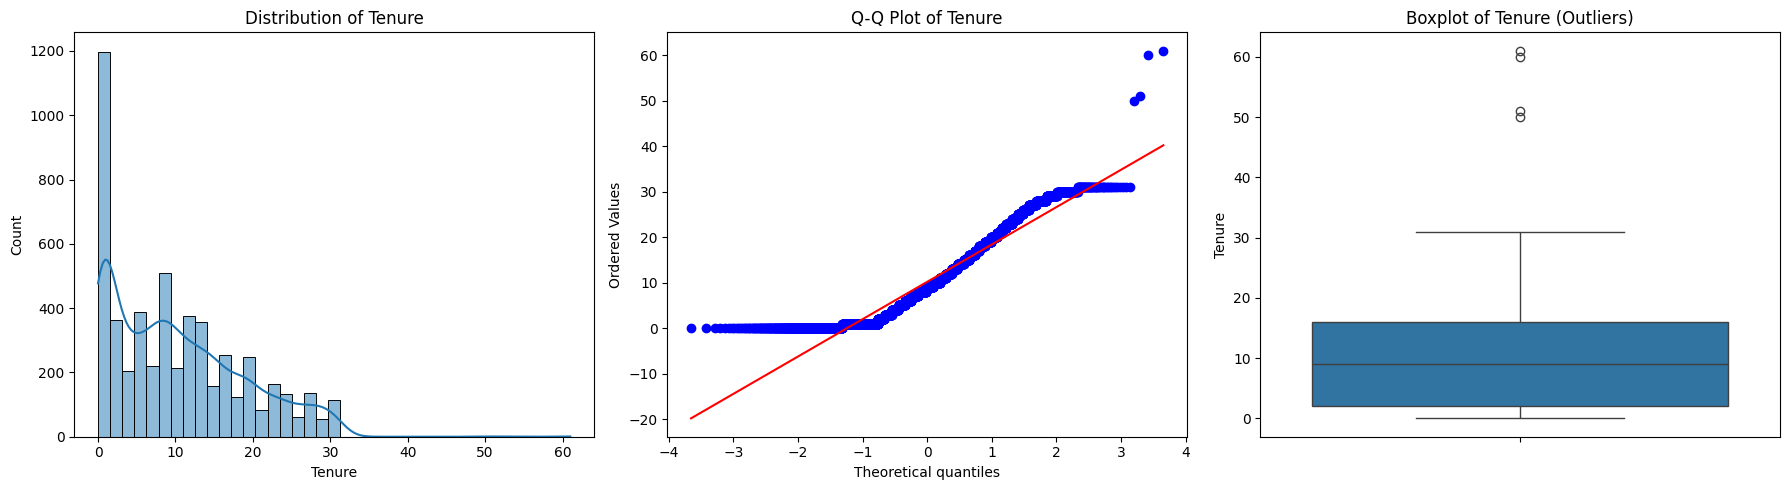

In [9]:
analyze_numerical_feature(df_ecommerce, 'Tenure')


The distribution of customer tenure is **right-skewed**, meaning most customers have a short tenure. The Q-Q plot shows a clear departure from the theoretical quantiles, confirming the non-normal distribution. The boxplot highlights several outliers, representing customers with a very long tenure.

#### WarehouseToHome

==================== Analyzing Numerical Feature: WarehouseToHome ====================



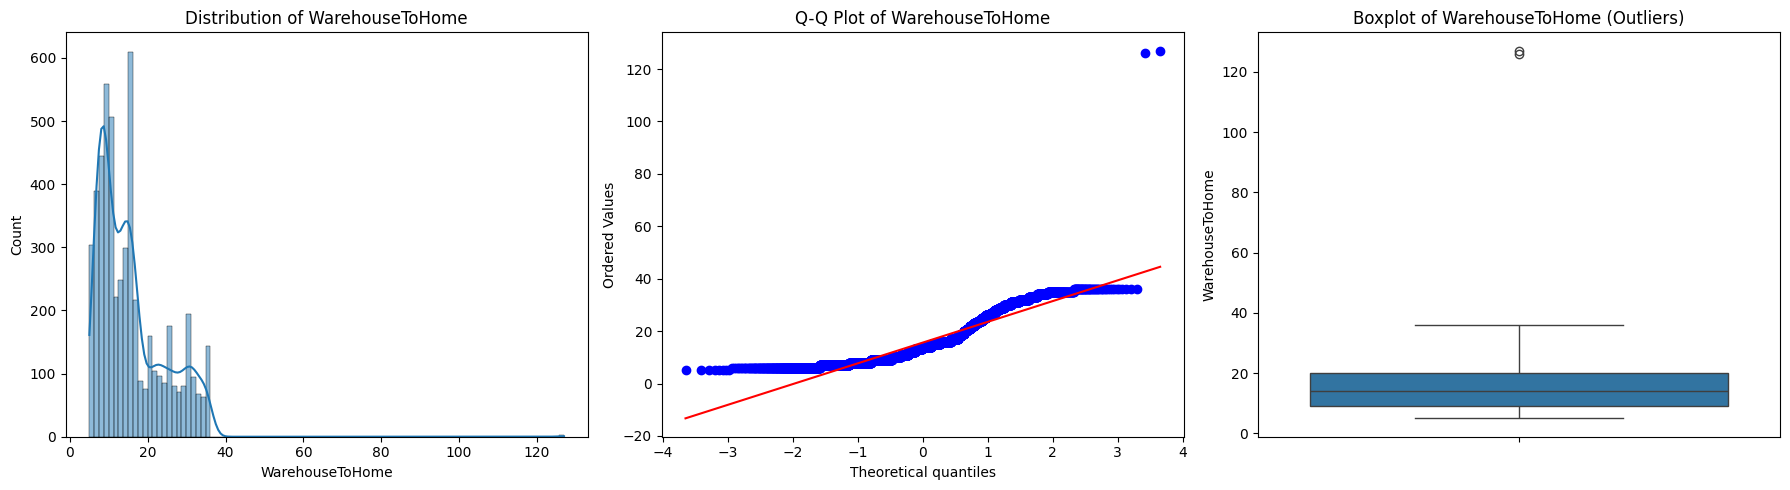

In [10]:
analyze_numerical_feature(df_ecommerce, 'WarehouseToHome')

This distribution is also **right-skewed**, with most customers living relatively close to the warehouse (less than 20 units of distance). The Q-Q plot indicates a non-normal distribution, with the points deviating significantly from the red line. The boxplot shows many outliers, representing customers who live a great distance from the warehouse.


#### HourSpendOnApp

==================== Analyzing Numerical Feature: HourSpendOnApp ====================



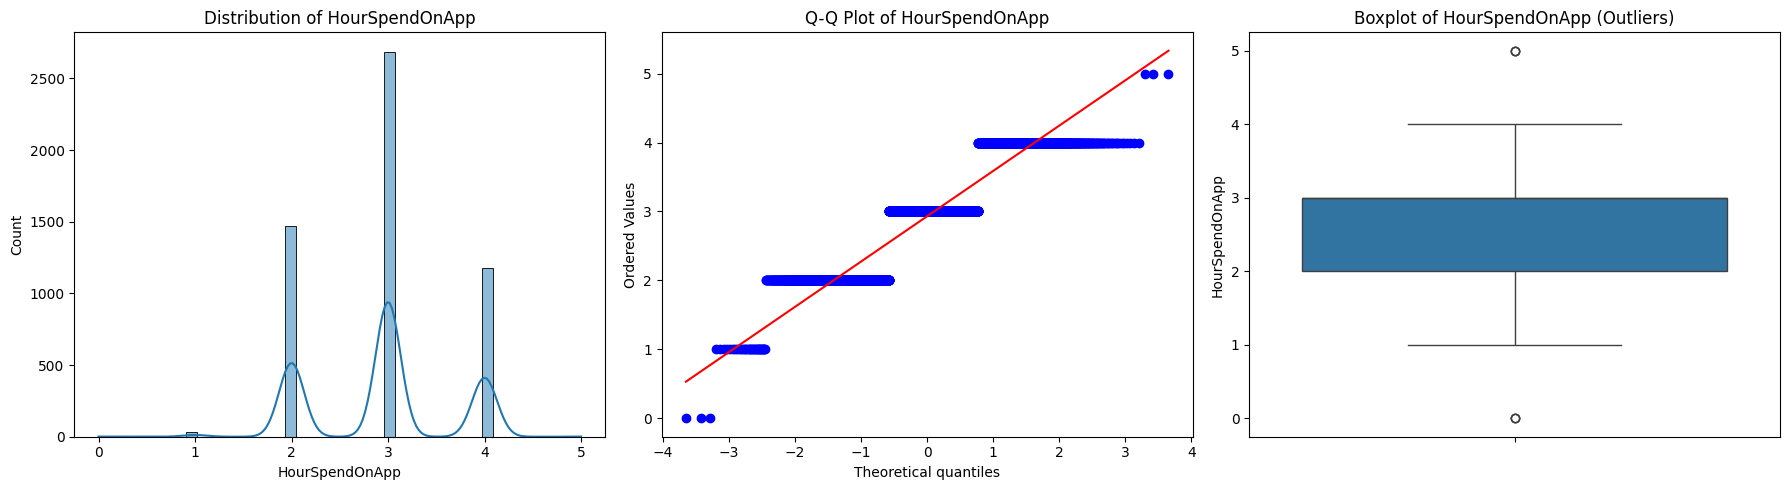

In [11]:
analyze_numerical_feature(df_ecommerce, 'HourSpendOnApp')

The distribution is **multimodal**, with clear peaks at 1, 2, 3, and 4 hours. The most common time spent on the app is 3 hours. The Q-Q plot shows that the data is not normally distributed. The boxplot shows outliers at 0 and 5 hours.

#### NumberOfDeviceRegistered

==================== Analyzing Numerical Feature: NumberOfDeviceRegistered ====================



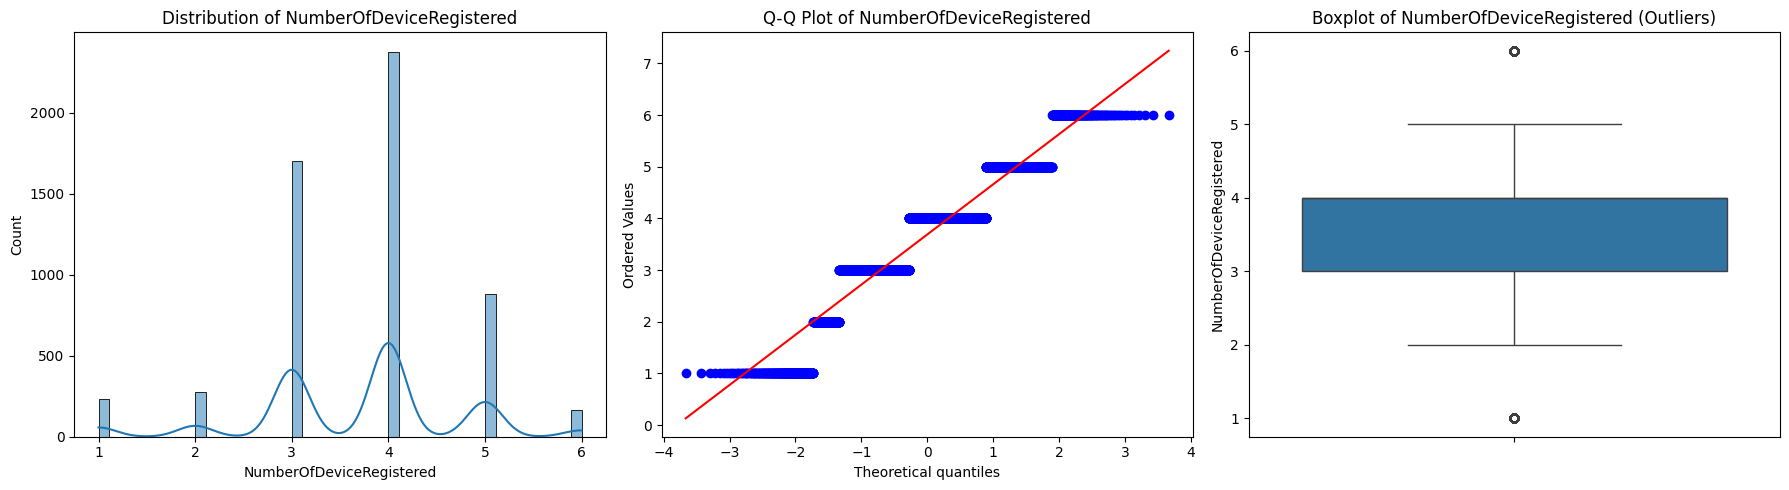

In [12]:
analyze_numerical_feature(df_ecommerce, 'NumberOfDeviceRegistered')

The distribution is **multimodal**, with distinct peaks at 1, 3, 4, 5, and 6 devices. The most common number of devices is 4. The data is not normally distributed, as shown by the Q-Q plot and the distinct peaks in the histogram. The boxplot indicates a few outliers, with a registered device count of 1 and 6.

#### NumberOfAddress

==================== Analyzing Numerical Feature: NumberOfAddress ====================



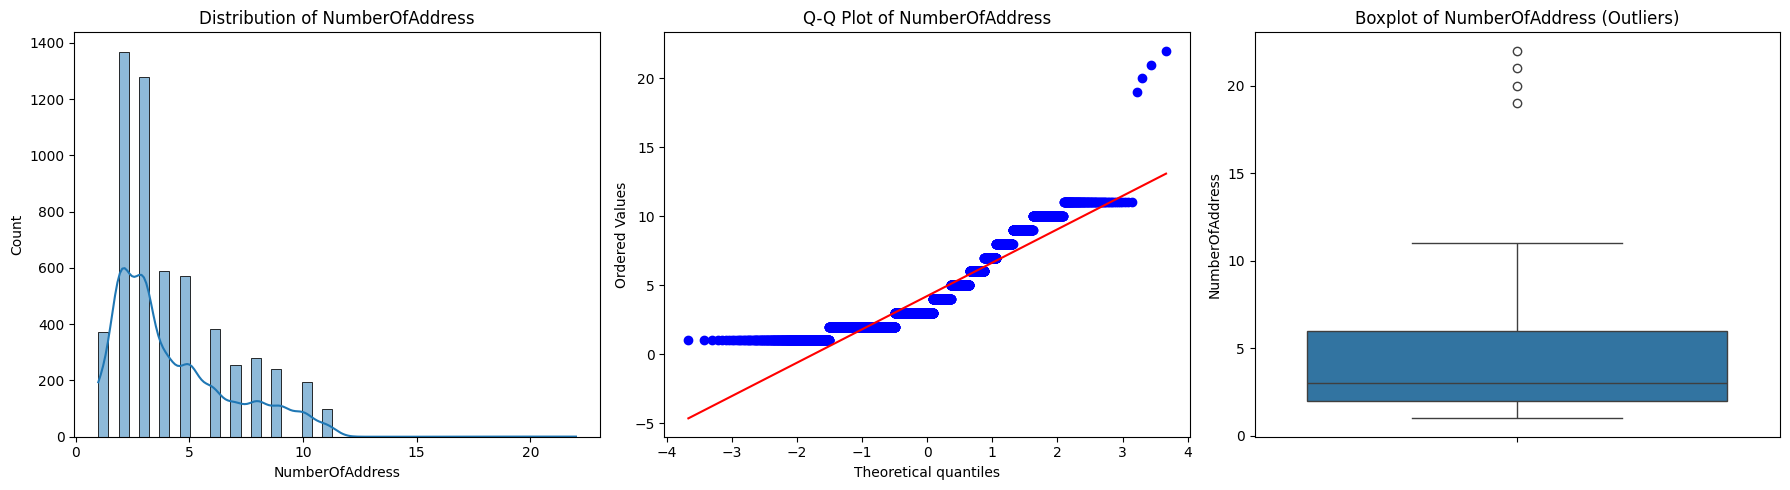

In [13]:
analyze_numerical_feature(df_ecommerce, 'NumberOfAddress')

The data is **heavily right-skewed**, with most customers having a small number of addresses (1 to 5). The frequency of customers decreases significantly as the number of addresses increases. The Q-Q plot and the boxplot with multiple outliers confirm the non-normal and skewed nature of the data.

#### OrderAmountHikeFromlastYear

==================== Analyzing Numerical Feature: OrderAmountHikeFromlastYear ====================



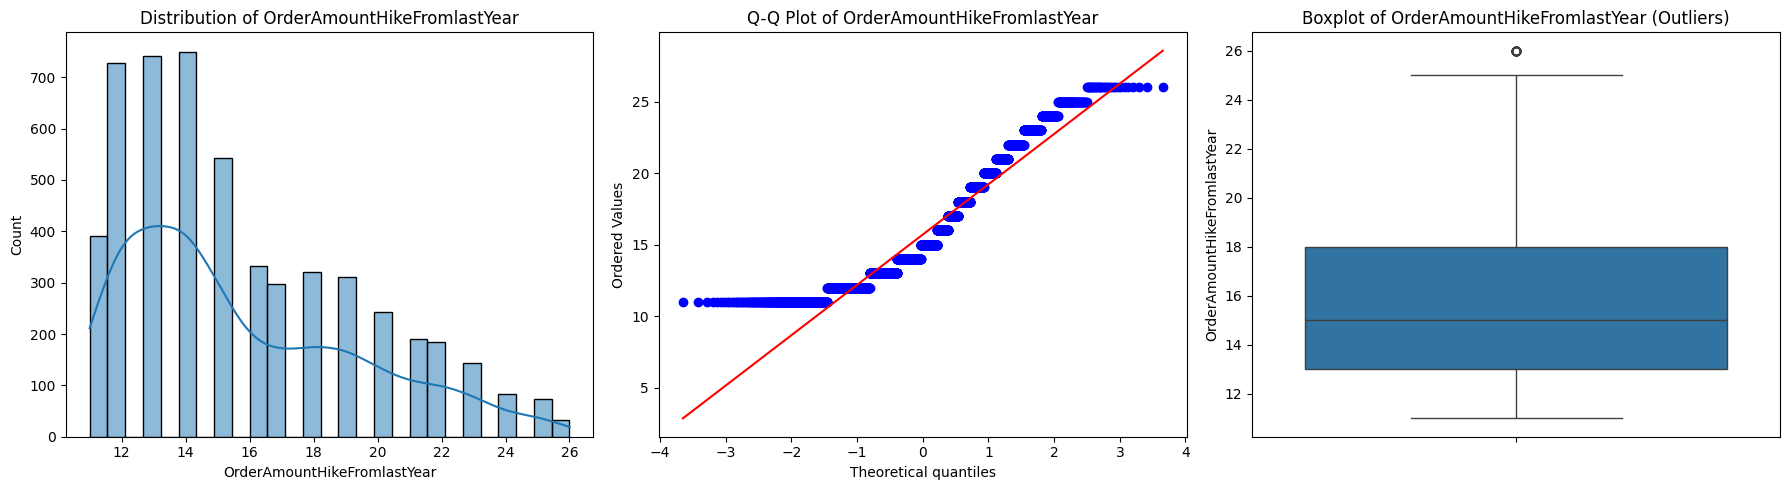

In [14]:
analyze_numerical_feature(df_ecommerce, 'OrderAmountHikeFromlastYear')

The distribution appears **slightly left-skewed**, with a peak around a 14% to 15% increase. The Q-Q plot shows a slight deviation from the normal distribution. The boxplot reveals a few outliers at the upper and lower ends of the range.

#### CouponUsed

==================== Analyzing Numerical Feature: CouponUsed ====================



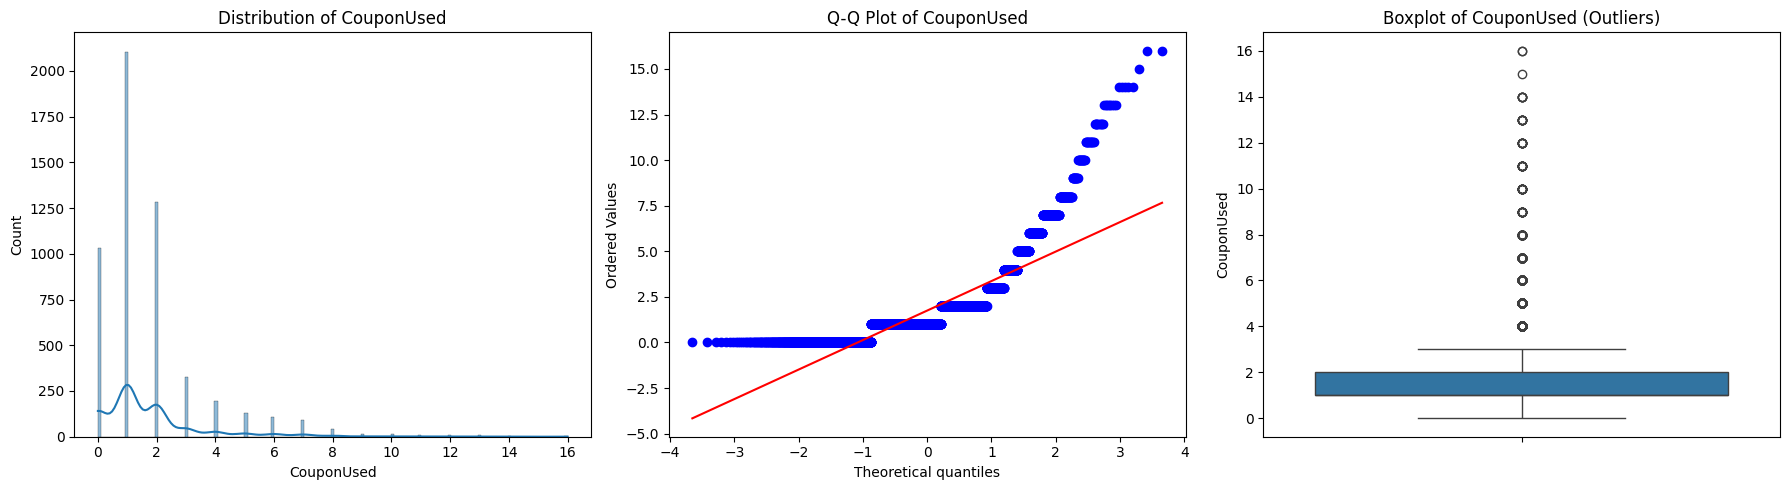

In [15]:
analyze_numerical_feature(df_ecommerce, 'CouponUsed')

The distribution of coupons used is **heavily right-skewed**, with a large majority of customers using 0 or 1 coupon. The number of customers drops dramatically as the number of coupons used increases. The Q-Q plot and the boxplot with many outliers confirm this extreme skewness.

#### OrderCount

==================== Analyzing Numerical Feature: OrderCount ====================



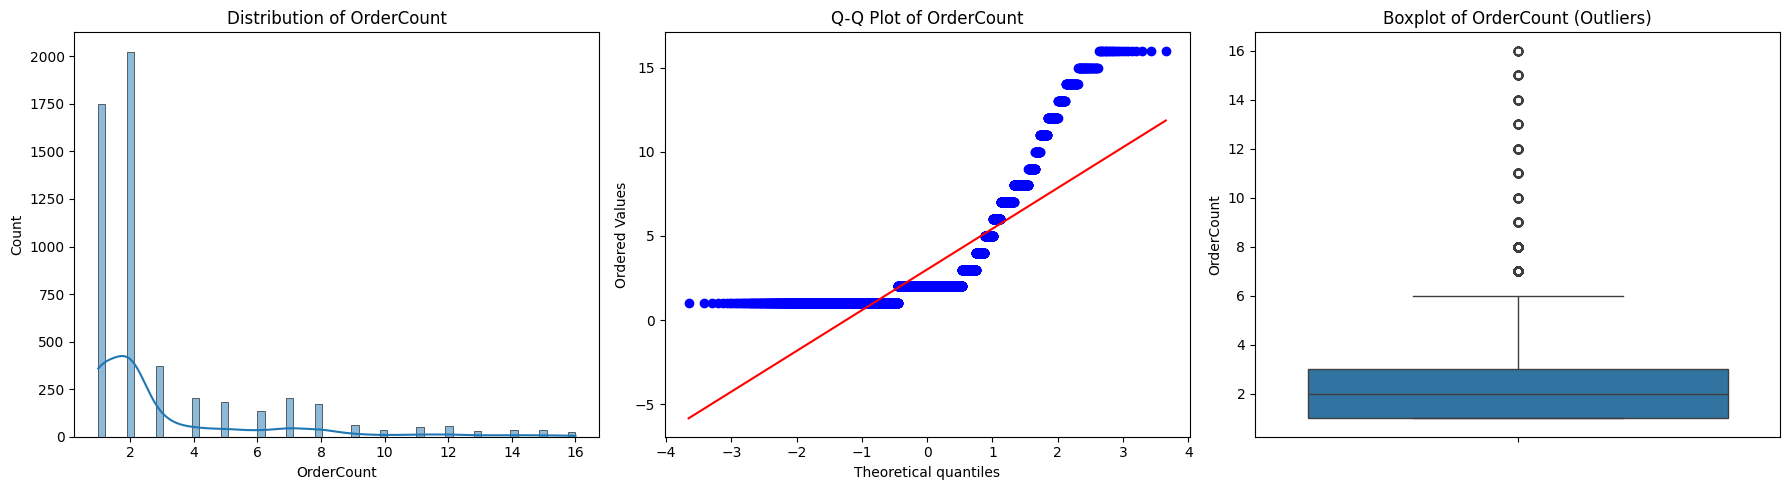

In [16]:
analyze_numerical_feature(df_ecommerce, 'OrderCount')

The data for order count is **heavily right-skewed**, with most customers having a low number of orders (1 or 2). As the order count increases, the frequency of customers drops sharply. The Q-Q plot and the boxplot with numerous outliers confirm this pattern.

#### DaySinceLastOrder

==================== Analyzing Numerical Feature: DaySinceLastOrder ====================



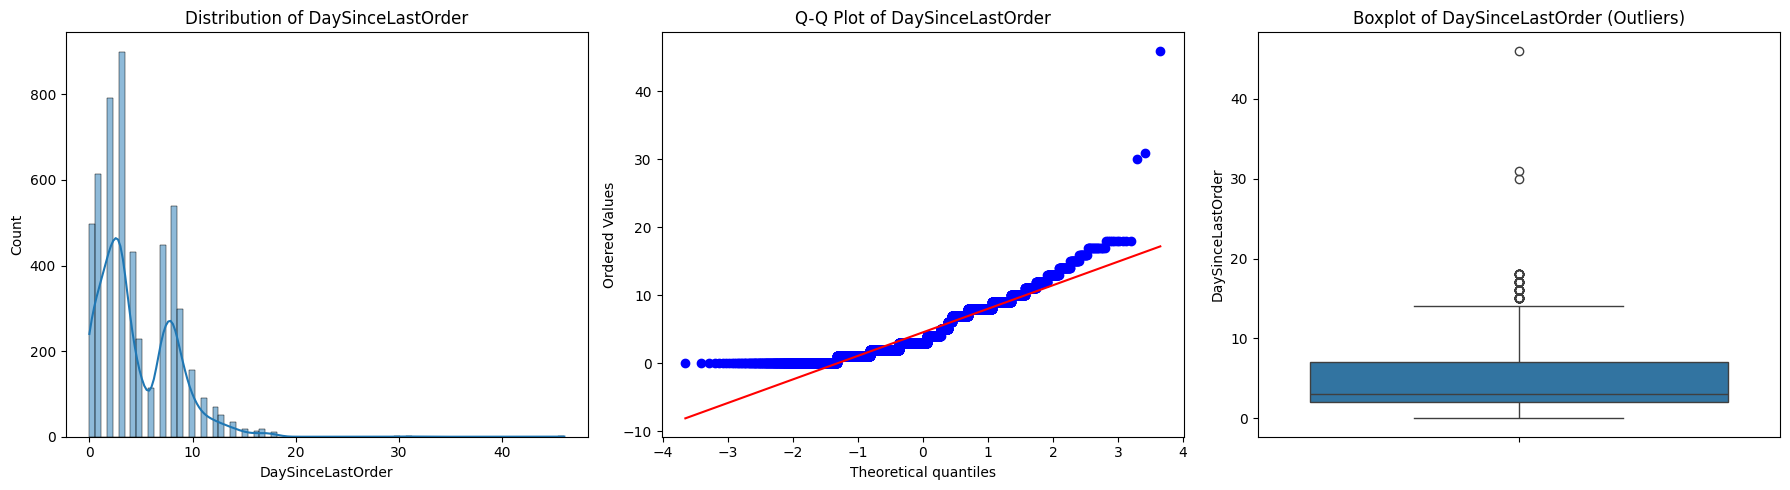

In [17]:
analyze_numerical_feature(df_ecommerce, 'DaySinceLastOrder')

The data is heavily **right-skewed**, indicating that most customers placed an order very recently. The majority of customers last ordered within the first 10 days. The Q-Q plot shows a clear departure from the normal distribution, confirming the skewness. The boxplot reveals numerous outliers, representing customers who haven't ordered in a long time.

#### CashbackAmount

==================== Analyzing Numerical Feature: CashbackAmount ====================



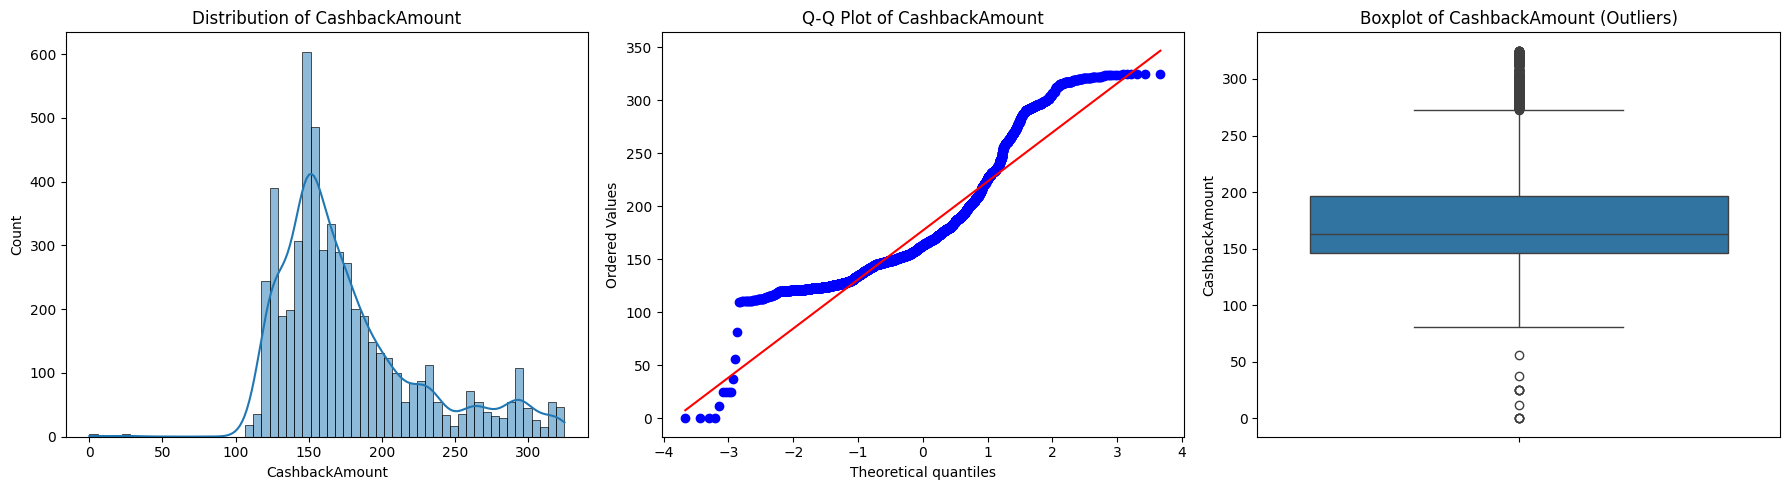

In [18]:
analyze_numerical_feature(df_ecommerce, 'CashbackAmount')

The distribution of cashback amount is **bimodal**, with two peaks. This suggests that there might be two different groups of customers based on their cashback amount. The Q-Q plot confirms that the data is not normally distributed. The boxplot shows several outliers on both the high and low ends.

### 3.5.2. Bivariate Numerical Analysis

In [19]:
def analyze_numerical_by_churn(df, col, target='Churn'):
    """
    Analyze a numerical feature with respect to a binary target (Churn).
    Includes boxplot, histogram with KDE, and appropriate statistical test
    (T-test if normal, Mann-Whitney U if not).
    
    Parameters:
    - df: pandas DataFrame
    - col: column name (string) of numerical feature
    - target: target column name (default 'Churn')
    """
    print(f'{"="*20} Analyzing {col} by {target} {"="*20}\n')
    
    plt.figure(figsize=(14, 6))  # Adjust figure size for two plots
    
    # Boxplot by Churn with distinct colors
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target, y=col, data=df, hue=target, palette='viridis', legend=False)
    plt.title(f'Boxplot of {col} by {target}')
    
    # Histplot with KDE by Churn
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=col, hue=target, kde=True, palette='viridis', multiple="stack")
    plt.title(f'Distribution of {col} by {target} (KDE)')
    
    plt.tight_layout()
    plt.show()

#### Tenure

==================== Analyzing Tenure by Churn ====================



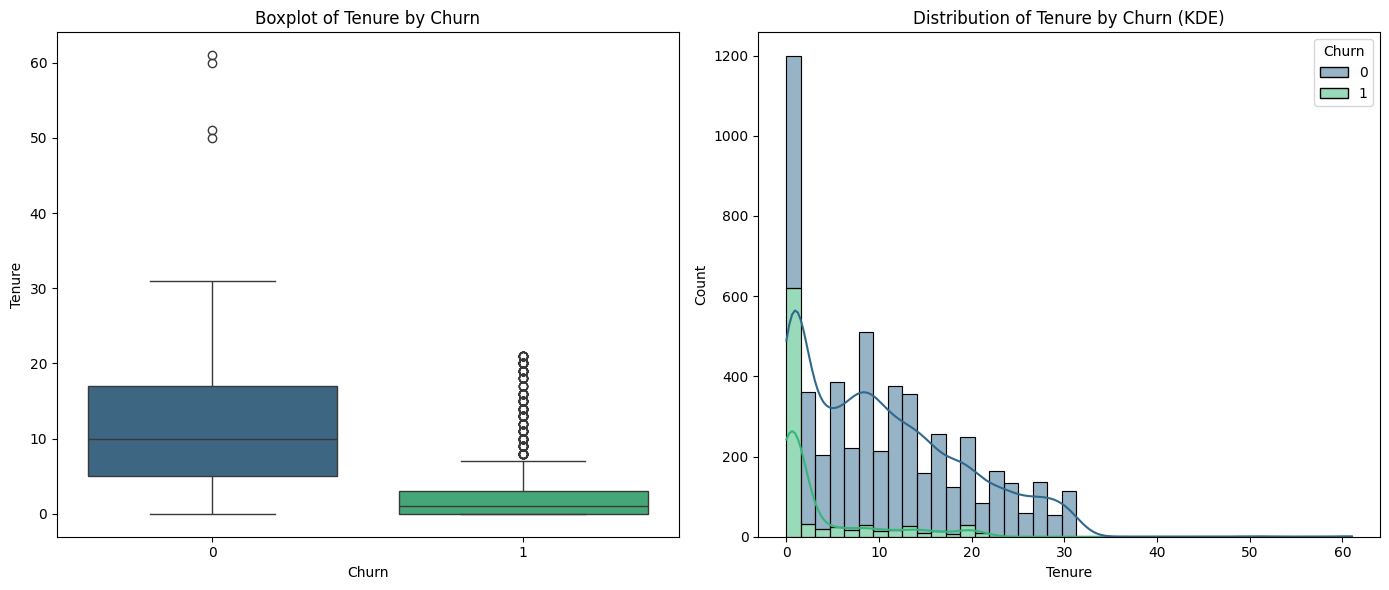

In [20]:
analyze_numerical_by_churn(df_ecommerce, 'Tenure')

There is a **strong relationship** between tenure and churn. The charts show that customers with **short tenure** (less than 5 units) are far more likely to churn than those with longer tenure. The median tenure for non-churning customers is significantly higher than for churning customers.

#### WarehouseToHome

==================== Analyzing WarehouseToHome by Churn ====================



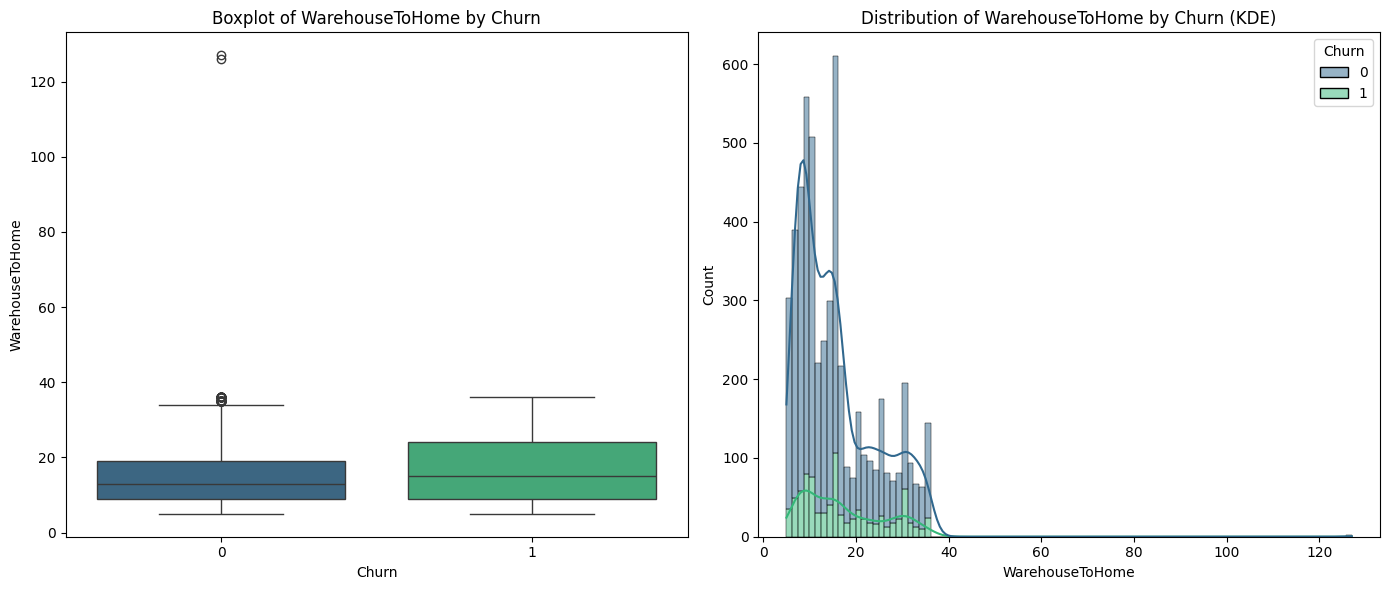

In [21]:
analyze_numerical_by_churn(df_ecommerce, 'WarehouseToHome')

There isn't a significant difference in the distribution of warehouse-to-home distance between churning and non-churning customers. The medians and overall boxplot ranges are very similar, suggesting this factor may not be a strong predictor of churn.

#### HourSpendOnApp

==================== Analyzing HourSpendOnApp by Churn ====================



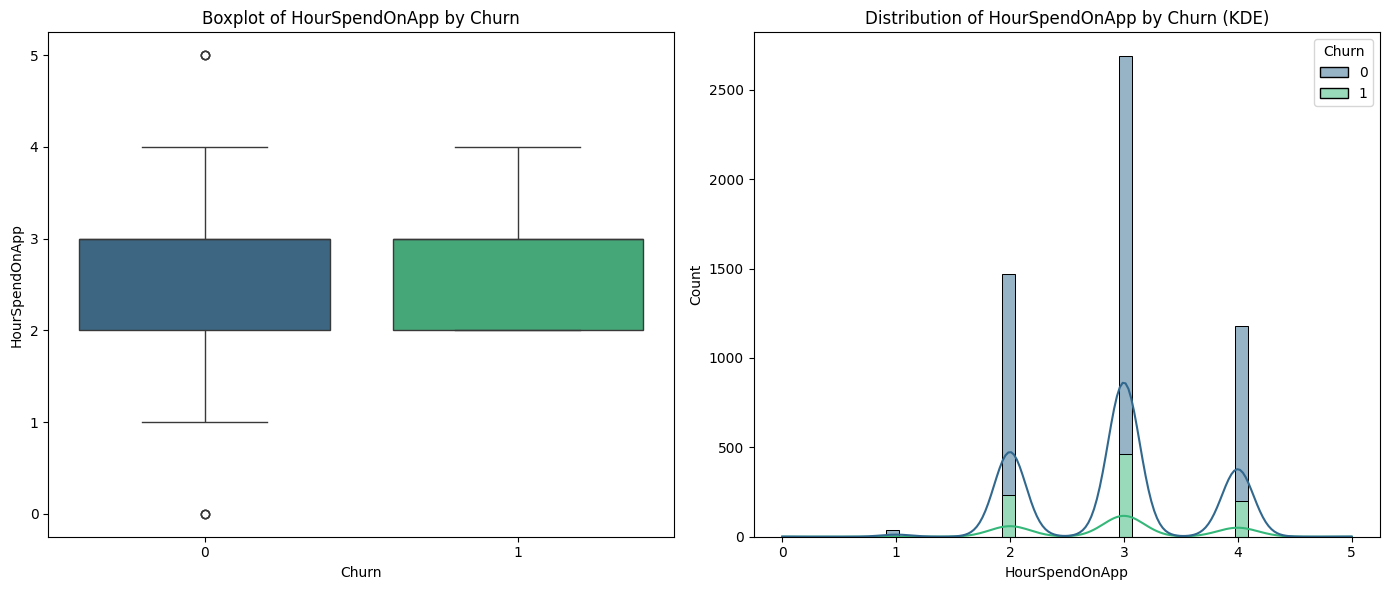

In [22]:
analyze_numerical_by_churn(df_ecommerce, 'HourSpendOnApp')

The distributions are quite similar for both churning and non-churning customers. The boxplots show very similar medians and ranges, suggesting they are **not strong predictors of churn**.

#### NumberOfDeviceRegistered

==================== Analyzing NumberOfDeviceRegistered by Churn ====================



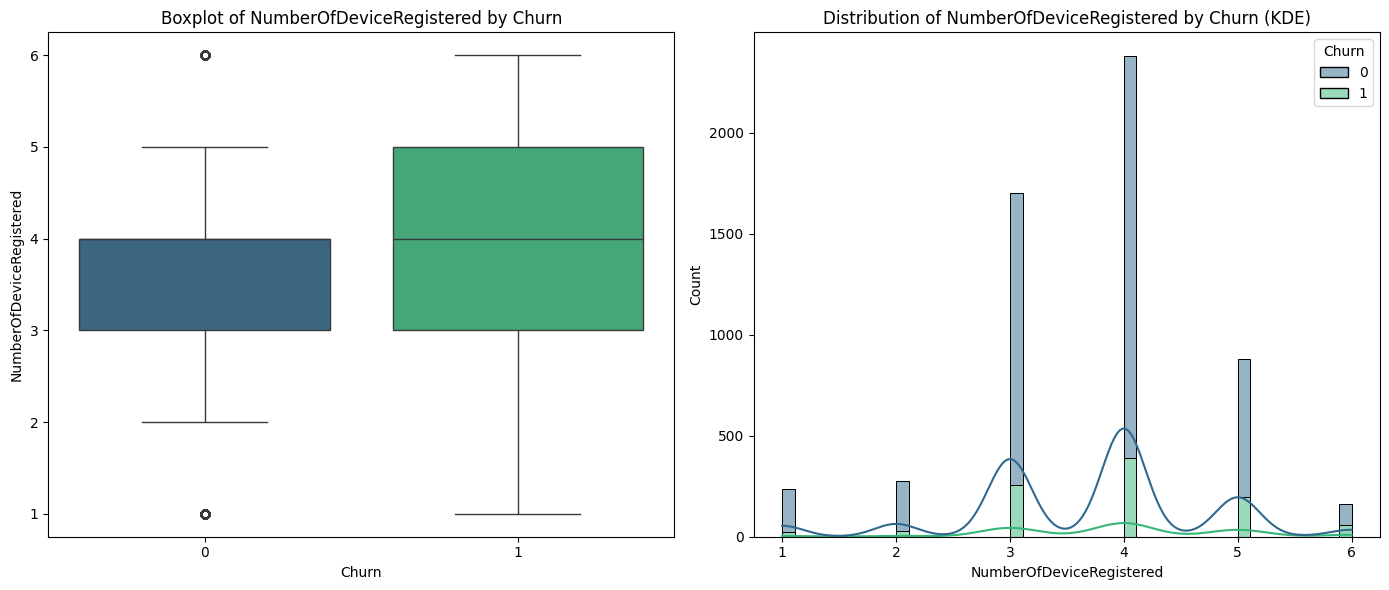

In [23]:
analyze_numerical_by_churn(df_ecommerce, 'NumberOfDeviceRegistered')

Customers who churn tend to have a **higher number of registered devices**. The median number of devices for churning customers is 4, while for non-churning customers it is 3. This could imply that customers with more registered devices are less committed to a single platform.

#### NumberOfAddress

==================== Analyzing NumberOfAddress by Churn ====================



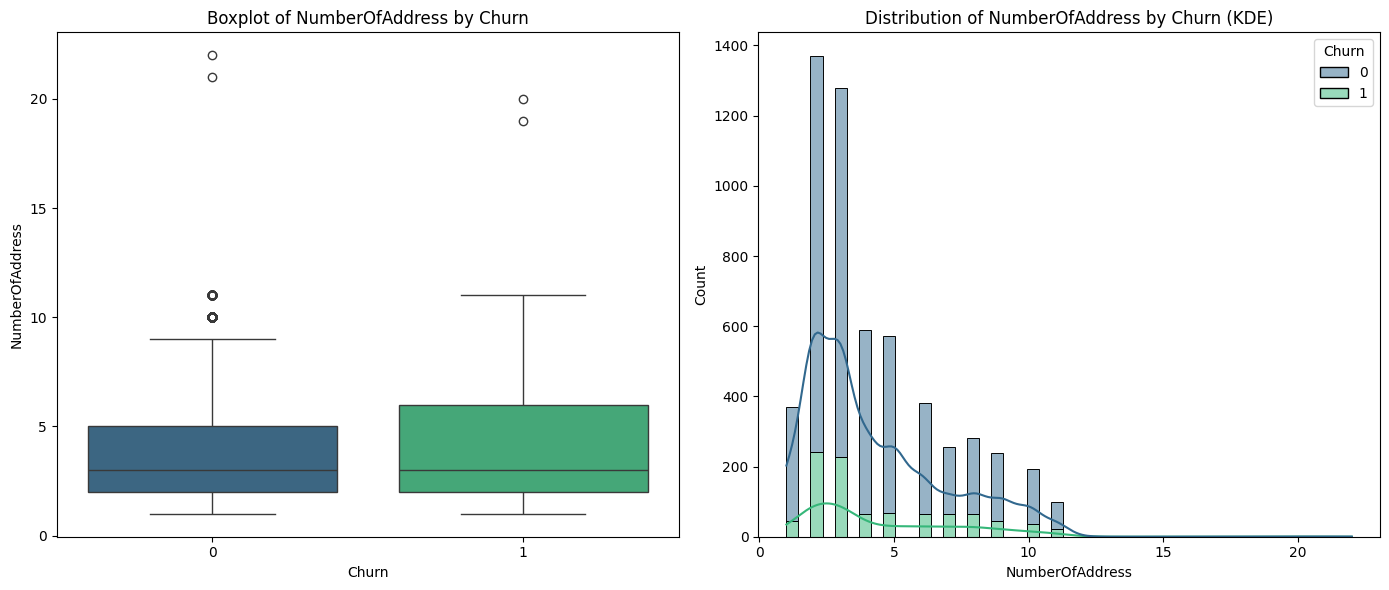

In [24]:
analyze_numerical_by_churn(df_ecommerce, 'NumberOfAddress')

#### OrderAmountHikeFromlastYear

==================== Analyzing OrderAmountHikeFromlastYear by Churn ====================



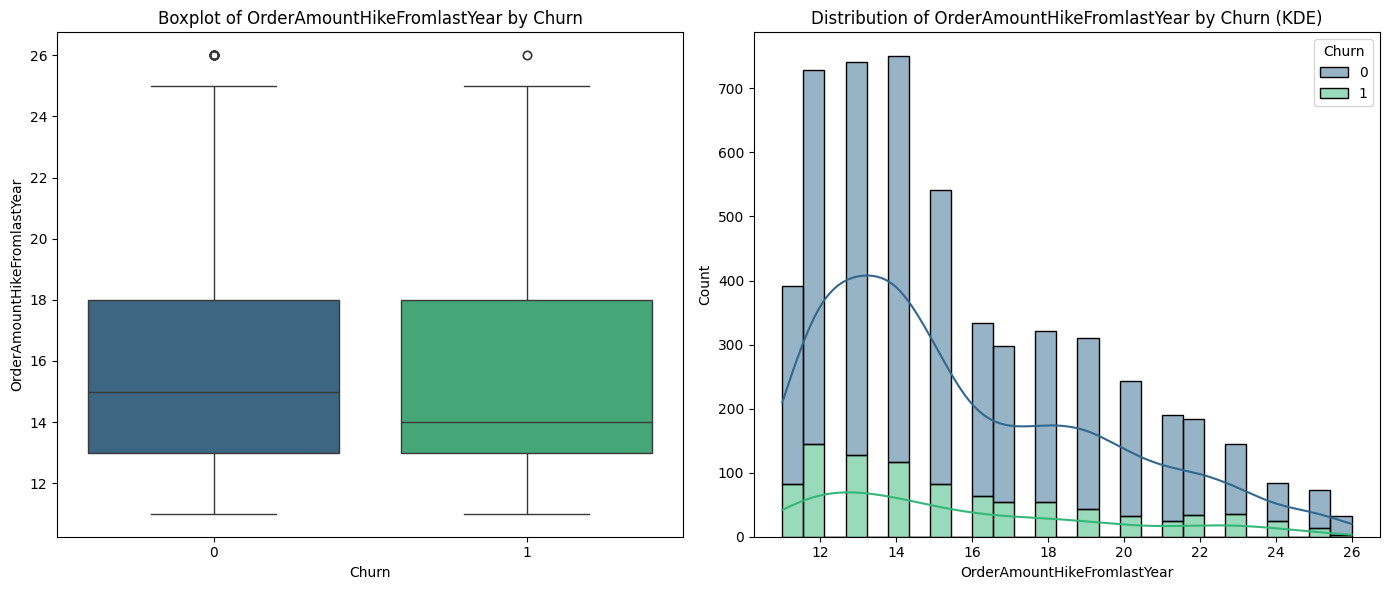

In [25]:
analyze_numerical_by_churn(df_ecommerce, 'OrderAmountHikeFromlastYear')

The distributions are quite similar for both churning and non-churning customers. The boxplots show very similar medians and ranges, suggesting they are **not strong predictors of churn**.

#### CouponUsed

==================== Analyzing CouponUsed by Churn ====================



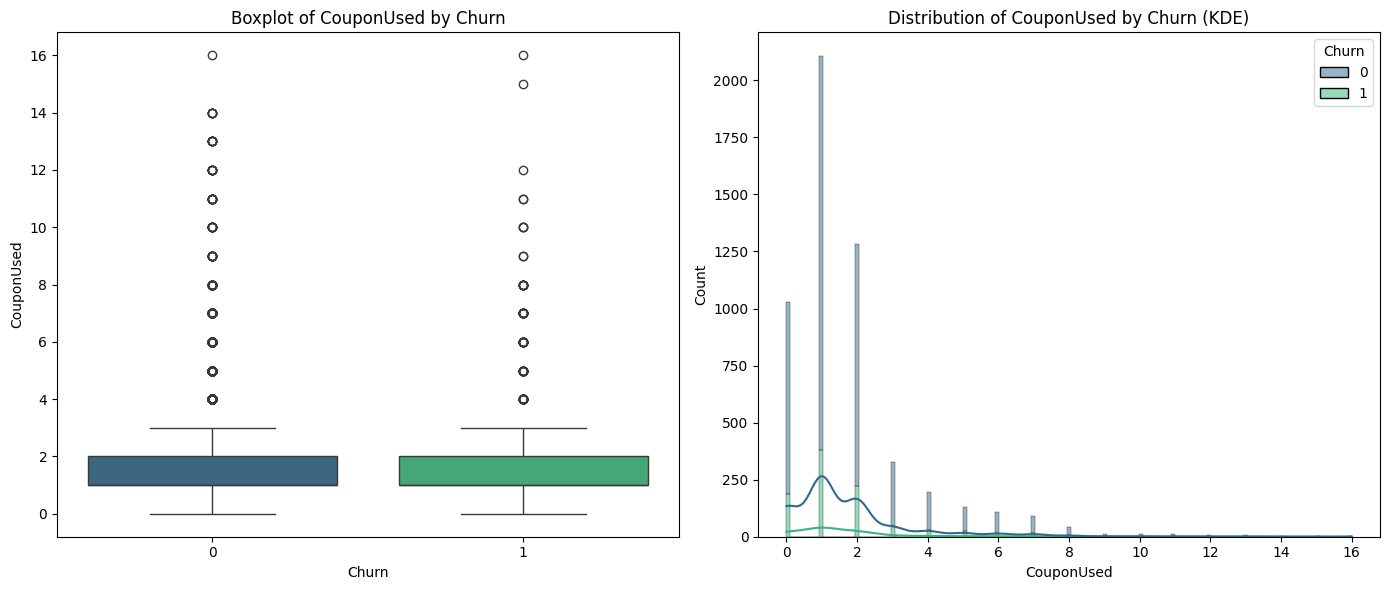

In [26]:
analyze_numerical_by_churn(df_ecommerce, 'CouponUsed')

For coupon used, the distributions are **heavily skewed towards low values** for both churning and non-churning customers. While there are slight differences, neither variable appears to have a strong, clear relationship with churn.

#### OrderCount

==================== Analyzing OrderCount by Churn ====================



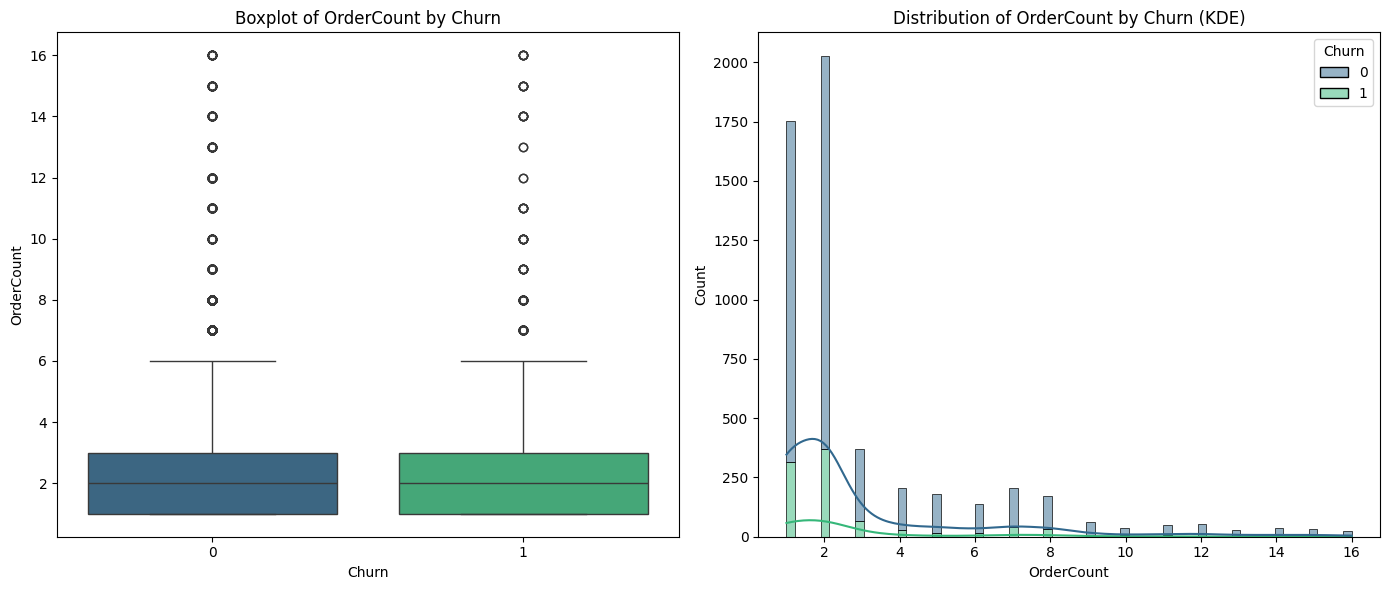

In [27]:
analyze_numerical_by_churn(df_ecommerce, 'OrderCount')

For order count, the distributions are **heavily skewed towards low values** for both churning and non-churning customers. While there are slight differences, neither variable appears to have a strong, clear relationship with churn.

#### DaySinceLastOrder

==================== Analyzing DaySinceLastOrder by Churn ====================



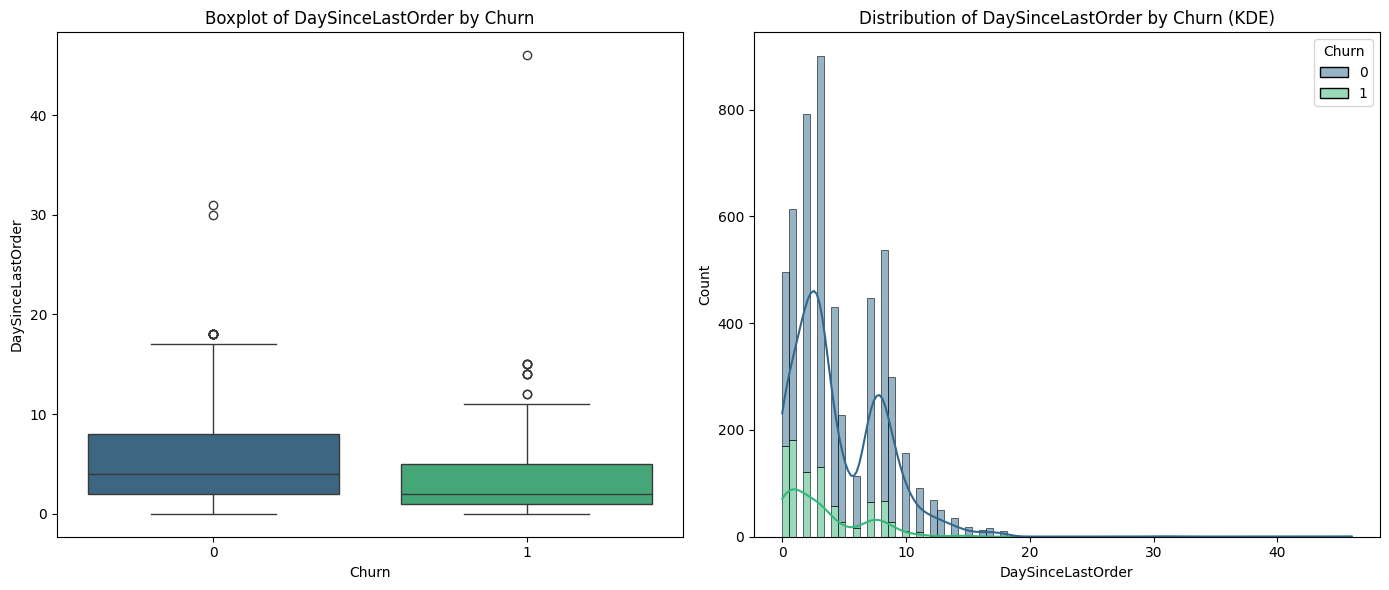

In [28]:
analyze_numerical_by_churn(df_ecommerce, 'DaySinceLastOrder')

Customers who have not churned have a **wider range** of days since their last order, but the majority of churning customers have a very **recent last order** (typically within the first 5 days). This could indicate that customers are leaving shortly after a recent poor experience.

#### CashbackAmount

==================== Analyzing CashbackAmount by Churn ====================



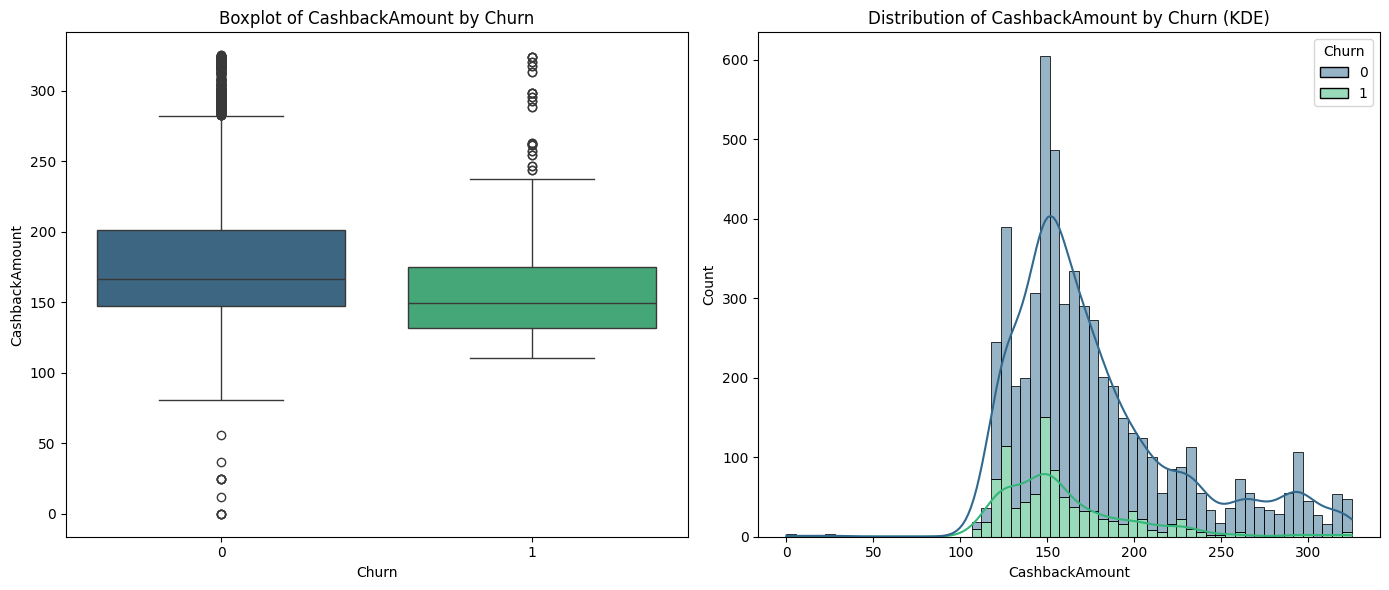

In [29]:
analyze_numerical_by_churn(df_ecommerce, 'CashbackAmount')

The median cashback amount is noticeably **lower** for churning customers compared to non-churning customers. This suggests that a higher cashback amount may be a factor in retaining customers.

## 3.6. In-depth Categorical Analysis

In [30]:
# Define all categorical features to analyze
categorical_features = df_ecommerce.select_dtypes(include='object').columns.tolist()
ordinal_binary_features = ['CityTier', 'SatisfactionScore', 'Complain']
all_categorical = categorical_features + ordinal_binary_features

### 3.6.1. Univariate

In [31]:
def analyze_univariate_categorical(df_ecommerce, all_categorical):
    """
    Analyzes and visualizes each categorical feature in a DataFrame
    by generating a countplot and a pie chart.

    Parameters:
    - df_ecommerce (pd.DataFrame): The input DataFrame.
    - all_categorical (list): A list of categorical column names.
    """
    for col in all_categorical:
        print(f'\nAnalyzing Univariate Feature: {col}')
        
        # Check for "super minority" classes (e.g., less than 1% of the total)
        total_count = len(df_ecommerce[col])
        value_counts = df_ecommerce[col].value_counts(normalize=True)
        minority_classes = value_counts[value_counts < 0.01].index.tolist()
        
        if minority_classes:
            print(f"Warning: The following classes in '{col}' are super minority classes (<1%): {minority_classes}")
            print("Consider grouping these classes for better analysis/modeling.")

        plt.figure(figsize=(18, 7))

        # Subplot 1: Countplot for absolute counts
        plt.subplot(1, 2, 1)
        ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')
        plt.title(f'Count of {col}', fontsize=15)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel(col, fontsize=12)
        for p in ax.patches:
            width = p.get_width()
            plt.text(width + 20, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')

        # Subplot 2: Pie chart for proportions
        plt.subplot(1, 2, 2)
        counts = df_ecommerce[col].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(counts)))
        plt.title(f'Proportion of {col}', fontsize=15)
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        
        plt.tight_layout()
        plt.show()

#### PreferredLoginDevice


Analyzing Univariate Feature: PreferredLoginDevice


/tmp/ipykernel_11038/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


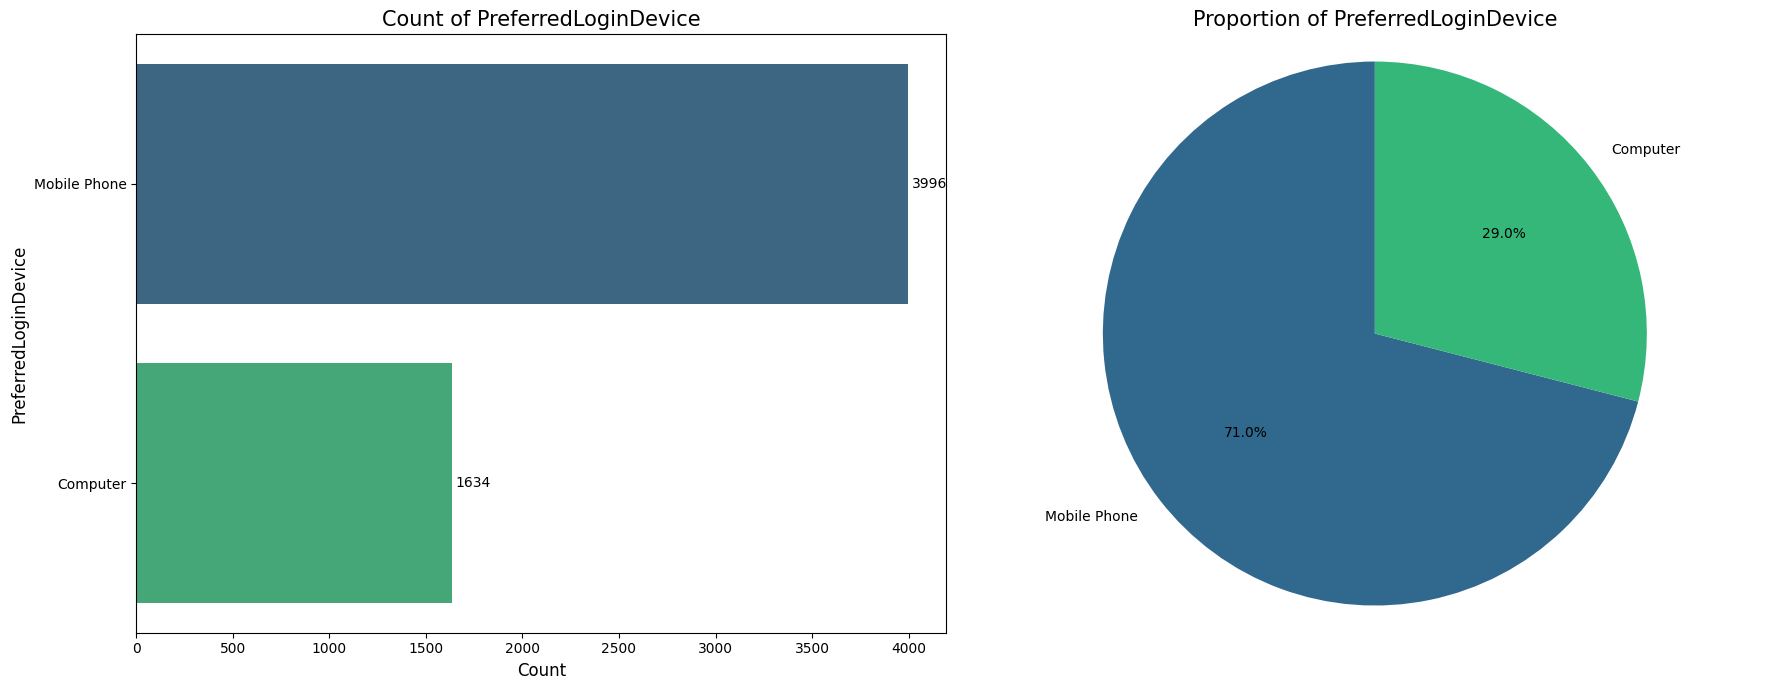

In [32]:
analyze_univariate_categorical(df_ecommerce, ['PreferredLoginDevice'])

- **Mobile Phone dominates (71%)** vs Computer (29%).

#### PreferredPaymentMode


Analyzing Univariate Feature: PreferredPaymentMode


/tmp/ipykernel_11038/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


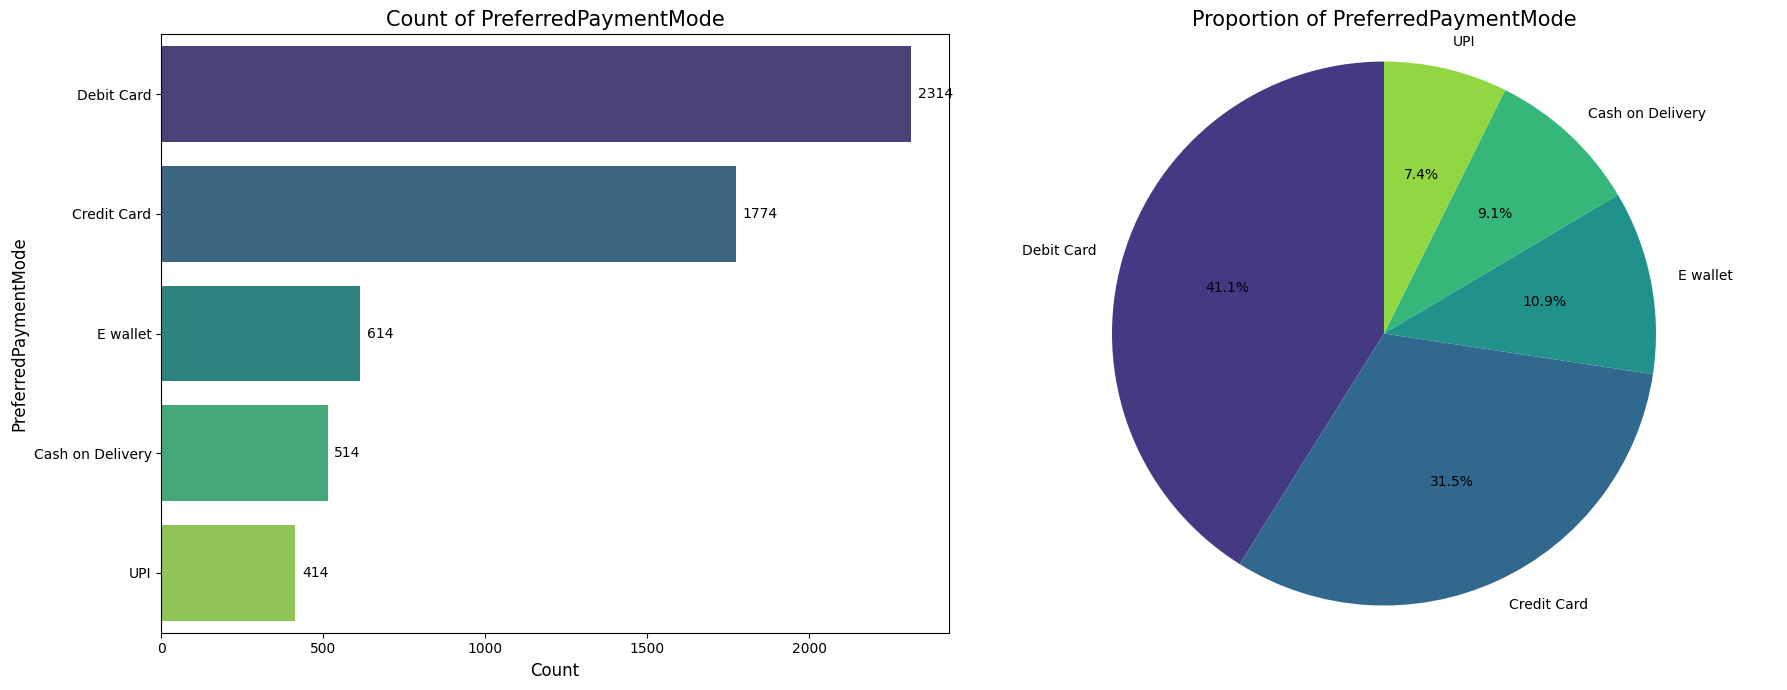

In [33]:
analyze_univariate_categorical(df_ecommerce, ['PreferredPaymentMode'])

- **Debit card leads (41%)**  
- Credit card (32%)  
- Digital wallets (~11%)  
- Cash on Delivery (~9%)  
- UPI (7%)  
➡️ Customers prefer **cards over wallets/UPI**

#### Gender


Analyzing Univariate Feature: Gender


/tmp/ipykernel_11038/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


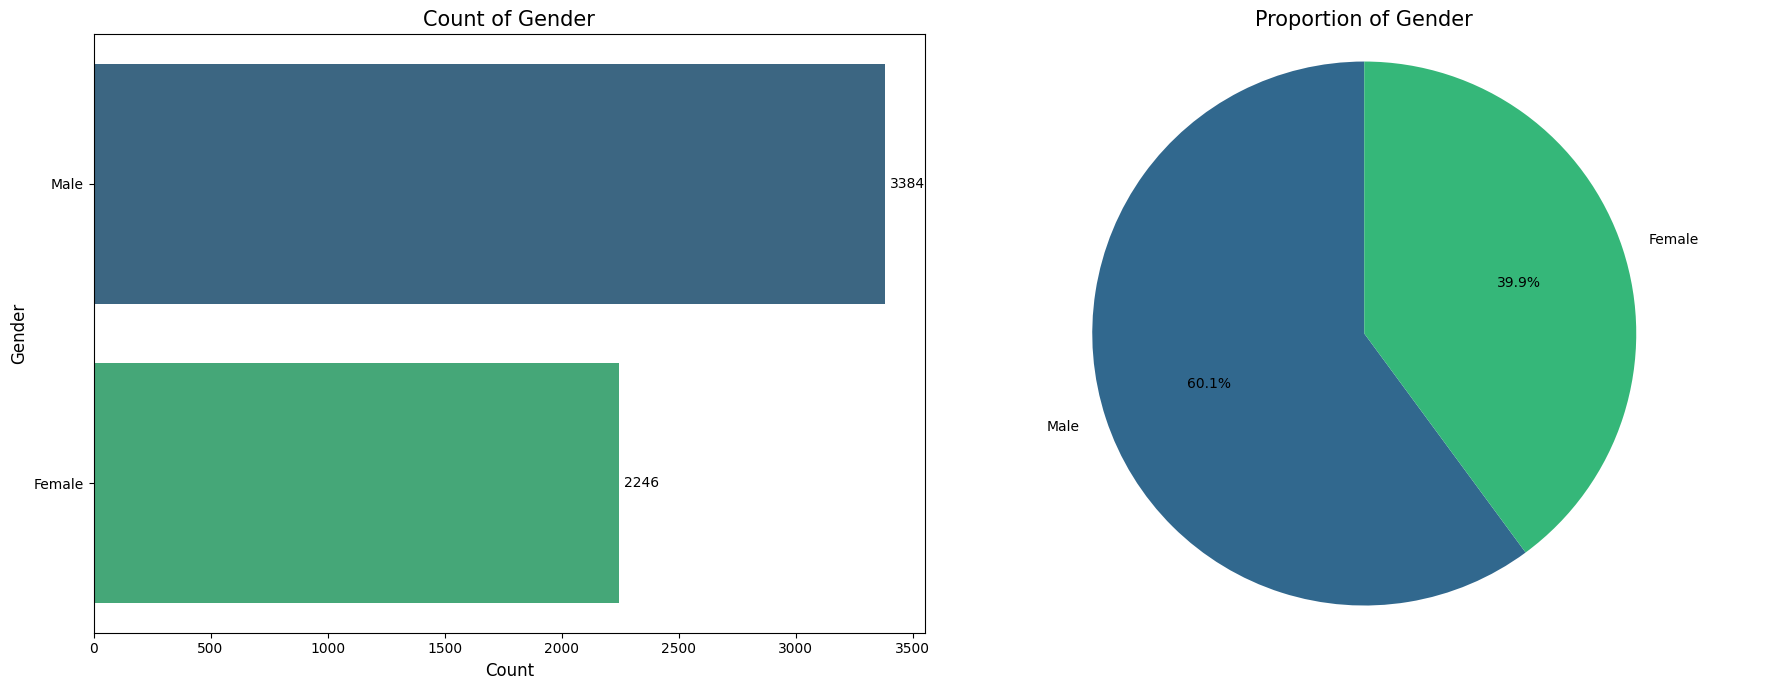

In [34]:
analyze_univariate_categorical(df_ecommerce, ['Gender'])

- Male ~60%  
- Female ~40%  
➡️ A bit male-dominated customer base, but still a significant female segment.

#### PreferedOrderCat


Analyzing Univariate Feature: PreferedOrderCat


/tmp/ipykernel_11038/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


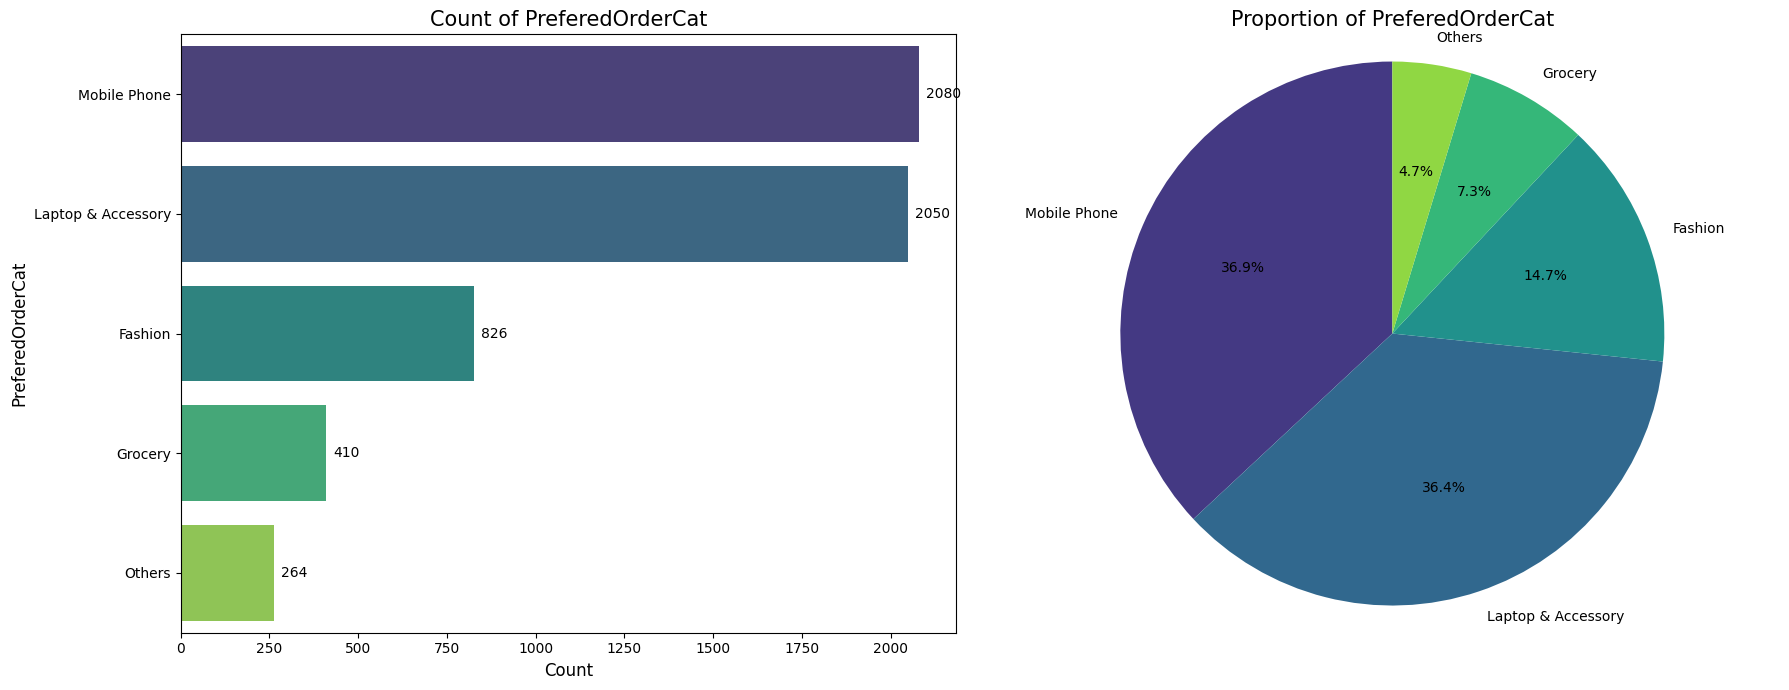

In [35]:
analyze_univariate_categorical(df_ecommerce, ['PreferedOrderCat'])

- **Mobile Phones (37%)**  
- **Laptop & Accessories (36%)**  
- Fashion (~15%)  
- Grocery (~7%)  
- Others (~5%)  
➡️ Electronics dominate; fashion & groceries are **under-penetrated growth opportunities**.

#### MaritalStatus


Analyzing Univariate Feature: MaritalStatus


/tmp/ipykernel_11038/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


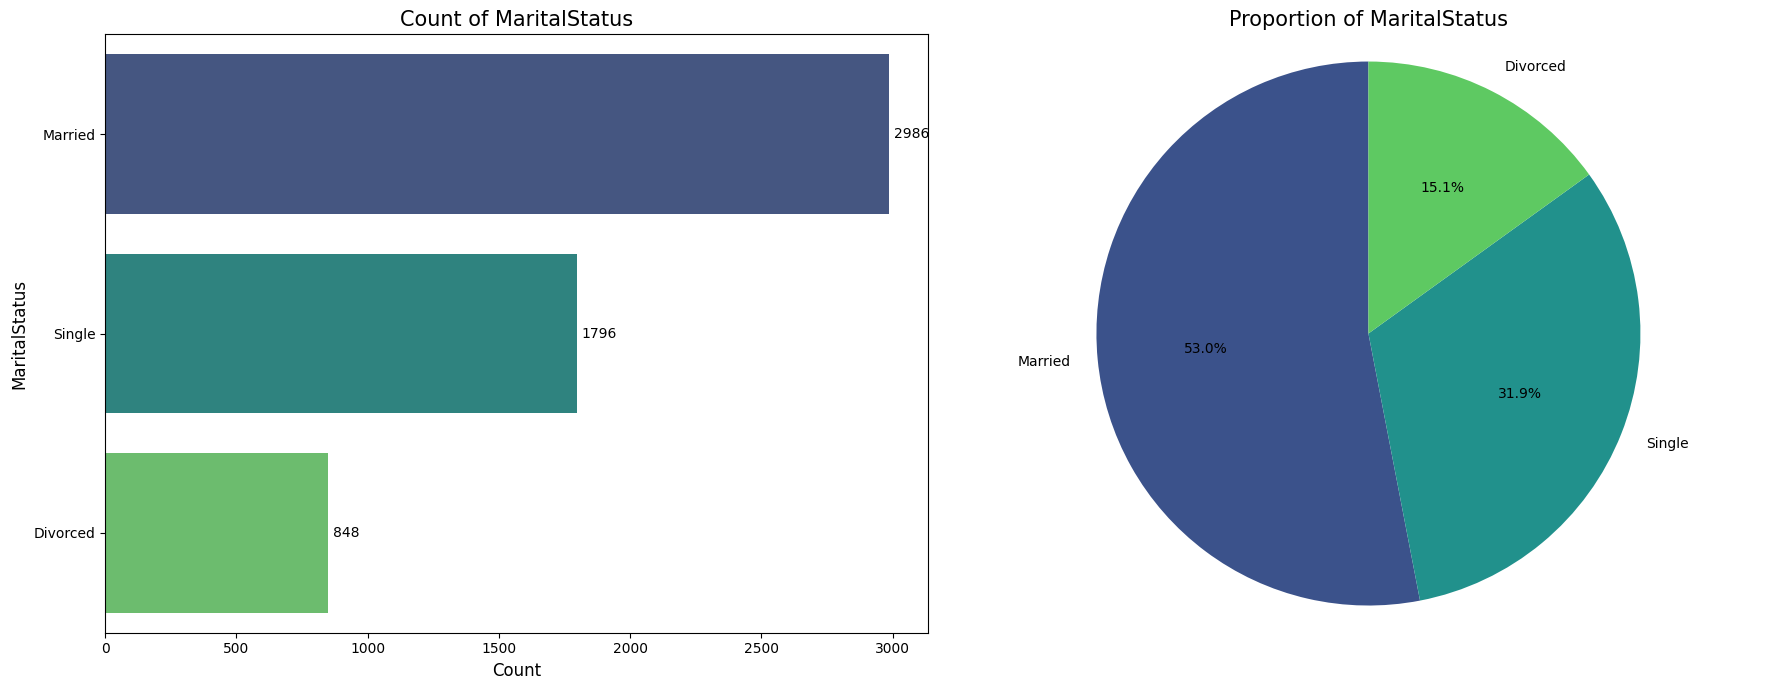

In [36]:
analyze_univariate_categorical(df_ecommerce, ['MaritalStatus'])

- the majority of customers are married, accounting for 53% of the total. Single customers are the next largest group at 31.9%, while divorced customers represent the smallest segment at 15.1%.

#### CityTier


Analyzing Univariate Feature: CityTier


/tmp/ipykernel_11038/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


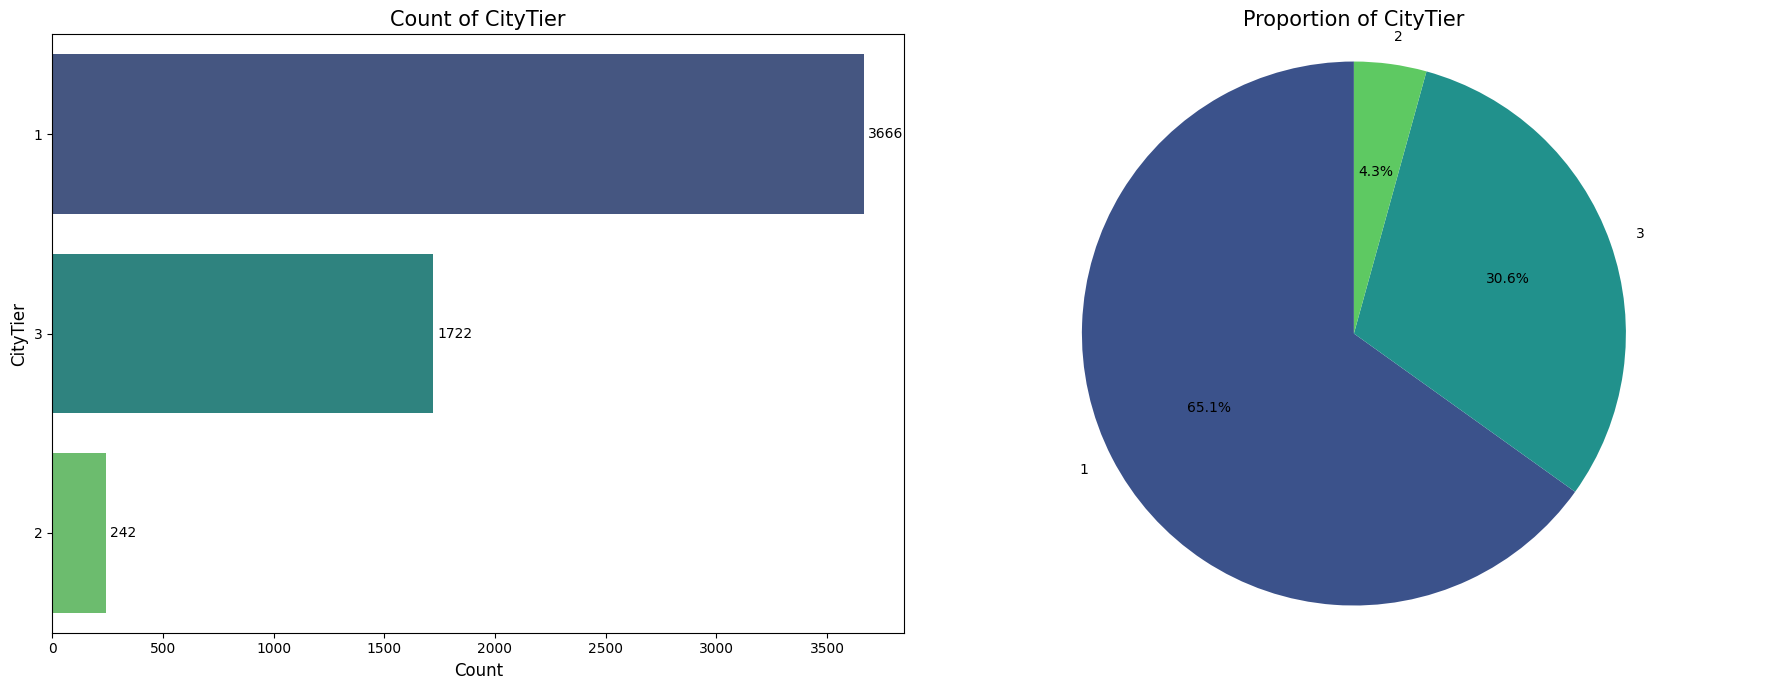

In [37]:
analyze_univariate_categorical(df_ecommerce, ['CityTier'])

- **Tier 1 cities dominate** with ~65% of customers.  
- Tier 3 contributes ~31%, while Tier 2 is very small (~4%).  
➡️ Most customers are concentrated in Tier 1 cities

#### SatisfactionScore


Analyzing Univariate Feature: SatisfactionScore


/tmp/ipykernel_11038/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


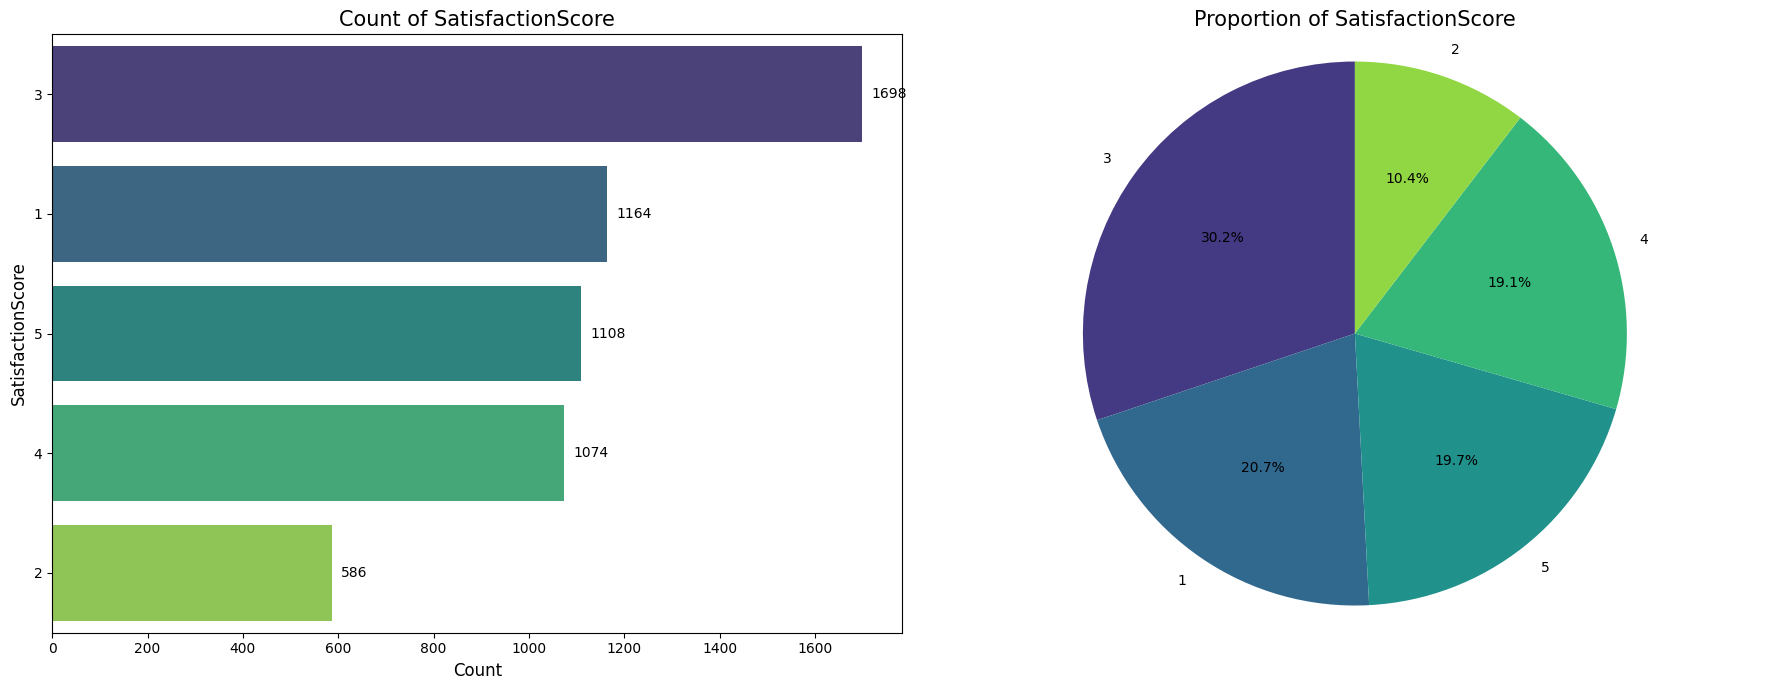

In [38]:
analyze_univariate_categorical(df_ecommerce, ['SatisfactionScore'])

- Score **3 is the most common** (~30%), suggesting many customers are neutral.

#### Complain


Analyzing Univariate Feature: Complain


/tmp/ipykernel_11038/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


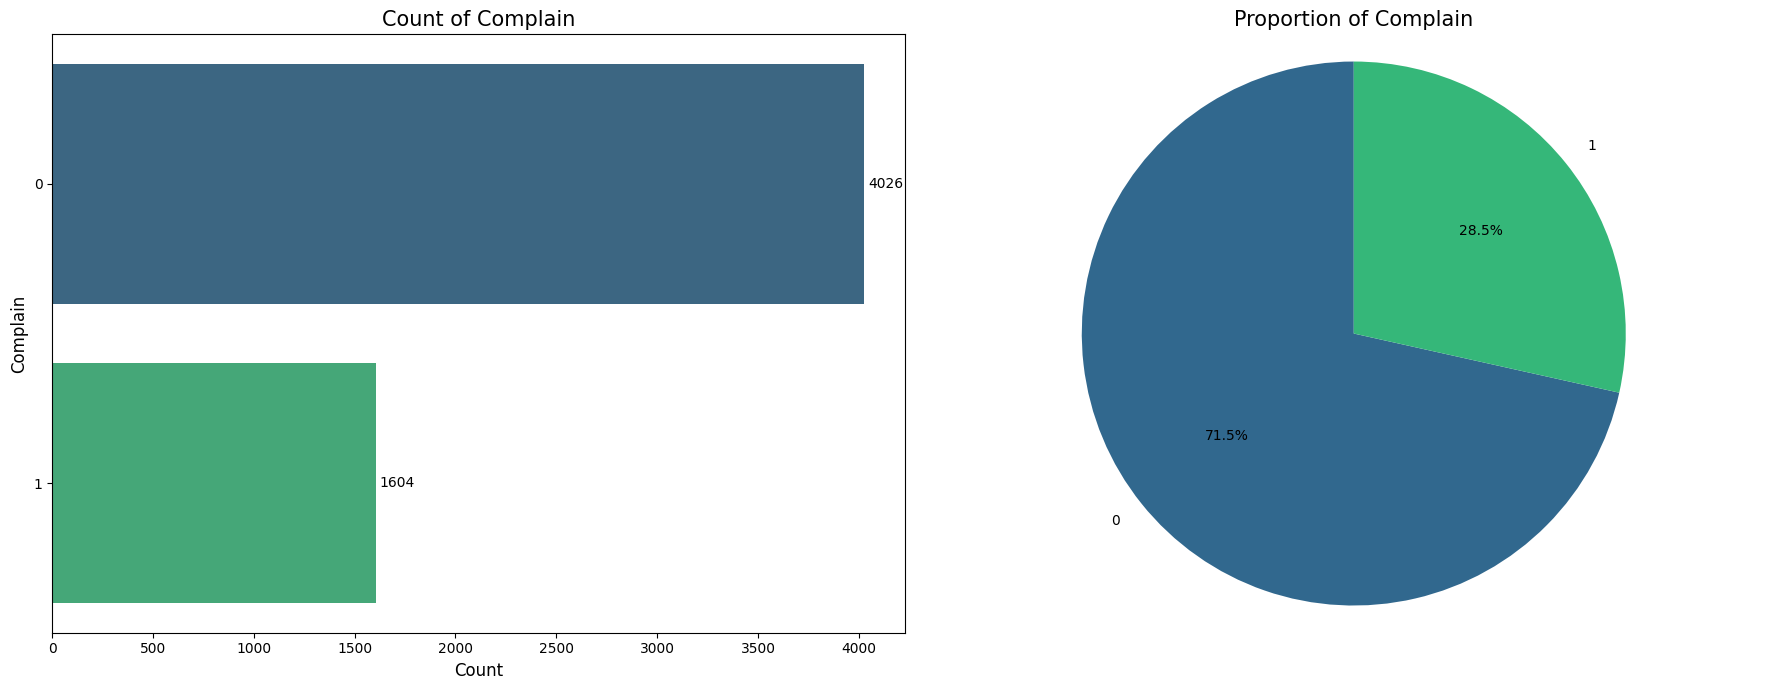

In [39]:
analyze_univariate_categorical(df_ecommerce, ['Complain'])

- **71% have not complained**, but **29% have**.

➡️ A relatively high complaint rate

### 3.6.2. Bivariate

In [40]:
def analyze_bivariate_categorical(df_ecommerce, all_categorical):
    """
    Performs bivariate analysis between categorical features and the 'Churn' target.
    
    For each categorical column, it generates:
    - A stacked bar chart showing the proportion of Churn for each category.
    - A countplot showing the absolute counts of Churn and No Churn for each category.
    - A Chi-squared test to determine if there is a statistically significant association.

    Parameters:
    - df_ecommerce (pd.DataFrame): The input DataFrame containing the features and 'Churn' column.
    - all_categorical (list): A list of categorical column names to analyze.
    """
    # Label + color mapping (don’t modify df, just for plotting)
    label_map = {0: "No Churn", 1: "Churn"}
    complain_map = {0: "No", 1: "Yes"}
    
    # Flexible palette: works with both raw and mapped values
    palette = {
        0: "#42a5f5",   # No Churn (numeric)
        1: "#ef5350",   # Churn (numeric)
        "No": "#42a5f5",
        "Yes": "#ef5350",
        "No Churn": "#42a5f5",
        "Churn": "#ef5350"
    }

    for col in all_categorical:
        print(f'\nAnalyzing Bivariate Feature: {col} vs. Churn')

        # If column is Complain, create a copy with mapped labels
        if col == "Complain":
            df_plot = df_ecommerce.copy()
            df_plot[col] = df_plot[col].map(complain_map)
        else:
            df_plot = df_ecommerce

        # --- Proportion table ---
        churn_proportion = (
            df_plot.groupby(col)['Churn']
            .value_counts(normalize=True)
            .unstack()
            .fillna(0)
        )

        # Rename columns just for plotting
        churn_proportion = churn_proportion.rename(columns=label_map)

        # Ensure both churn categories exist
        for cat in ["Churn", "No Churn"]:
            if cat not in churn_proportion.columns:
                churn_proportion[cat] = 0

        # Reorder so Churn is bottom
        churn_proportion = churn_proportion[["Churn", "No Churn"]]

        # Sort by churn rate
        churn_proportion = churn_proportion.sort_values(by="Churn", ascending=False)

        # --- Subplots ---
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # --- 1. Stacked bar (proportions) ---
        churn_proportion.plot(
            kind="bar",
            stacked=True,
            color=[palette["Churn"], palette["No Churn"]],
            ax=axes[0]
        )

        axes[0].set_title(f'Proportion of Churn by {col}', fontsize=14)
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel('Proportion (%)', fontsize=12)
        axes[0].set_ylim(0, 1)
        axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])
        axes[0].legend(title='Churn', labels=["Churn", "No Churn"])

        # Add percentage labels
        for container in axes[0].containers:
            labels = [f'{v.get_height():.0%}' if v.get_height() > 0 else '' for v in container]
            axes[0].bar_label(container, labels=labels, label_type='center', fontsize=9)

        # --- 2. Countplot (sorted by churn count) ---
        churn_counts = (
            df_plot.groupby(col)["Churn"]
            .value_counts()
            .unstack(fill_value=0)
        )

        # Sort categories by descending churn count
        order_by_churn = churn_counts.sort_values(1, ascending=False).index

        ax = sns.countplot(
            data=df_plot,
            x=col,
            hue="Churn",
            order=order_by_churn,
            palette=palette,
            ax=axes[1]
        )

        # Fix legend labels
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [label_map.get(int(lbl), lbl) for lbl in labels]
        ax.legend(handles, new_labels, title="Churn")

        ax.set_title(f"Count of {col} by Churn", fontsize=14)
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)
        ax.tick_params(axis="x", rotation=45)

        # Add count labels
        for container in ax.containers:
            ax.bar_label(container, fmt="%d", fontsize=9)

        plt.tight_layout()
        plt.show()

        # Chi-squared Test for Association
        contingency_table = pd.crosstab(df_ecommerce[col], df_ecommerce['Churn'])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        
        print(f'Chi-squared Test for {col}: Chi2-statistic={chi2:.3f}, p-value={p:.3f}')
        
        if p < 0.05:
            print(f'Conclusion: There is a statistically significant association between {col} and Churn.')
        else:
            print(f'Conclusion: There is no statistically significant association between {col} and Churn.')
            
        print("-" * 50)

#### PreferredLoginDevice


Analyzing Bivariate Feature: PreferredLoginDevice vs. Churn


/tmp/ipykernel_11038/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


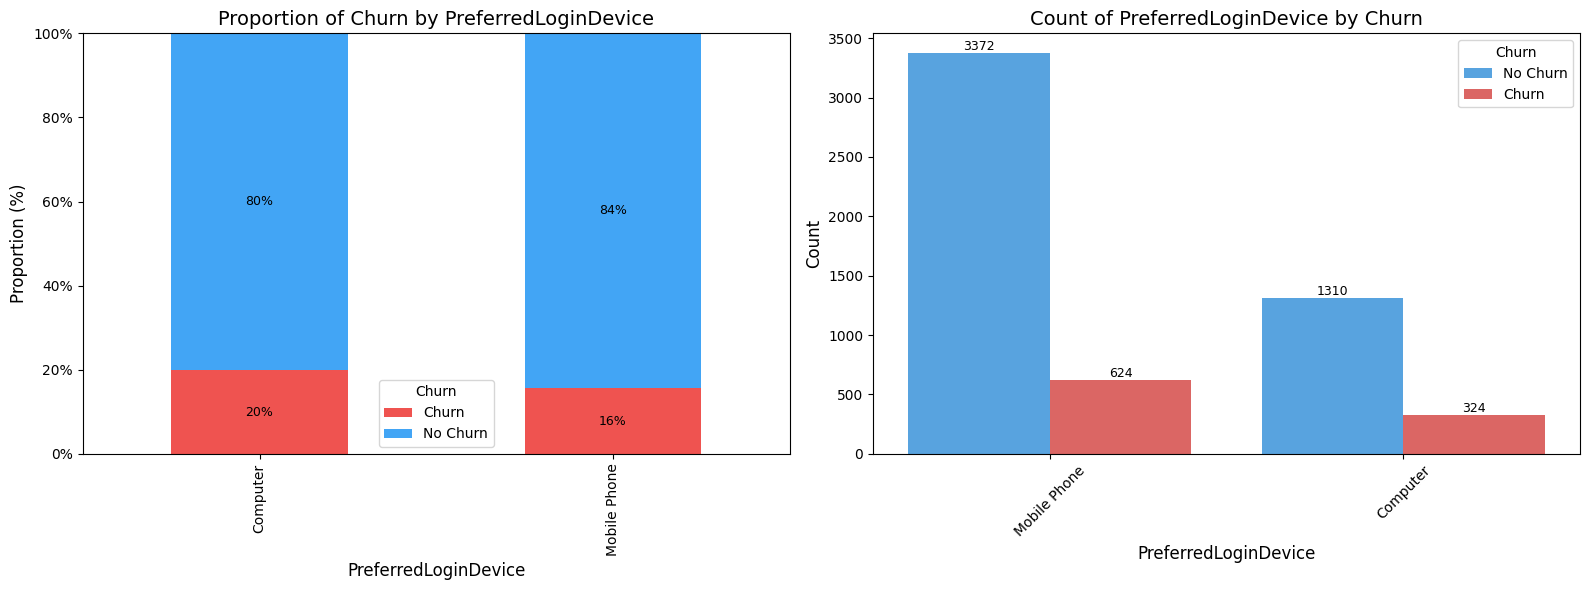

Chi-squared Test for PreferredLoginDevice: Chi2-statistic=14.401, p-value=0.000
Conclusion: There is a statistically significant association between PreferredLoginDevice and Churn.
--------------------------------------------------


In [41]:
analyze_bivariate_categorical(df_ecommerce, ['PreferredLoginDevice'])

Customers who prefer to use a "Computer" to log in have a higher churn rate (**19.8%**) than those who use a "Mobile Phone" (**15.6%**).

#### PreferredPaymentMode


Analyzing Bivariate Feature: PreferredPaymentMode vs. Churn


/tmp/ipykernel_11038/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


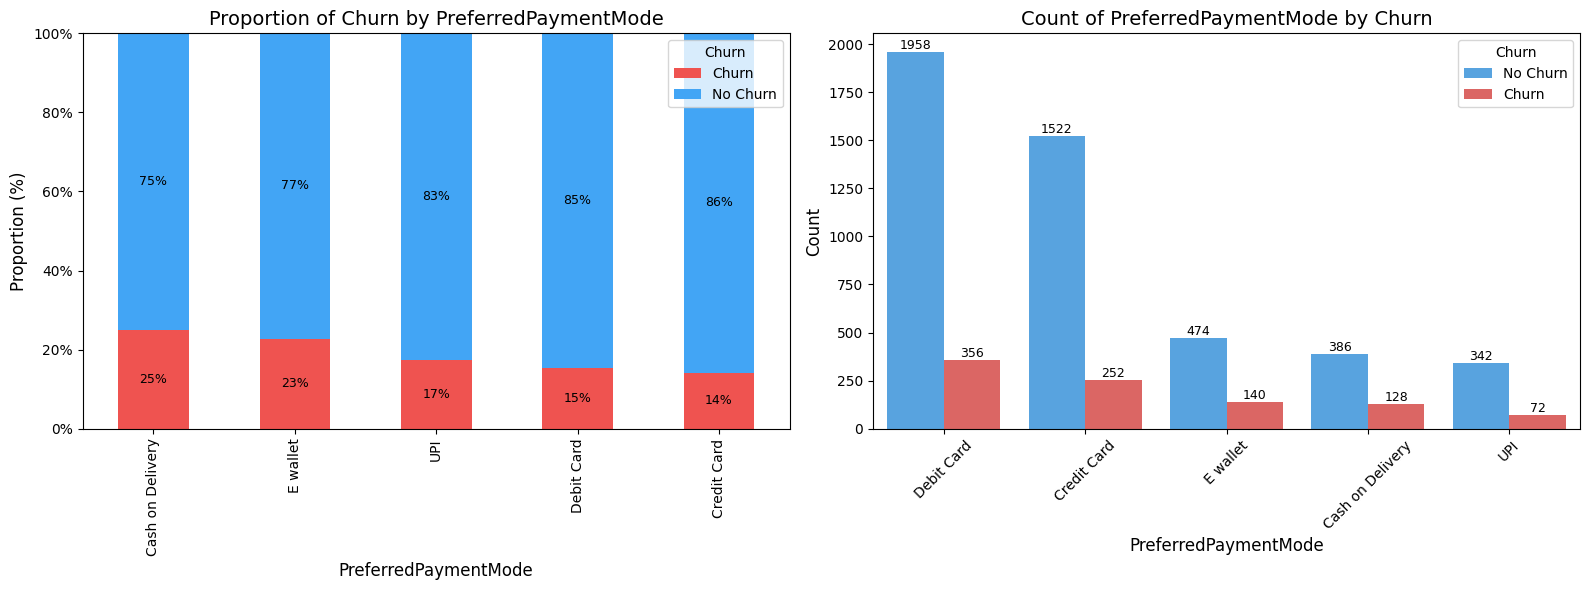

Chi-squared Test for PreferredPaymentMode: Chi2-statistic=51.829, p-value=0.000
Conclusion: There is a statistically significant association between PreferredPaymentMode and Churn.
--------------------------------------------------


In [42]:
analyze_bivariate_categorical(df_ecommerce, ['PreferredPaymentMode'])

"Cash on Delivery" has the highest churn rate at **24.9%**. This is a potential red flag, as it's the only payment method with a churn rate over 20%. Other methods like Credit Card, Debit Card, E-wallet, and UPI have lower, more consistent churn rates.

#### Gender


Analyzing Bivariate Feature: Gender vs. Churn


/tmp/ipykernel_11038/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


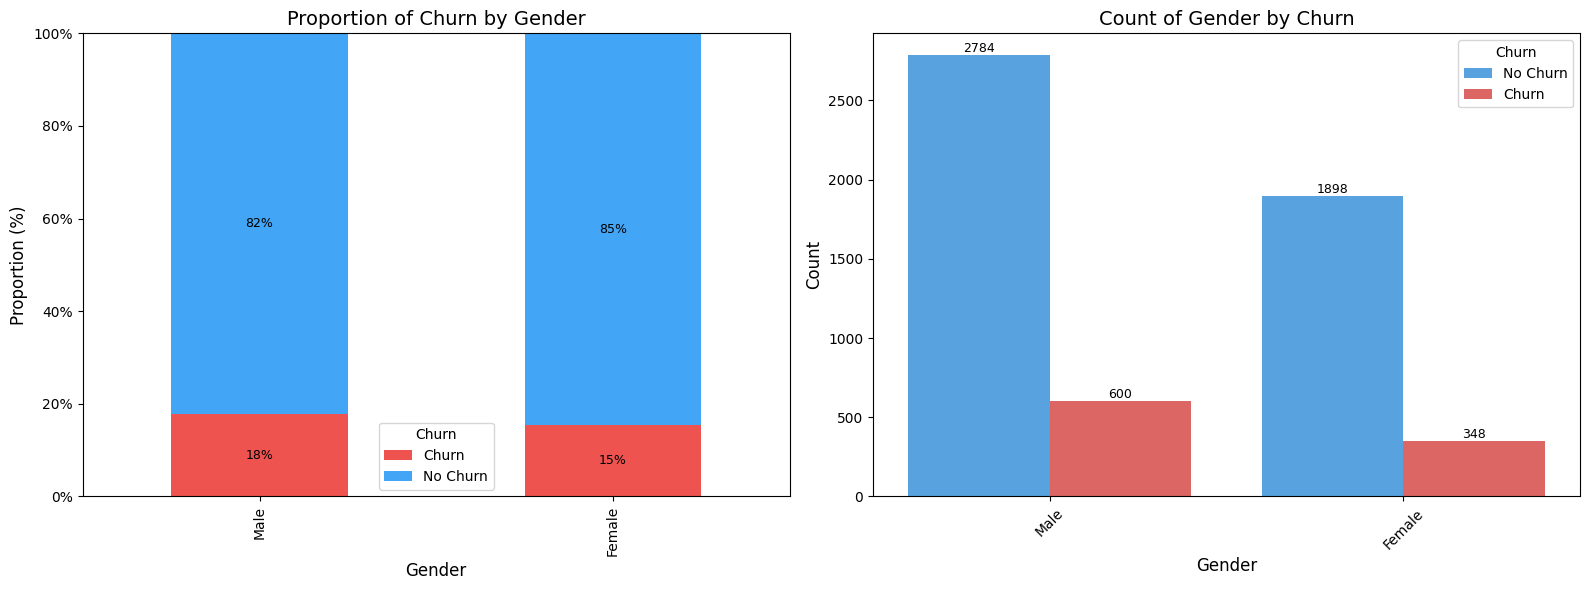

Chi-squared Test for Gender: Chi2-statistic=4.663, p-value=0.031
Conclusion: There is a statistically significant association between Gender and Churn.
--------------------------------------------------


In [43]:
analyze_bivariate_categorical(df_ecommerce, ['Gender'])

Churn rates are similar across genders, with females at **15.5%** and males at **17.7%**. This suggests that gender is not a major factor in predicting churn.

#### PreferedOrderCat


Analyzing Bivariate Feature: PreferedOrderCat vs. Churn


/tmp/ipykernel_11038/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


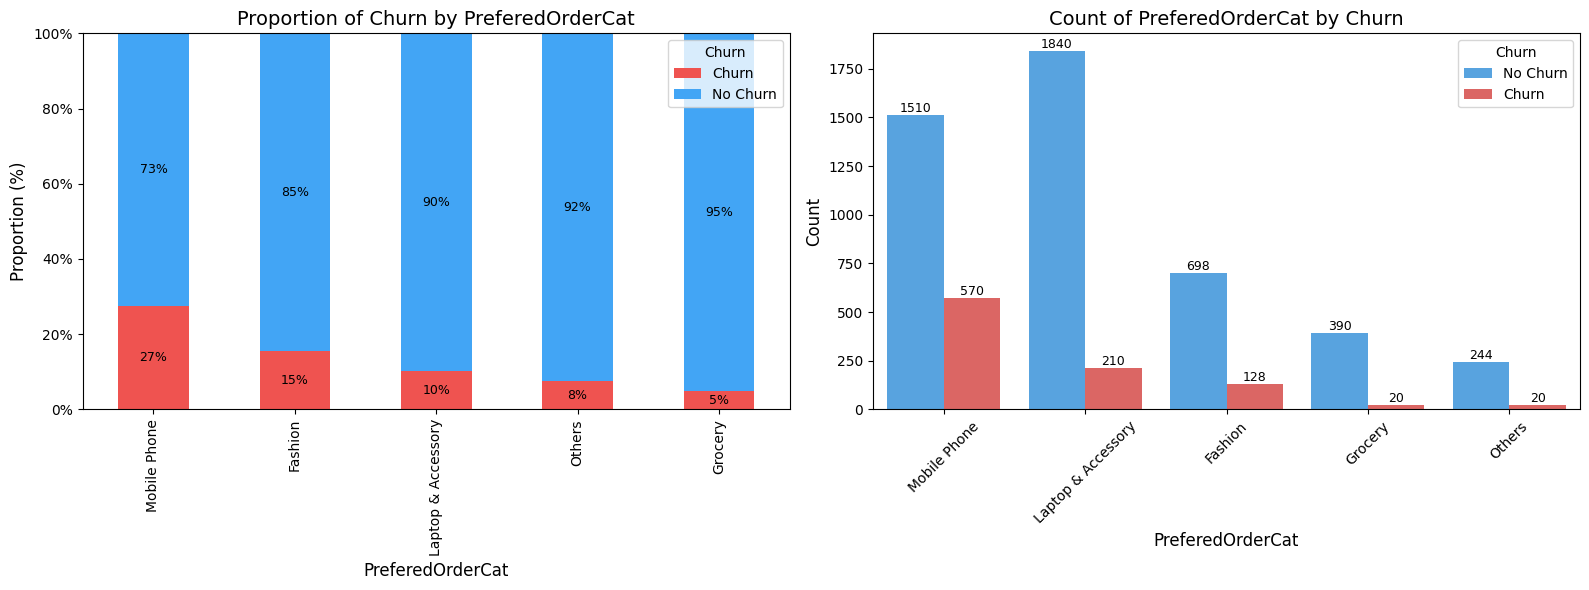

Chi-squared Test for PreferedOrderCat: Chi2-statistic=288.598, p-value=0.000
Conclusion: There is a statistically significant association between PreferedOrderCat and Churn.
--------------------------------------------------


In [44]:
analyze_bivariate_categorical(df_ecommerce, ['PreferedOrderCat'])

"Mobile Phone" orders have a very high churn rate of **27.4%**, which is significantly higher than any other category. "Grocery" orders have the lowest churn rate at **4.9%**.

#### MaritalStatus


Analyzing Bivariate Feature: MaritalStatus vs. Churn


/tmp/ipykernel_11038/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


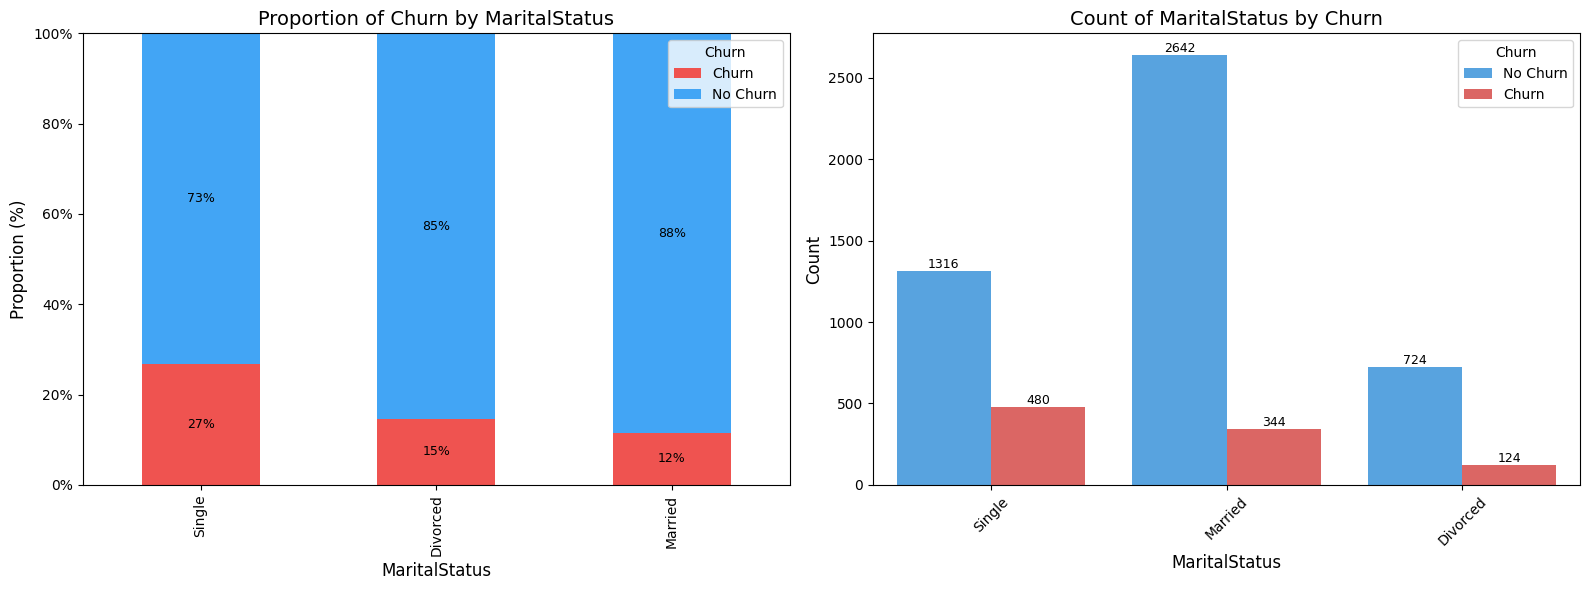

Chi-squared Test for MaritalStatus: Chi2-statistic=188.671, p-value=0.000
Conclusion: There is a statistically significant association between MaritalStatus and Churn.
--------------------------------------------------


In [45]:
analyze_bivariate_categorical(df_ecommerce, ['MaritalStatus'])

Single customers have the highest churn rate at **26.7%**, significantly higher than divorced (**14.6%**) or married (**11.5%**) customers.

#### CityTier


Analyzing Bivariate Feature: CityTier vs. Churn


/tmp/ipykernel_11038/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


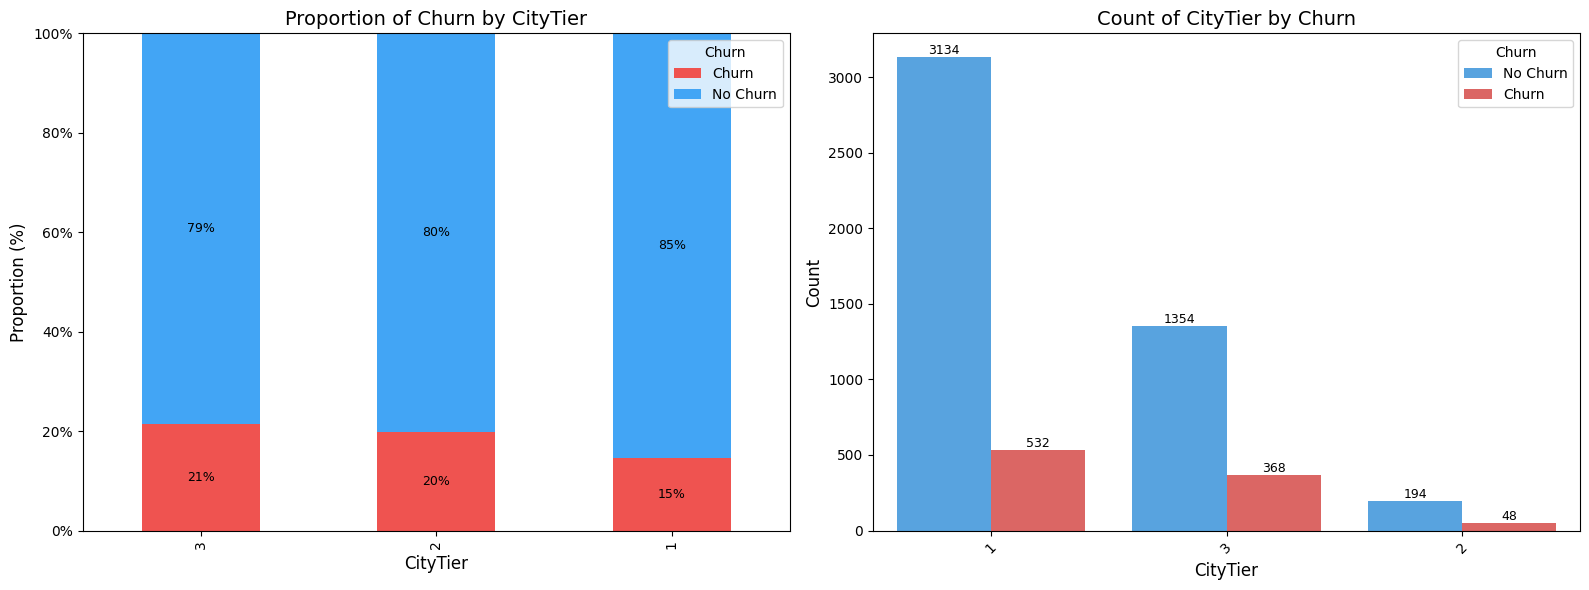

Chi-squared Test for CityTier: Chi2-statistic=40.982, p-value=0.000
Conclusion: There is a statistically significant association between CityTier and Churn.
--------------------------------------------------


In [46]:
analyze_bivariate_categorical(df_ecommerce, ['CityTier'])

Churn rates increase as the city tier number increases. Tier 1 cities have a churn rate of **14.5%**, Tier 2 at **19.8%**, and Tier 3 at **21.4%**.

#### SatisfactionScore


Analyzing Bivariate Feature: SatisfactionScore vs. Churn


/tmp/ipykernel_11038/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


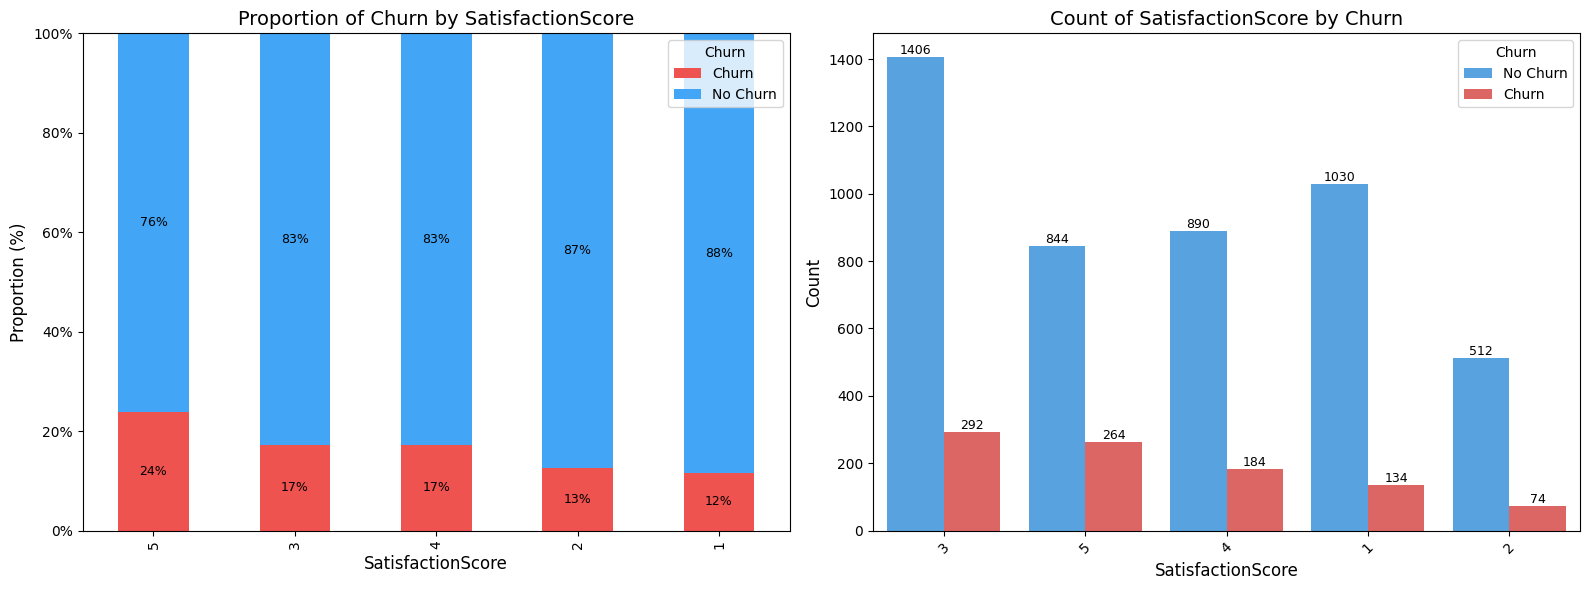

Chi-squared Test for SatisfactionScore: Chi2-statistic=69.865, p-value=0.000
Conclusion: There is a statistically significant association between SatisfactionScore and Churn.
--------------------------------------------------


In [47]:
analyze_bivariate_categorical(df_ecommerce, ['SatisfactionScore'])

There's a clear inverse relationship between satisfaction and churn. Customers with the lowest satisfaction score (1) have a churn rate of **11.5%**, while those with the highest score (5) have the highest churn rate at **23.8%**. This seemingly counterintuitive finding warrants further investigation as it is unclear the basis of scoring and may indicate that customers who are highly satisfied and then churn are doing so for reasons unrelated to satisfaction with the product/service itsel.

#### Complain


Analyzing Bivariate Feature: Complain vs. Churn


/tmp/ipykernel_11038/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


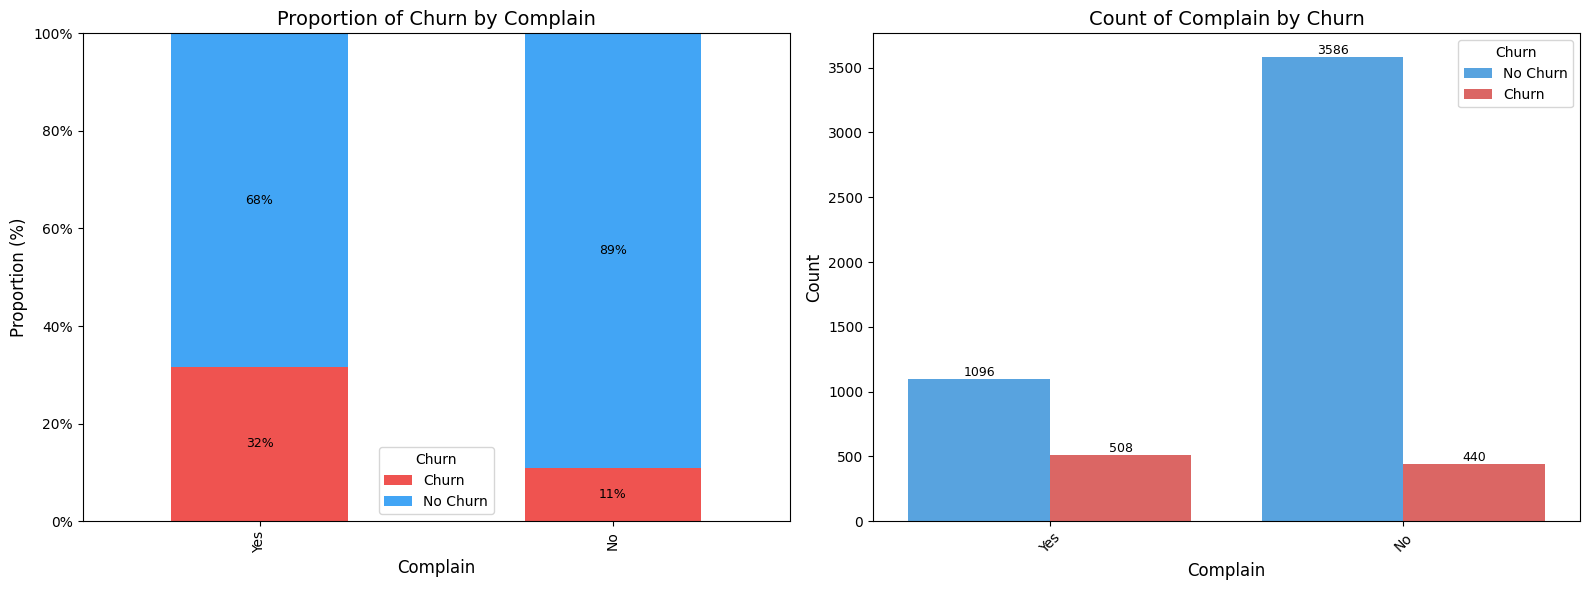

Chi-squared Test for Complain: Chi2-statistic=350.925, p-value=0.000
Conclusion: There is a statistically significant association between Complain and Churn.
--------------------------------------------------


In [48]:
analyze_bivariate_categorical(df_ecommerce, ['Complain'])

A strong correlation exists between complaints and churn. Customers who complained (**31.7%**) are much more likely to churn compared to those who didn't (**10.9%**).

## 3.7. Missing Values Analysis

--- Starting Missing Values Analysis (Iterative by Feature) ---

Overall Missing values by column:
                             Total Missing  Percentage (%)
DaySinceLastOrder                      307        5.452931
OrderAmountHikeFromlastYear            265        4.706927
Tenure                                 264        4.689165
OrderCount                             258        4.582593
CouponUsed                             256        4.547069
HourSpendOnApp                         255        4.529307
WarehouseToHome                        251        4.458259


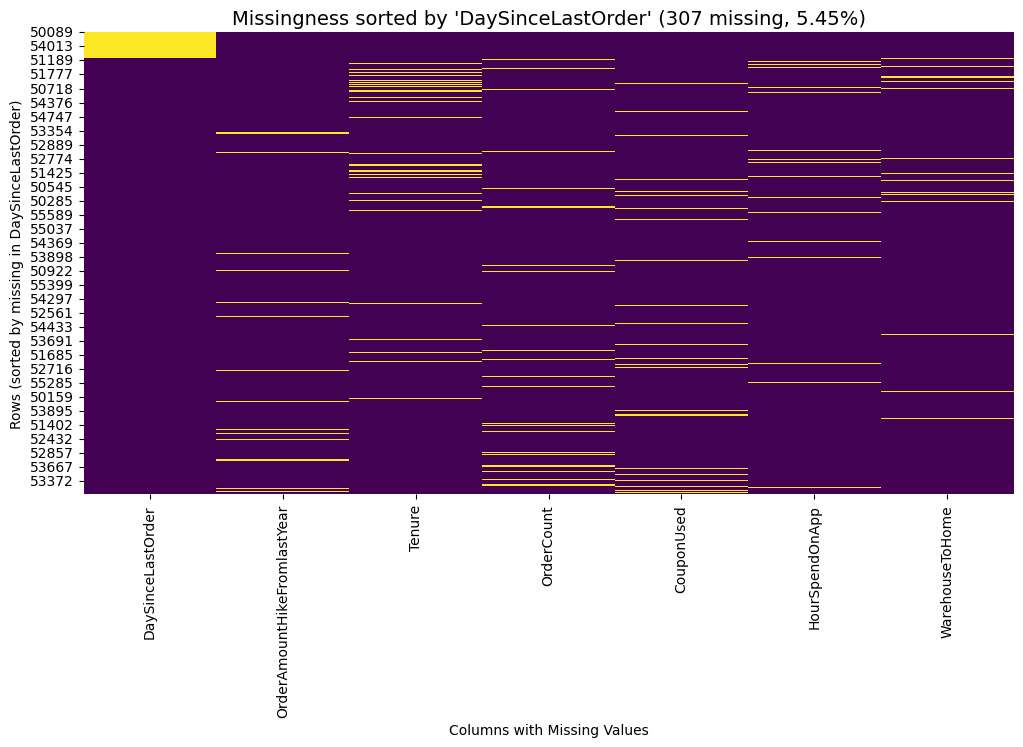

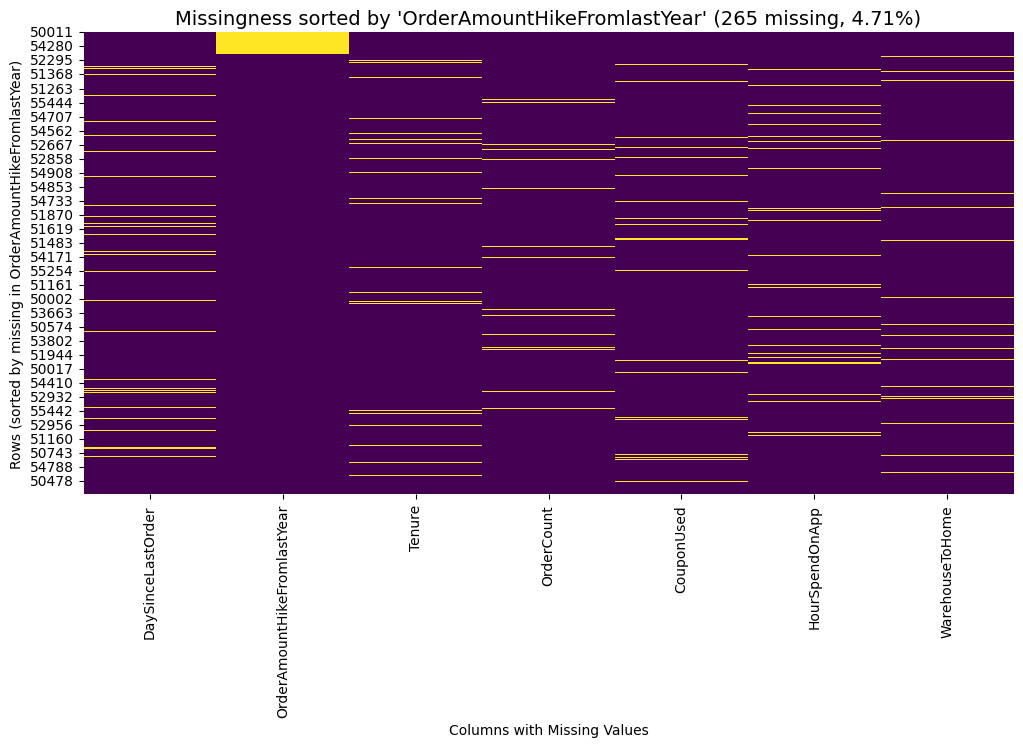

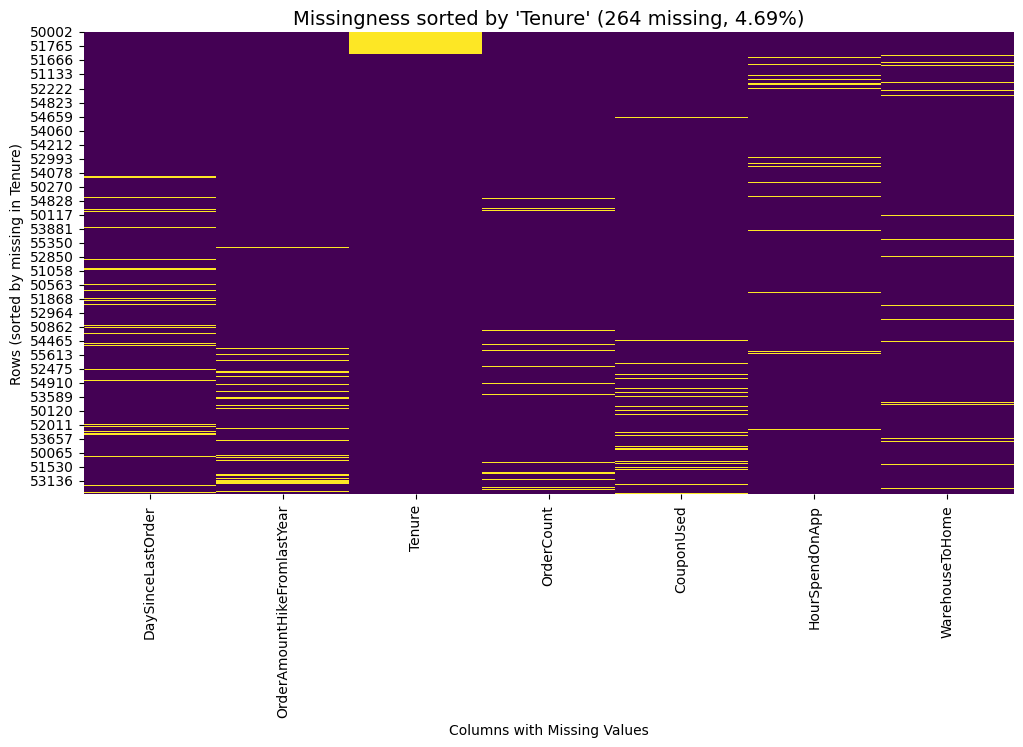

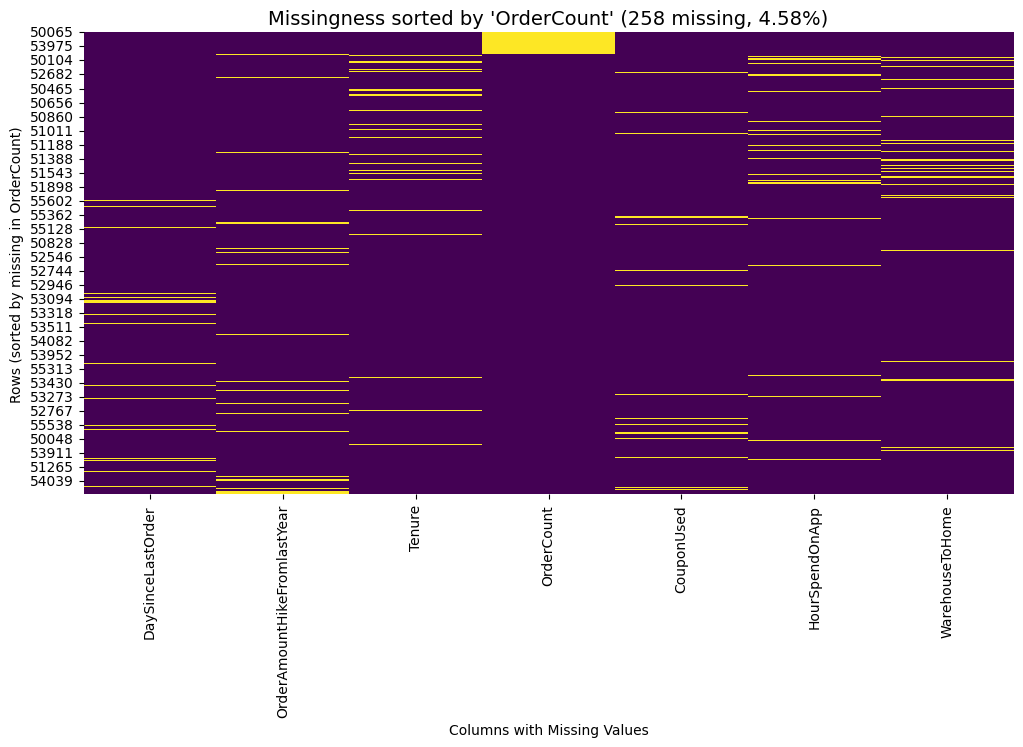

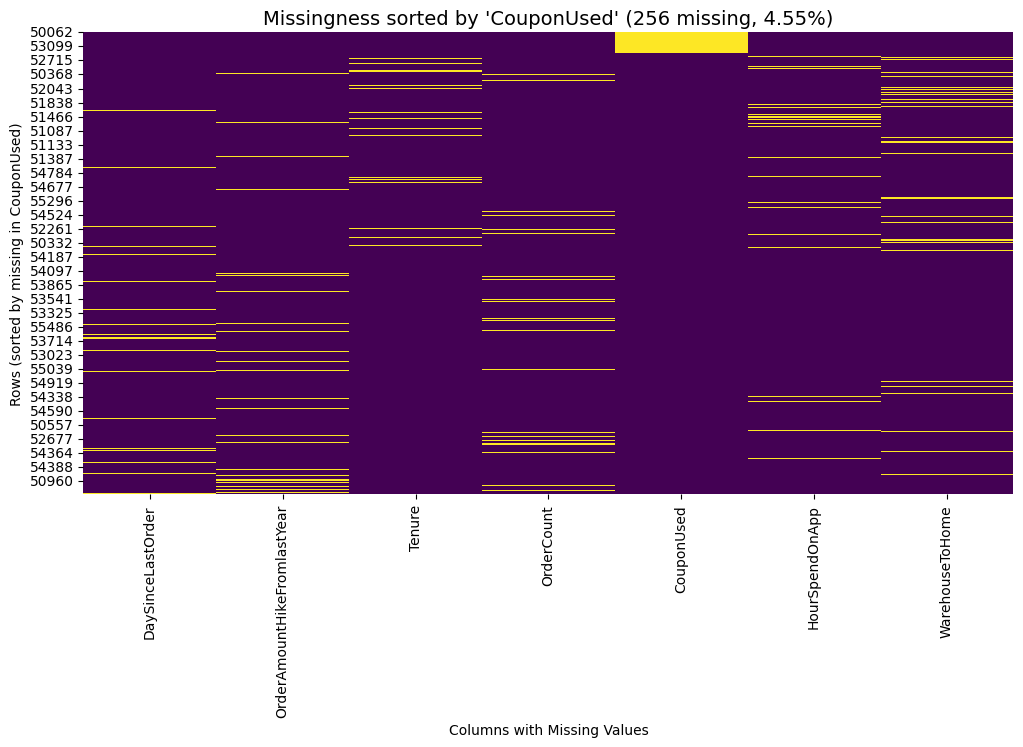

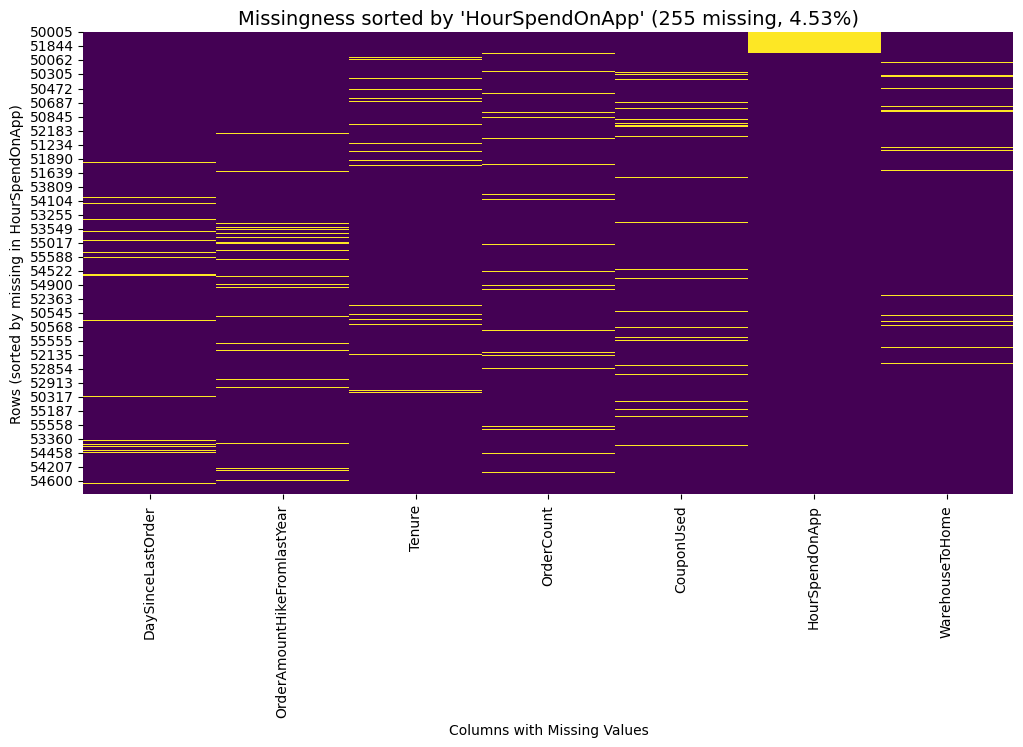

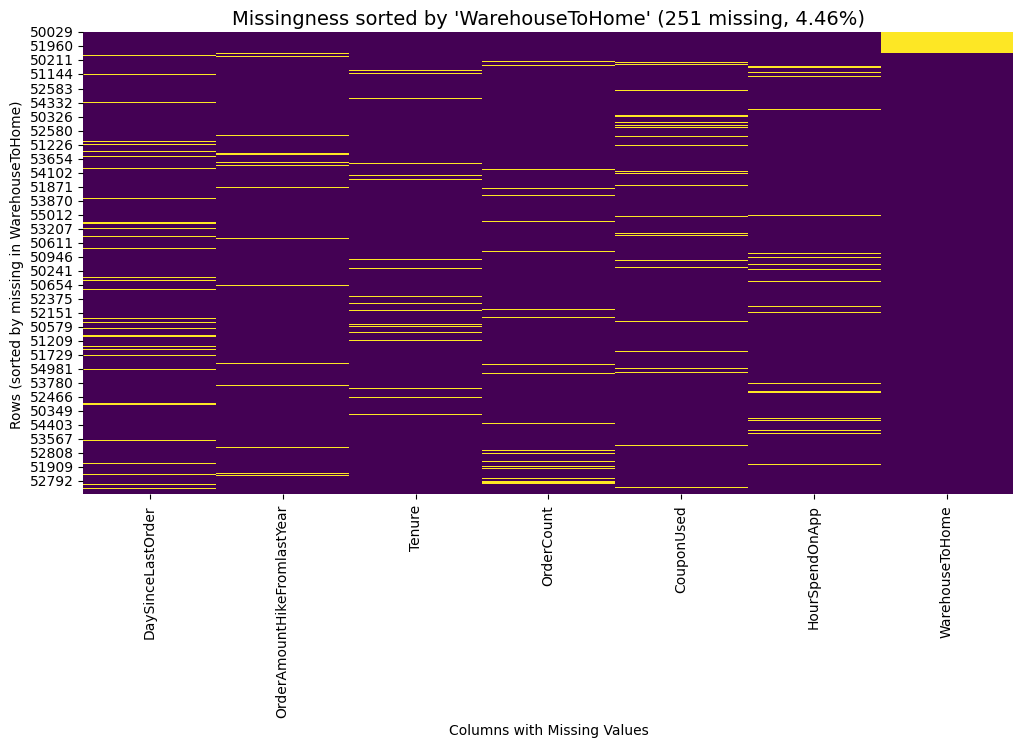

--------------------------------------------------


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Missing Values Analysis (Iterative by Feature) ---")

# Overall Missing Values
missing_data = df_ecommerce.isnull().sum()
total_rows = len(df_ecommerce)

missing_df = pd.DataFrame({
    'Total Missing': missing_data,
    'Percentage (%)': (missing_data / total_rows) * 100
}).sort_values(by='Total Missing', ascending=False)

columns_with_missing_data = missing_df[missing_df['Total Missing'] > 0]

print("\nOverall Missing values by column:")
print(columns_with_missing_data)

# --- Iterative heatmaps sorted by each missing column ---
if not columns_with_missing_data.empty:
    for col in columns_with_missing_data.index:
        # Sort rows so NaNs in `col` appear grouped together
        sorted_df = df_ecommerce.sort_values(by=col, na_position="first")

        plt.figure(figsize=(12, 6))
        sns.heatmap(
            sorted_df[columns_with_missing_data.index].isnull(),
            cbar=False, cmap="viridis"
        )
        plt.title(
            f"Missingness sorted by '{col}' "
            f"({missing_df.loc[col, 'Total Missing']} missing, "
            f"{missing_df.loc[col, 'Percentage (%)']:.2f}%)",
            fontsize=14
        )
        plt.xlabel("Columns with Missing Values")
        plt.ylabel("Rows (sorted by missing in " + col + ")")
        plt.show()

print("-" * 50)


Seems no correlation between missing values features

## 3.8. Multicollinearity and Correlation

--- Correlation Analysis (Spearman Method) ---


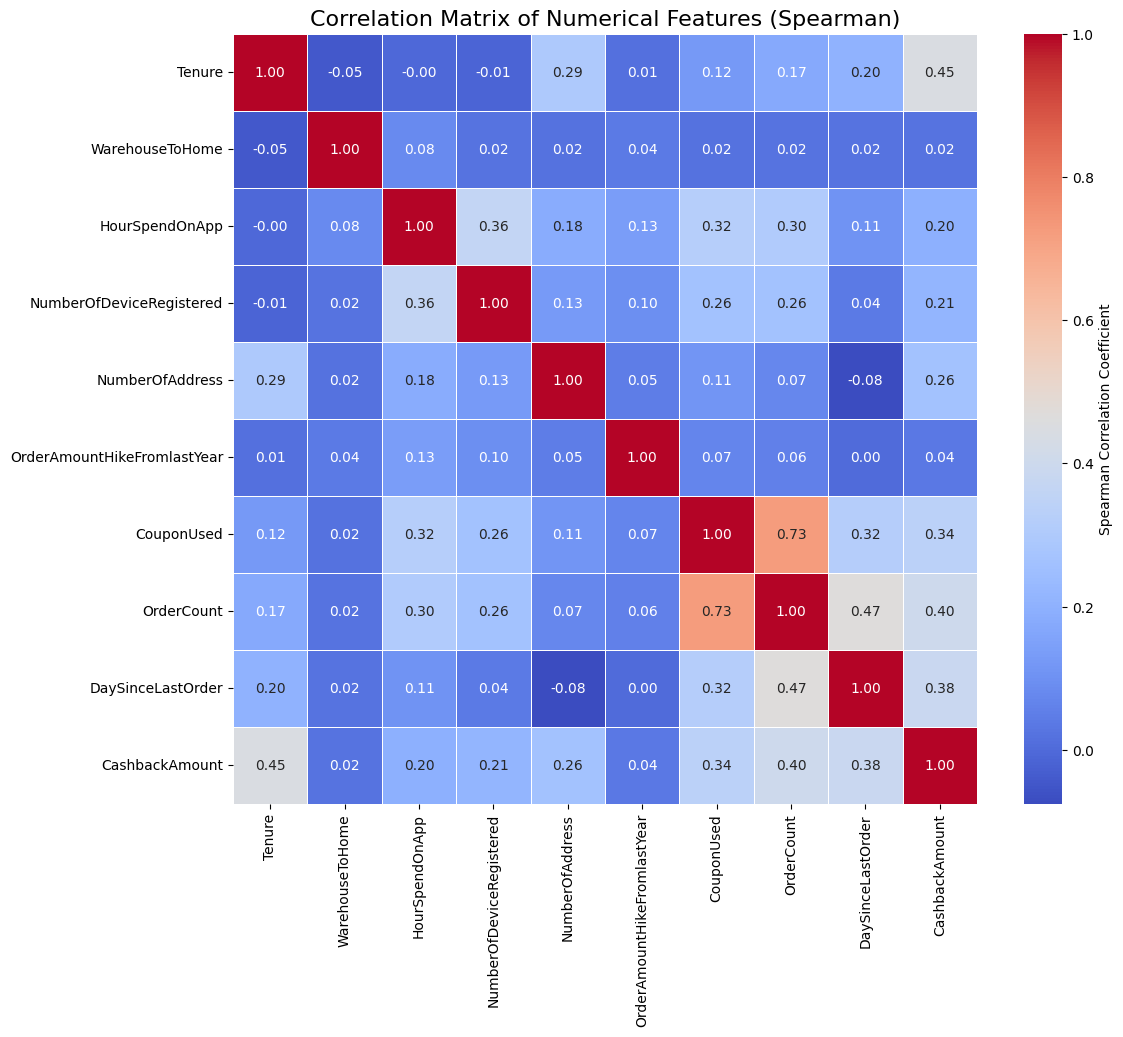

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# We will use only the numerical features for this analysis
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# --- Correlation Matrix and Heatmap ---
print("--- Correlation Analysis (Spearman Method) ---")

# Calculate the correlation matrix using the Spearman method
corr_matrix = df_ecommerce[numerical_features].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Spearman Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features (Spearman)', fontsize=16)
plt.show()

### Analysis of Numerical Features and Multicollinearity

Based on the provided correlation matrix, here are the key insights.

-----

### Feature Correlations (Spearman)

The correlation matrix shows the relationships between pairs of numerical features.

  * **Moderate Positive Correlations**:
      * **OrderCount and CouponUsed (0.73)**: Customers who place more orders tend to use more coupons.
      * **DaysSinceLastOrder and OrderCount (0.47)**: This is an interesting inverse relationship. The correlation is moderate, but it suggests that as the number of orders increases, the days since the last order might also increase, or vice-versa.
      * **Tenure and CashbackAmount (0.45)**: Customers who have been with the company longer tend to receive more cashback.
  * **Weak Correlations**: Most other feature pairs show very weak correlations (values close to 0), indicating they have minimal linear relationship with each other. For example, **HoursSpendOnApp** has a very low correlation with all other features.

## 3.9. Save Dataset

In [ ]:
# df_ecommerce.to_csv('eda.csv')

# 4. Preprocessing

In [15]:
# --- Global variable for reproducibility ---
RANDOM_STATE = 42

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, f_classif
from collections import Counter
import joblib

# --- 1. Load the dataset ---
try:
    df = pd.read_csv('eda.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'eda.csv' not found. Please check the file path.")
    exit()

# --- 2. Define features and target ---
TARGET = 'Churn'

# CustomerID is not used as features
df.set_index('CustomerID', inplace=True)

ordinal_features = ['CityTier', 'SatisfactionScore']
numerical_features = [
    'Tenure', 'WarehouseToHome', 'HourSpendOnApp',
    'NumberOfDeviceRegistered', 'NumberOfAddress',
    'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
    'DaySinceLastOrder', 'CashbackAmount'
]
categorical_features = [
    'PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice',
    'PreferredPaymentMode', 'Gender', 'Complain'
]

# Separate target variable
X = df.drop(columns=[TARGET])
y = df[TARGET]

# --- 3. Split the data to prevent data leakage ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Original data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"\nOriginal Churn distribution: {Counter(y)}")
print(f"Training Churn distribution: {Counter(y_train)}")

# --- 4. Define Preprocessing Pipelines ---
# A. Numerical Preprocessor
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# B. Nominal Categorical Preprocessor (One-Hot Encoding)
nominal_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# C. Ordinal Categorical Preprocessor (Ordinal Encoding)
ordinal_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# D. Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features),
        ('nominal_cat', nominal_preprocessor, categorical_features),
        ('ordinal_cat', ordinal_preprocessor, ordinal_features)
    ],
    remainder='passthrough'
)

# --- 5. Build Feature Selection Pipelines ---
percentiles = [50, 60, 70, 80, 90, 100]
pipelines = {}

for p in percentiles:
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('select', SelectPercentile(score_func=f_classif, percentile=p))
    ])
    pipelines[f'pipeline_fs_{p}'] = pipe

# --- 6. Save Pipelines ---
for name, pipe in pipelines.items():
    joblib.dump(pipe, f'{name}.pkl')

print("\n✅ Feature selection pipelines saved:")
for p in percentiles:
    print(f"- pipeline_fs_{p}.pkl")

Dataset loaded successfully.
Original data shape: (5630, 18)
Training data shape: (4504, 18)
Testing data shape: (1126, 18)

Original Churn distribution: Counter({0: 4682, 1: 948})
Training Churn distribution: Counter({0: 3746, 1: 758})

✅ Feature selection pipelines saved:
- pipeline_fs_50.pkl
- pipeline_fs_60.pkl
- pipeline_fs_70.pkl
- pipeline_fs_80.pkl
- pipeline_fs_90.pkl
- pipeline_fs_100.pkl


In [21]:
# If X_test is still a DataFrame after preprocessing
test_df = X_test.copy()
test_df['Churn'] = y_test.values

# If X_test is a NumPy array after preprocessing
# you’ll need to bring back the feature names
if not isinstance(X_test, pd.DataFrame):
    feature_names = preprocessor.get_feature_names_out()
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['Churn'] = y_test.values

# Save to CSV for inspection or later use
test_df.to_csv("test_set.csv")

print("Test set saved successfully with shape:", test_df.shape)

Test set saved successfully with shape: (1126, 19)


# 5. Methodology (Modeling/Analysis)

## 5.1. Benchmark Model

FS_50 | LogisticRegression CV F2: 0.4843 ± 0.0405
FS_50 | LogisticRegression uses 15 features
FS_50 | KNeighborsClassifier CV F2: 0.5068 ± 0.0416
FS_50 | KNeighborsClassifier uses 15 features
FS_50 | DecisionTreeClassifier CV F2: 0.7835 ± 0.0268
FS_50 | DecisionTreeClassifier uses 15 features
FS_50 | RandomForestClassifier CV F2: 0.7513 ± 0.0242
FS_50 | RandomForestClassifier uses 15 features


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

FS_50 | XGBClassifier CV F2: 0.7941 ± 0.0350
FS_50 | XGBClassifier uses 15 features

--- FS_50 Train vs Test Results ---
                 Model  Features Used  Train F2  Test F2  Train ROC-AUC  Test ROC-AUC  Train Precision  Test Precision  Train Recall  Test Recall
         XGBClassifier             15  0.995511 0.900853       0.999990      0.992898         0.998675        0.949438      0.994723     0.889474
DecisionTreeClassifier             15  1.000000 0.897167       1.000000      0.938248         1.000000        0.886010      1.000000     0.900000
RandomForestClassifier             15  1.000000 0.884861       1.000000      0.994349         1.000000        0.932584      1.000000     0.873684
  KNeighborsClassifier             15  0.725740 0.567297       0.976393      0.926479         0.897436        0.733813      0.692612     0.536842
    LogisticRegression             15  0.490280 0.503964       0.875437      0.855741         0.736052        0.723577      0.452507     0.468421


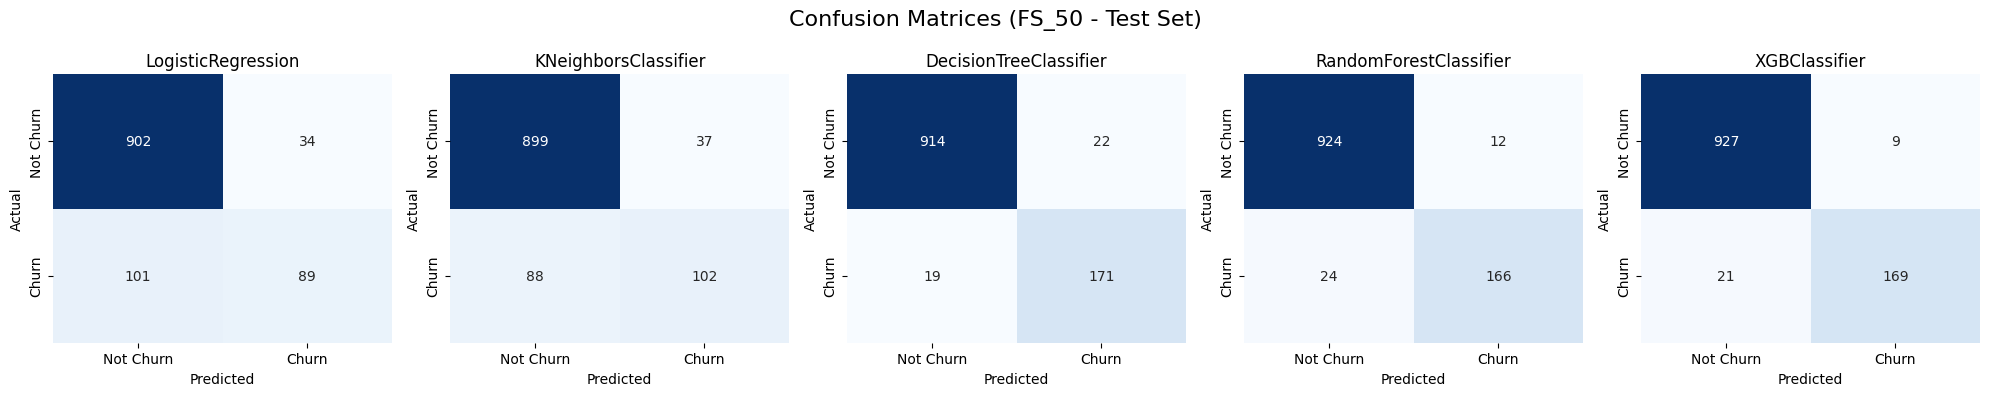

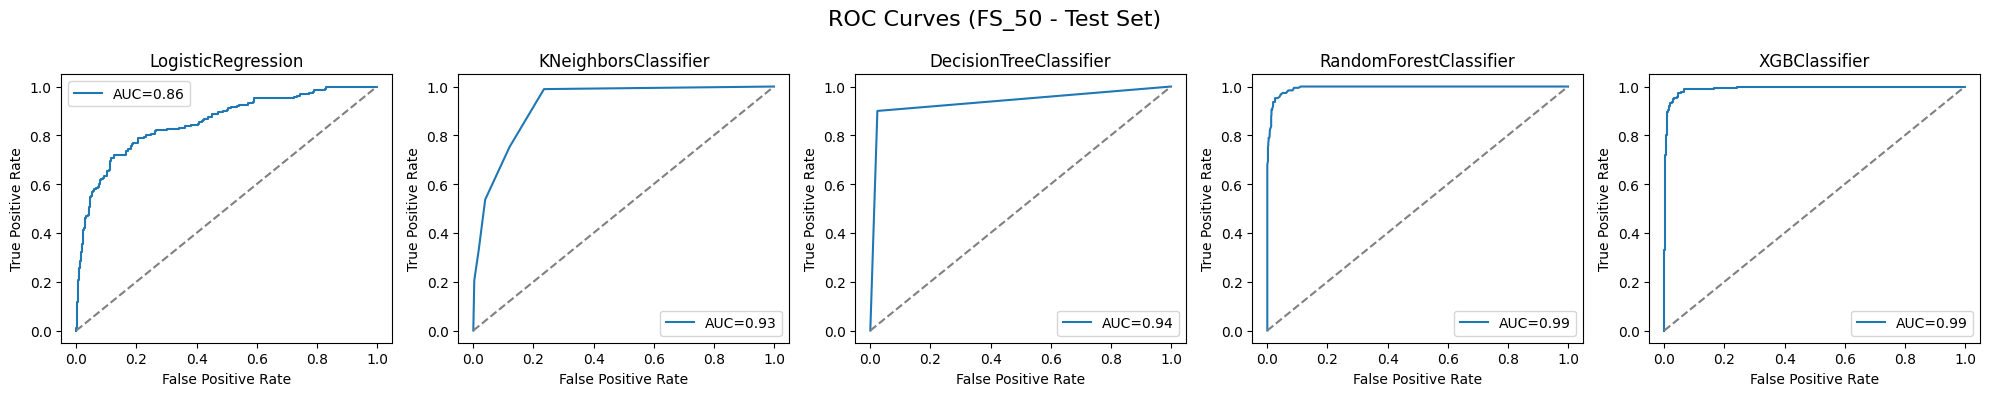

FS_60 | LogisticRegression CV F2: 0.4782 ± 0.0604
FS_60 | LogisticRegression uses 18 features
FS_60 | KNeighborsClassifier CV F2: 0.5269 ± 0.0424
FS_60 | KNeighborsClassifier uses 18 features
FS_60 | DecisionTreeClassifier CV F2: 0.8120 ± 0.0159
FS_60 | DecisionTreeClassifier uses 18 features
FS_60 | RandomForestClassifier CV F2: 0.7944 ± 0.0165
FS_60 | RandomForestClassifier uses 18 features


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

FS_60 | XGBClassifier CV F2: 0.8162 ± 0.0289
FS_60 | XGBClassifier uses 18 features

--- FS_60 Train vs Test Results ---
                 Model  Features Used  Train F2  Test F2  Train ROC-AUC  Test ROC-AUC  Train Precision  Test Precision  Train Recall  Test Recall
         XGBClassifier             18  0.998681 0.920635       0.999996      0.993601         0.998681        0.940541      0.998681     0.915789
DecisionTreeClassifier             18  1.000000 0.901468       1.000000      0.940879         1.000000        0.886598      1.000000     0.905263
RandomForestClassifier             18  1.000000 0.877944       1.000000      0.994149         1.000000        0.942529      1.000000     0.863158
  KNeighborsClassifier             18  0.767429 0.591518       0.983836      0.935299         0.932998        0.779412      0.734828     0.557895
    LogisticRegression             18  0.491569 0.515289       0.878270      0.862702         0.736617        0.739837      0.453826     0.478947


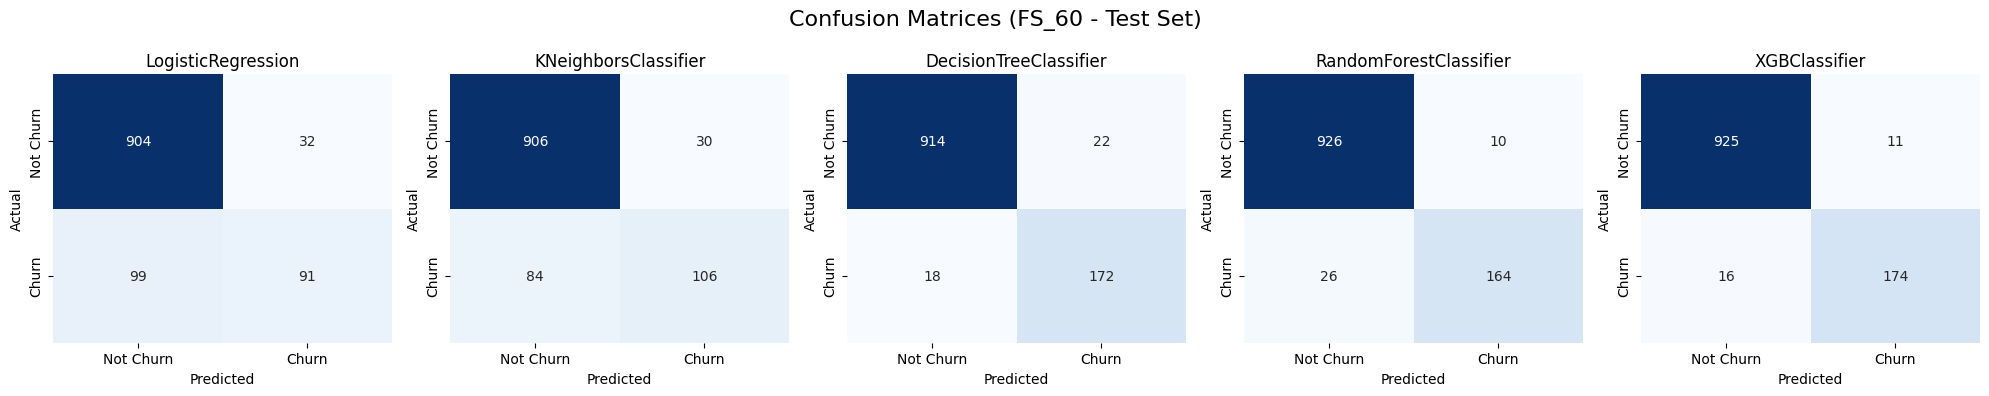

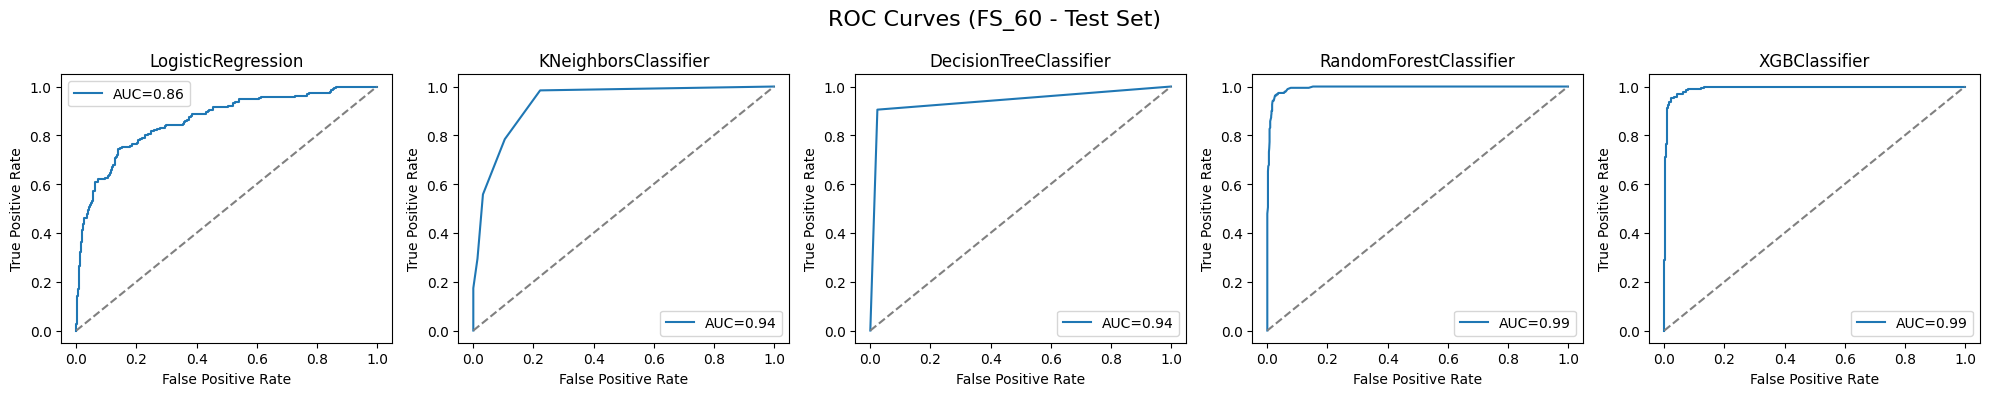

FS_70 | LogisticRegression CV F2: 0.5374 ± 0.0350
FS_70 | LogisticRegression uses 21 features
FS_70 | KNeighborsClassifier CV F2: 0.5825 ± 0.0456
FS_70 | KNeighborsClassifier uses 21 features
FS_70 | DecisionTreeClassifier CV F2: 0.8153 ± 0.0151
FS_70 | DecisionTreeClassifier uses 21 features
FS_70 | RandomForestClassifier CV F2: 0.8049 ± 0.0334
FS_70 | RandomForestClassifier uses 21 features


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

FS_70 | XGBClassifier CV F2: 0.8298 ± 0.0260
FS_70 | XGBClassifier uses 21 features

--- FS_70 Train vs Test Results ---
                 Model  Features Used  Train F2  Test F2  Train ROC-AUC  Test ROC-AUC  Train Precision  Test Precision  Train Recall  Test Recall
DecisionTreeClassifier             21  1.000000 0.959544       1.000000      0.976693         1.000000        0.906863      1.000000     0.973684
         XGBClassifier             21  1.000000 0.944093       1.000000      0.997616         1.000000        0.952128      1.000000     0.942105
RandomForestClassifier             21  1.000000 0.934183       1.000000      0.998372         1.000000        0.967033      1.000000     0.926316
  KNeighborsClassifier             21  0.859502 0.680804       0.992470      0.964198         0.959215        0.897059      0.837731     0.642105
    LogisticRegression             21  0.562306 0.578002       0.891212      0.878155         0.785010        0.786260      0.525066     0.542105


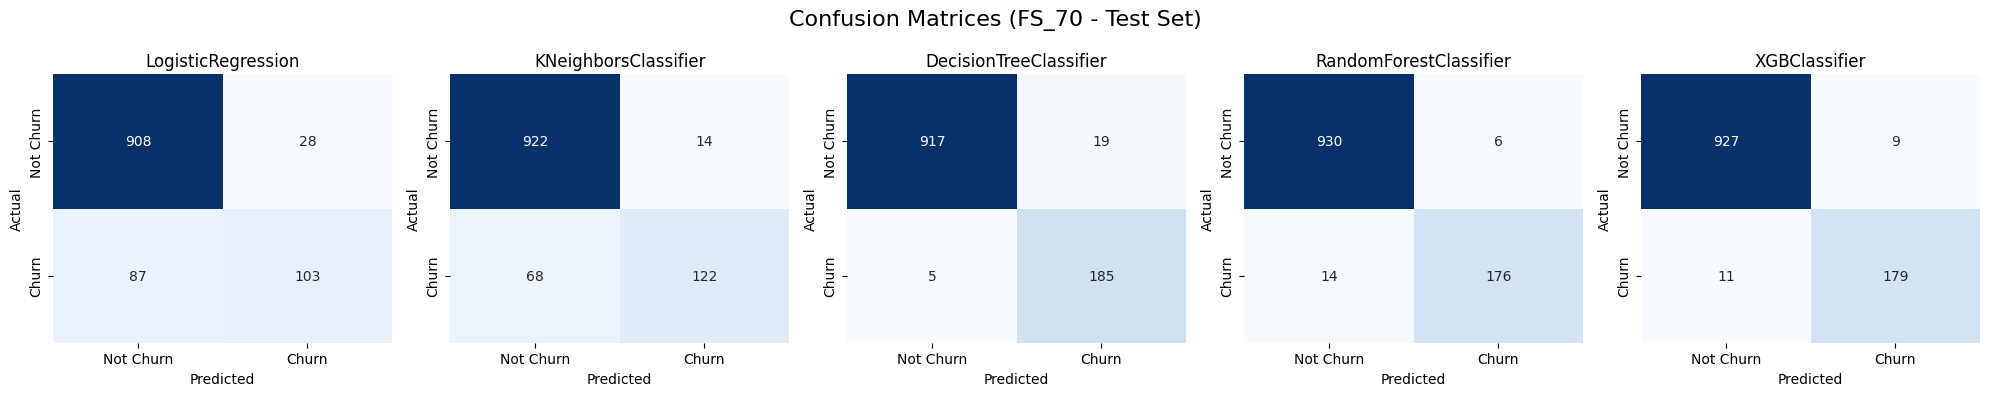

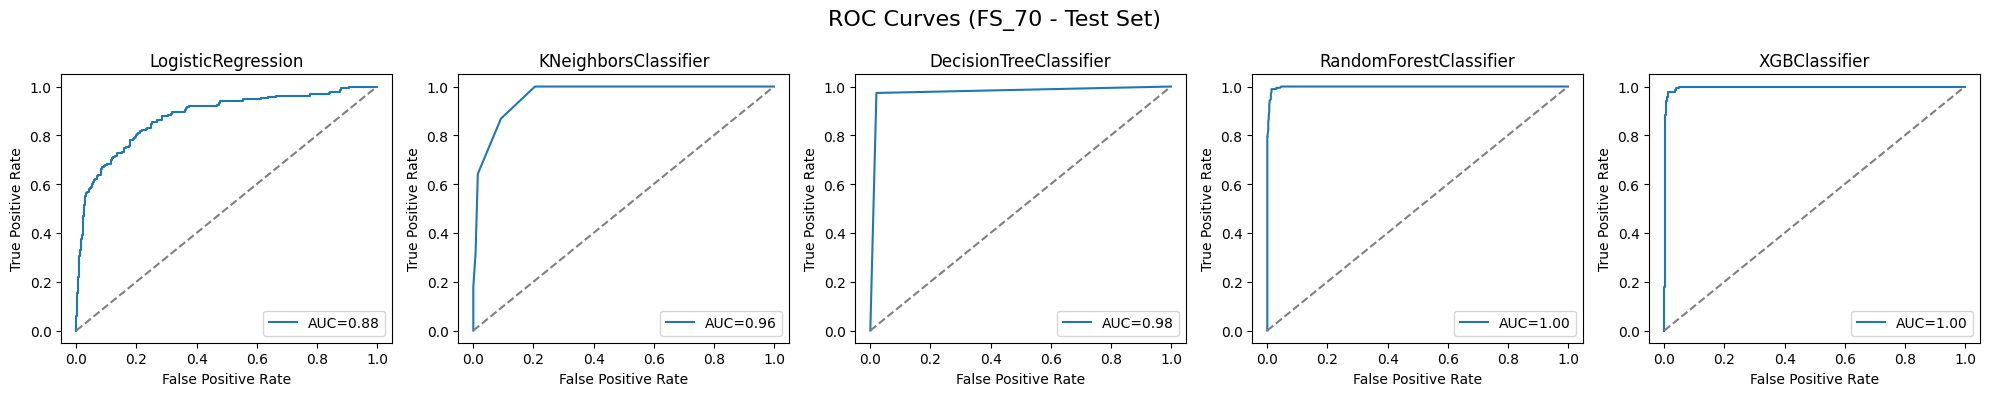

FS_80 | LogisticRegression CV F2: 0.5628 ± 0.0479
FS_80 | LogisticRegression uses 24 features
FS_80 | KNeighborsClassifier CV F2: 0.5921 ± 0.0356
FS_80 | KNeighborsClassifier uses 24 features
FS_80 | DecisionTreeClassifier CV F2: 0.8229 ± 0.0153
FS_80 | DecisionTreeClassifier uses 24 features
FS_80 | RandomForestClassifier CV F2: 0.7972 ± 0.0328
FS_80 | RandomForestClassifier uses 24 features


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

FS_80 | XGBClassifier CV F2: 0.8301 ± 0.0305
FS_80 | XGBClassifier uses 24 features

--- FS_80 Train vs Test Results ---
                 Model  Features Used  Train F2  Test F2  Train ROC-AUC  Test ROC-AUC  Train Precision  Test Precision  Train Recall  Test Recall
         XGBClassifier             24  1.000000 0.946089       1.000000      0.996772         1.000000        0.962366      1.000000     0.942105
DecisionTreeClassifier             24  1.000000 0.937173       1.000000      0.962506         1.000000        0.917949      1.000000     0.942105
RandomForestClassifier             24  1.000000 0.919235       1.000000      0.998288         1.000000        0.955801      1.000000     0.910526
  KNeighborsClassifier             24  0.904583 0.707182       0.994762      0.966329         0.965665        0.882759      0.890501     0.673684
    LogisticRegression             24  0.575246 0.566779       0.892474      0.878318         0.782027        0.770992      0.539578     0.531579


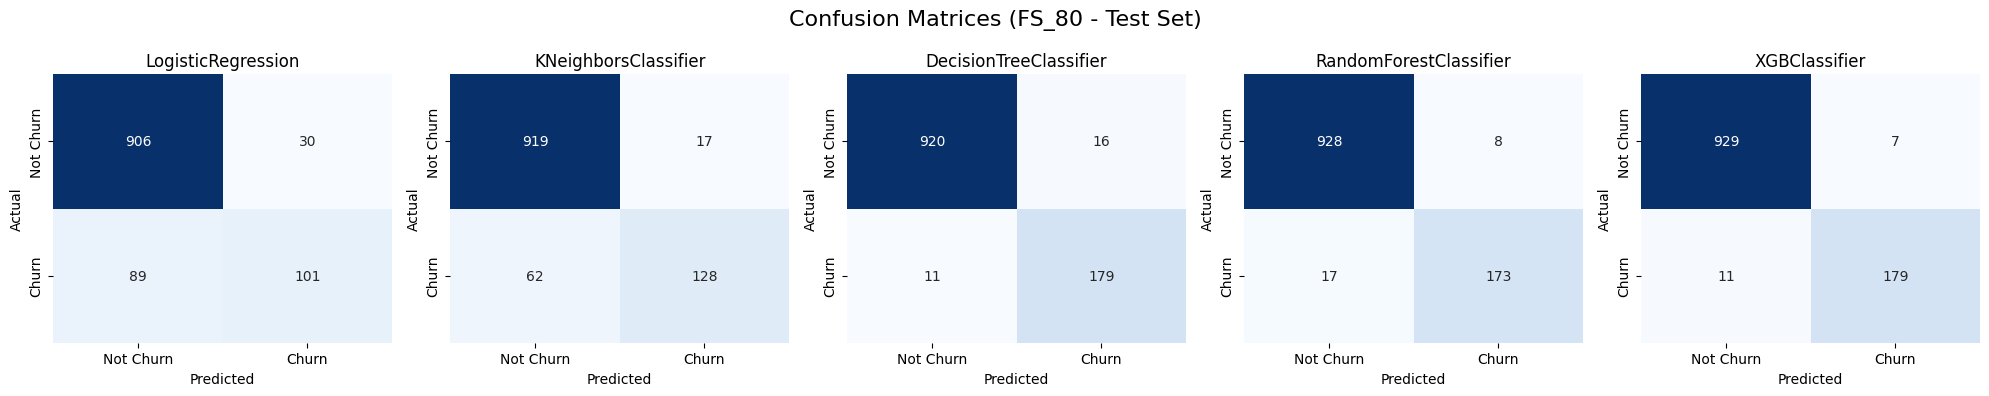

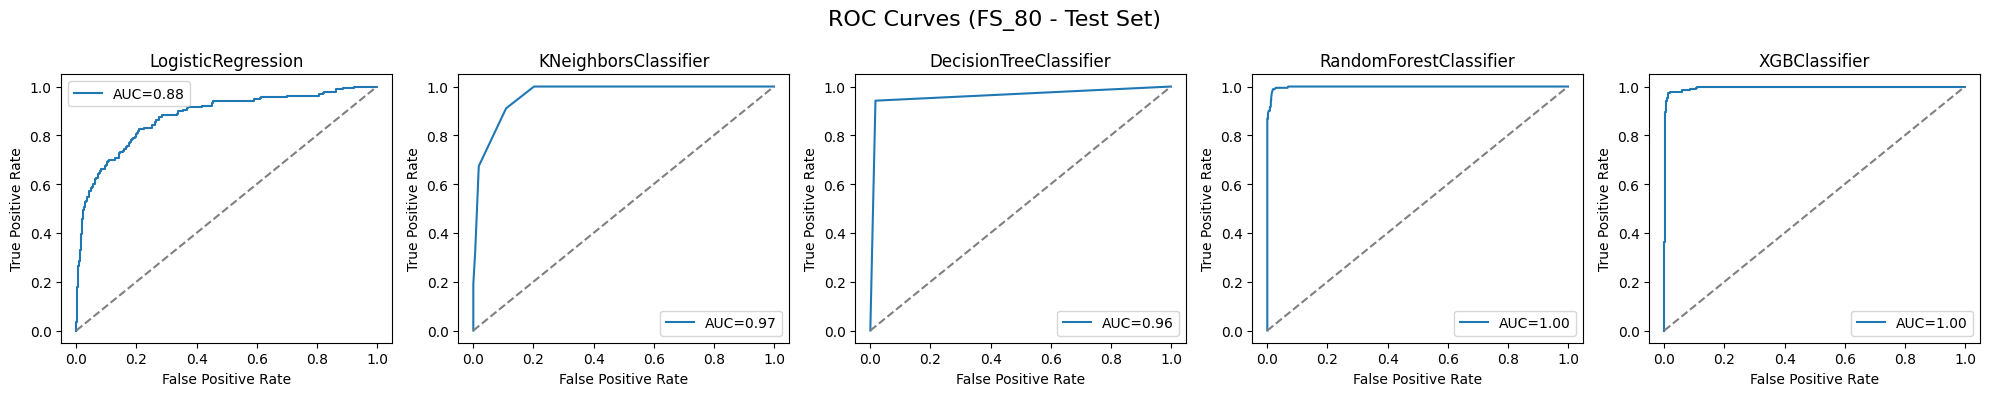

FS_90 | LogisticRegression CV F2: 0.5615 ± 0.0483
FS_90 | LogisticRegression uses 27 features
FS_90 | KNeighborsClassifier CV F2: 0.6160 ± 0.0318
FS_90 | KNeighborsClassifier uses 27 features
FS_90 | DecisionTreeClassifier CV F2: 0.8221 ± 0.0207
FS_90 | DecisionTreeClassifier uses 27 features
FS_90 | RandomForestClassifier CV F2: 0.8079 ± 0.0255
FS_90 | RandomForestClassifier uses 27 features


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

FS_90 | XGBClassifier CV F2: 0.8460 ± 0.0234
FS_90 | XGBClassifier uses 27 features

--- FS_90 Train vs Test Results ---
                 Model  Features Used  Train F2  Test F2  Train ROC-AUC  Test ROC-AUC  Train Precision  Test Precision  Train Recall  Test Recall
         XGBClassifier             27  1.000000 0.963983       1.000000      0.998853         1.000000        0.989130      1.000000     0.957895
DecisionTreeClassifier             27  1.000000 0.932914       1.000000      0.959874         1.000000        0.917526      1.000000     0.936842
RandomForestClassifier             27  1.000000 0.922175       1.000000      0.998715         1.000000        0.971910      1.000000     0.910526
  KNeighborsClassifier             27  0.863563 0.675223       0.992554      0.966551         0.963746        0.889706      0.841689     0.636842
    LogisticRegression             27  0.574648 0.565510       0.895779      0.886218         0.787645        0.759398      0.538259     0.531579


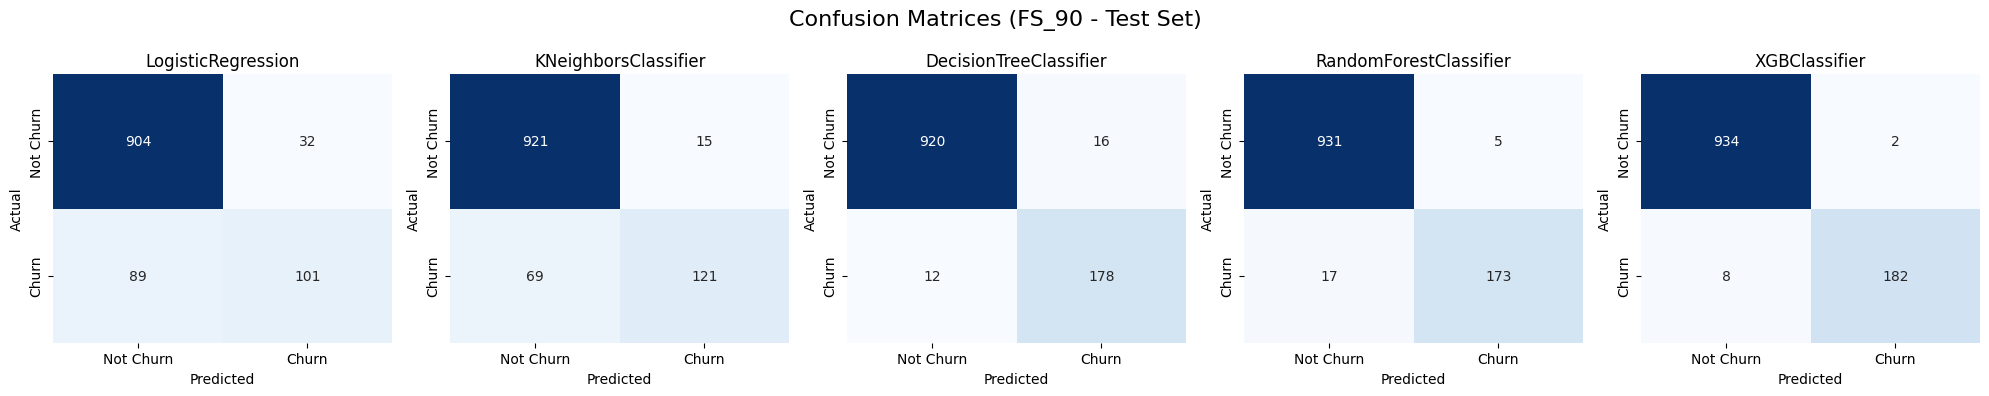

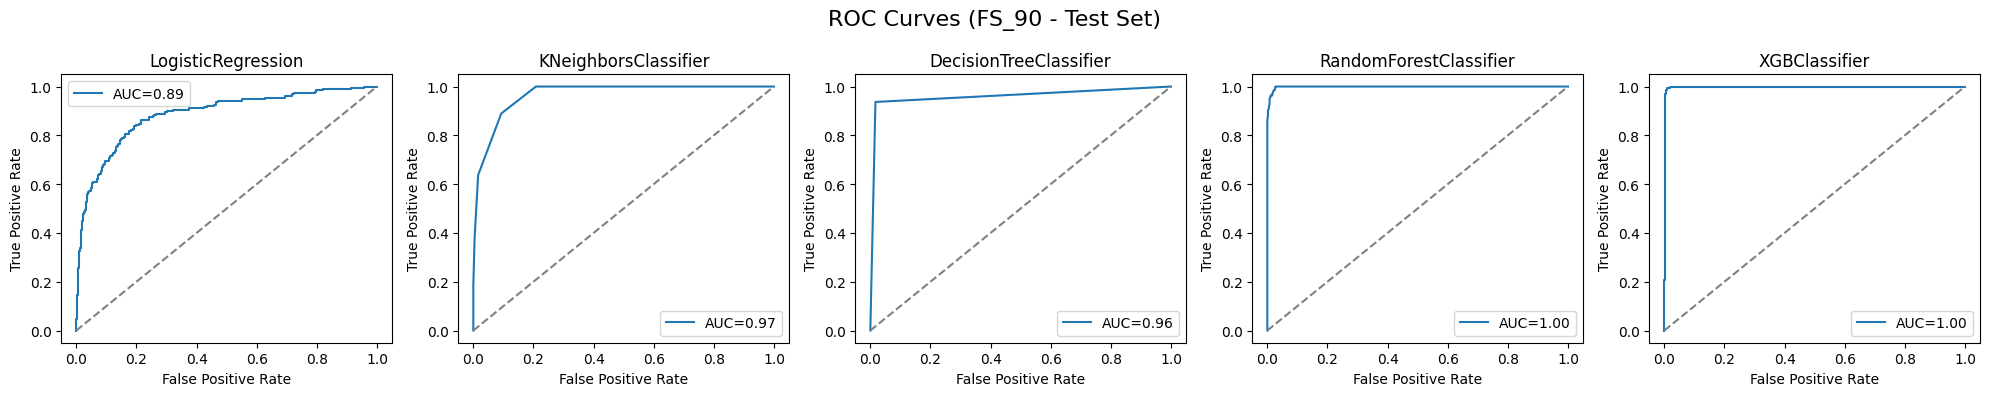

FS_100 | LogisticRegression CV F2: 0.5636 ± 0.0562
FS_100 | LogisticRegression uses 31 features
FS_100 | KNeighborsClassifier CV F2: 0.5617 ± 0.0227
FS_100 | KNeighborsClassifier uses 31 features
FS_100 | DecisionTreeClassifier CV F2: 0.8002 ± 0.0270
FS_100 | DecisionTreeClassifier uses 31 features
FS_100 | RandomForestClassifier CV F2: 0.7875 ± 0.0373
FS_100 | RandomForestClassifier uses 31 features


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

FS_100 | XGBClassifier CV F2: 0.8276 ± 0.0408
FS_100 | XGBClassifier uses 31 features

--- FS_100 Train vs Test Results ---
                 Model  Features Used  Train F2  Test F2  Train ROC-AUC  Test ROC-AUC  Train Precision  Test Precision  Train Recall  Test Recall
         XGBClassifier             31  1.000000 0.965190       1.000000      0.998341         1.000000        0.973404      1.000000     0.963158
RandomForestClassifier             31  1.000000 0.918803       1.000000      0.998558         1.000000        0.977273      1.000000     0.905263
DecisionTreeClassifier             31  1.000000 0.912907       1.000000      0.947745         1.000000        0.901554      1.000000     0.915789
  KNeighborsClassifier             31  0.828104 0.671476       0.990903      0.952148         0.958926        0.858156      0.800792     0.636842
    LogisticRegression             31  0.580872 0.576063       0.896610      0.885211         0.789675        0.768657      0.544855     0.542105


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:36:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


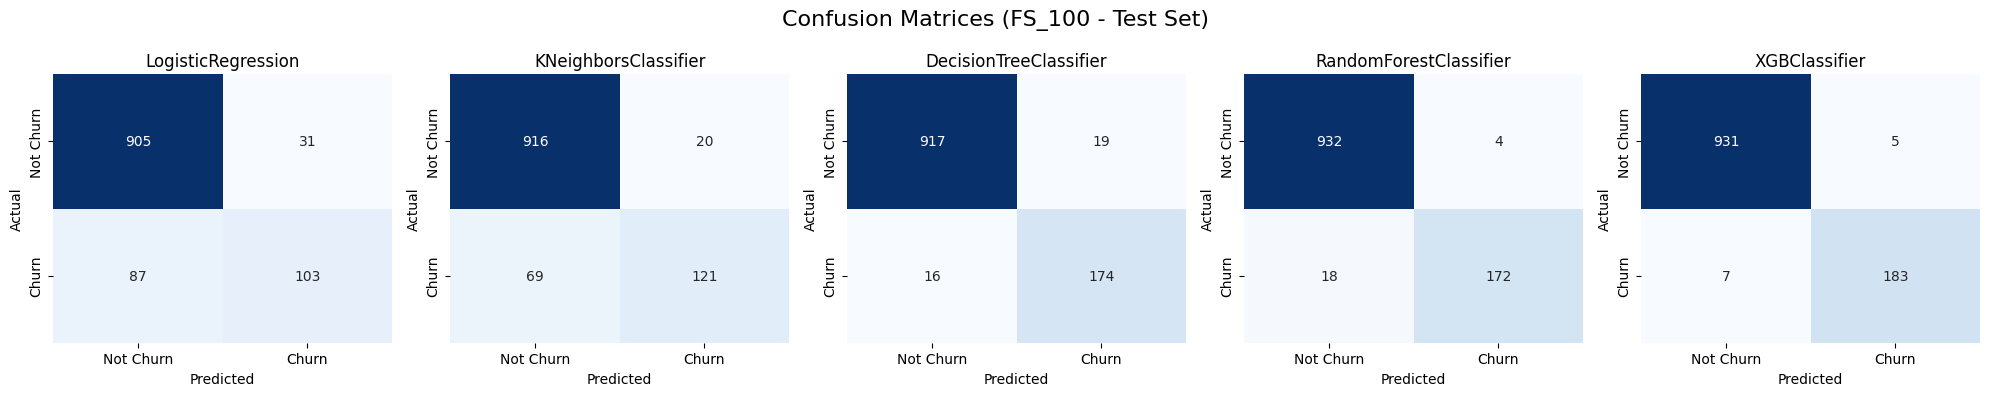

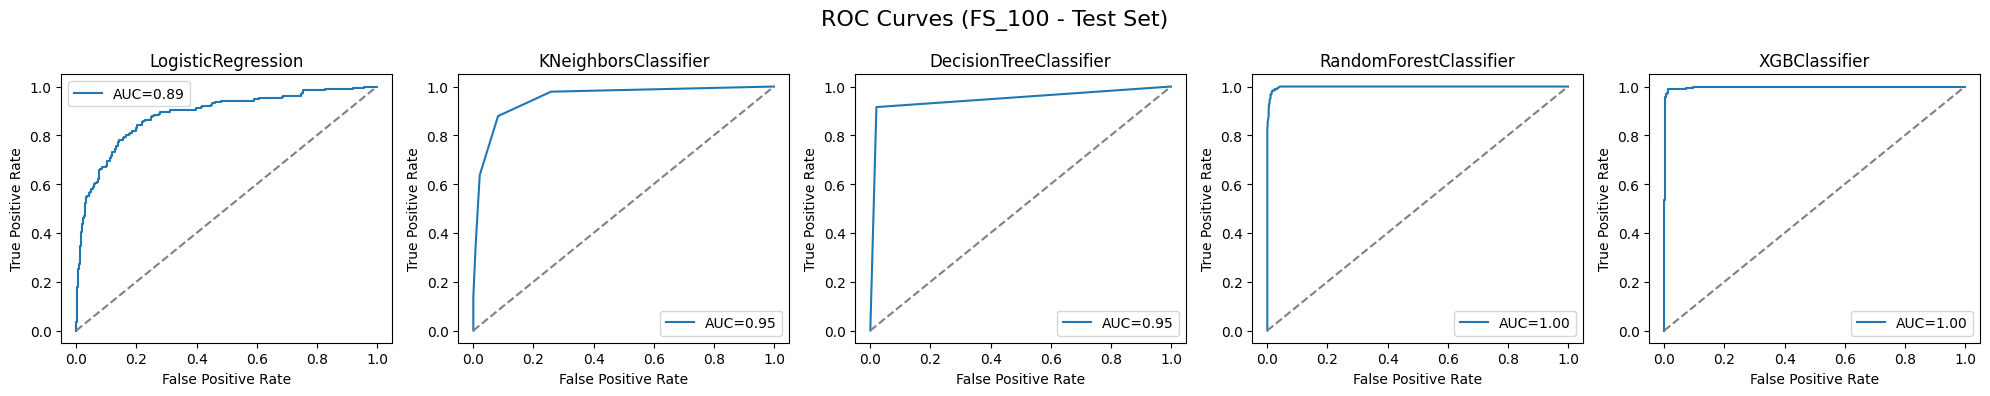

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    fbeta_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# --- Candidate Models ---
simple_models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
}

# --- Pipelines to compare (Feature Selection Percentiles) ---
percentiles = [50, 60, 70, 80, 90, 100]
pipelines = {f"FS_{p}": joblib.load(f"pipeline_fs_{p}.pkl") for p in percentiles}

# --- Benchmark Function with Stratified K-Fold ---
def benchmark_feature_selection_pipeline(pipeline_name, pipeline, models, X_train, y_train, X_test, y_test, cv=5):
    results = []
    conf_matrices = {}
    roc_curves = {}

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    for name, model in models.items():
        full_pipeline = ImbPipeline(steps=pipeline.steps + [('model', model)])

        # --- Cross-validation (on train set only, to check variance) ---
        f2_cv = cross_val_score(full_pipeline, X_train, y_train, cv=skf,
                                scoring=lambda est, X, y: fbeta_score(y, est.predict(X), beta=2))
        print(f"{pipeline_name} | {name} CV F2: {f2_cv.mean():.4f} ± {f2_cv.std():.4f}")

        # --- Fit on full training data ---
        full_pipeline.fit(X_train, y_train)

        # --- Feature count ---
        n_features = None
        if "select" in dict(pipeline.named_steps):
            selector = full_pipeline.named_steps["select"]
            n_features = selector.get_support().sum()
        print(f"{pipeline_name} | {name} uses {n_features} features")

        # --- Train predictions ---
        y_train_pred = full_pipeline.predict(X_train)
        y_train_proba = full_pipeline.predict_proba(X_train)[:, 1] if hasattr(full_pipeline, "predict_proba") else None

        train_f2 = fbeta_score(y_train, y_train_pred, beta=2)
        train_roc_auc = roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else np.nan
        train_precision = precision_score(y_train, y_train_pred, zero_division=0)
        train_recall = recall_score(y_train, y_train_pred, zero_division=0)

        # --- Test predictions ---
        y_test_pred = full_pipeline.predict(X_test)
        y_test_proba = full_pipeline.predict_proba(X_test)[:, 1] if hasattr(full_pipeline, "predict_proba") else None

        test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
        test_roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else np.nan
        test_precision = precision_score(y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, zero_division=0)
        conf_matrix = confusion_matrix(y_test, y_test_pred)

        # --- Save results ---
        results.append({
            'Model': name,
            'Features Used': n_features,
            'Train F2': train_f2,
            'Test F2': test_f2,
            'Train ROC-AUC': train_roc_auc,
            'Test ROC-AUC': test_roc_auc,
            'Train Precision': train_precision,
            'Test Precision': test_precision,
            'Train Recall': train_recall,
            'Test Recall': test_recall
        })

        conf_matrices[name] = conf_matrix
        if y_test_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_test_proba)
            roc_curves[name] = (fpr, tpr, auc(fpr, tpr))

    # --- Collect results ---
    results_df = pd.DataFrame(results).sort_values(by="Test F2", ascending=False)
    print(f"\n--- {pipeline_name} Train vs Test Results ---")
    print(results_df.to_string(index=False))

    # --- Confusion Matrices ---
    fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
    for ax, (name, matrix) in zip(axes, conf_matrices.items()):
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Not Churn", "Churn"],
                    yticklabels=["Not Churn", "Churn"], ax=ax)
        ax.set_title(f"{name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.suptitle(f"Confusion Matrices ({pipeline_name} - Test Set)", fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- ROC Curves ---
    if roc_curves:
        fig, axes = plt.subplots(1, len(roc_curves), figsize=(20, 4))
        for ax, (name, (fpr, tpr, roc_auc)) in zip(axes, roc_curves.items()):
            ax.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
            ax.set_title(name)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()
        plt.suptitle(f"ROC Curves ({pipeline_name} - Test Set)", fontsize=16)
        plt.tight_layout()
        plt.show()

    return results_df

# --- Run Benchmark for All Feature Selection Pipelines ---
all_results = {}
for name, pipe in pipelines.items():
    results_df = benchmark_feature_selection_pipeline(
        name, pipe, simple_models, X_train, y_train, X_test, y_test, cv=5
    )

    # Save to dictionary for in-memory comparison
    all_results[name] = results_df

    # Save each result as CSV file for external analysis
    results_df.to_csv(f"benchmark_results_{name}.csv", index=False)

Best Model: `XGBClassifier`
Feature Selection: `70` percentile good enough with `0.944` F2 score on test set

### 5.1.1. Benchmarking With Oversampling

Use `70` percentile for ROS and SMOTE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
import joblib

# --- 1. Load the dataset ---
try:
    df = pd.read_csv('eda.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'eda.csv' not found. Please check the file path.")
    exit()

# --- 2. Define features and target ---
TARGET = 'Churn'

# Categorization based on the provided feedback
# CustomerID is not used as features
df.set_index('CustomerID', inplace=True)

ordinal_features = ['CityTier', 'SatisfactionScore']
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
categorical_features = ['PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'Complain']

# Separate target variable
X = df.drop(columns=[TARGET])
y = df[TARGET]

# --- 3. Split the data to prevent data leakage ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"Original data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"\nOriginal Churn distribution: {Counter(y)}")
print(f"Training Churn distribution: {Counter(y_train)}")

# --- 4. Define Preprocessing Pipelines ---
# A. Numerical Preprocessor
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# B. Nominal Categorical Preprocessor (One-Hot Encoding)
nominal_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# C. Ordinal Categorical Preprocessor (Ordinal Encoding)
ordinal_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# D. Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features),
        ('nominal_cat', nominal_preprocessor, categorical_features),
        ('ordinal_cat', ordinal_preprocessor, ordinal_features)
    ],
    remainder='passthrough'
)

# --- 5. Build Full Pipelines ---
# Pipeline with RandomOverSampler
ros_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectPercentile(score_func=f_classif, percentile=70)),
    ('ros', RandomOverSampler(random_state=RANDOM_STATE))
])

# Pipeline with SMOTE + SelectPercentile
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectPercentile(score_func=f_classif, percentile=70)),
    ('smote', SMOTE(random_state=RANDOM_STATE))
])

# --- 6. Save Pipelines ---
joblib.dump(ros_pipeline, 'pipeline_fs_70_ros.pkl')
joblib.dump(smote_pipeline, 'pipeline_fs_70_smote.pkl')

print("\n✅ Pipelines saved:")
print("- ROS pipeline: pipeline_fs_70_ros.pkl")
print("- SMOTE pipeline: pipeline_fs_70_smote.pkl")

Dataset loaded successfully.
Original data shape: (5630, 18)
Training data shape: (4504, 18)
Testing data shape: (1126, 18)

Original Churn distribution: Counter({0: 4682, 1: 948})
Training Churn distribution: Counter({0: 3746, 1: 758})

✅ Pipelines saved:
- ROS pipeline: pipeline_fs_70_ros.pkl
- SMOTE pipeline: pipeline_fs_70_smote.pkl


ROS | LogisticRegression CV F2: 0.6892 ± 0.0270
ROS | LogisticRegression uses 21 features
ROS | KNeighborsClassifier CV F2: 0.8103 ± 0.0189
ROS | KNeighborsClassifier uses 21 features
ROS | DecisionTreeClassifier CV F2: 0.7786 ± 0.0280
ROS | DecisionTreeClassifier uses 21 features
ROS | RandomForestClassifier CV F2: 0.8466 ± 0.0303
ROS | RandomForestClassifier uses 21 features


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:41:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:41:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:41:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:41:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

ROS | XGBClassifier CV F2: 0.8640 ± 0.0250
ROS | XGBClassifier uses 21 features

--- ROS Train vs Test Results ---
                 Model  Features Used  Train F2  Test F2  Train ROC-AUC  Test ROC-AUC  Train Precision  Test Precision  Train Recall  Test Recall
RandomForestClassifier             21  1.000000 0.960334       1.000000      0.998642         1.000000        0.929293      1.000000     0.968421
         XGBClassifier             21  0.998946 0.958115       1.000000      0.994197         0.994751        0.938462      1.000000     0.963158
  KNeighborsClassifier             21  0.945000 0.902978       0.999276      0.984756         0.780992        0.669039      0.997361     0.989474
DecisionTreeClassifier             21  1.000000 0.899471       1.000000      0.939356         1.000000        0.918919      1.000000     0.894737
    LogisticRegression             21  0.713304 0.685921       0.891431      0.878475         0.466667        0.436782      0.821900     0.800000


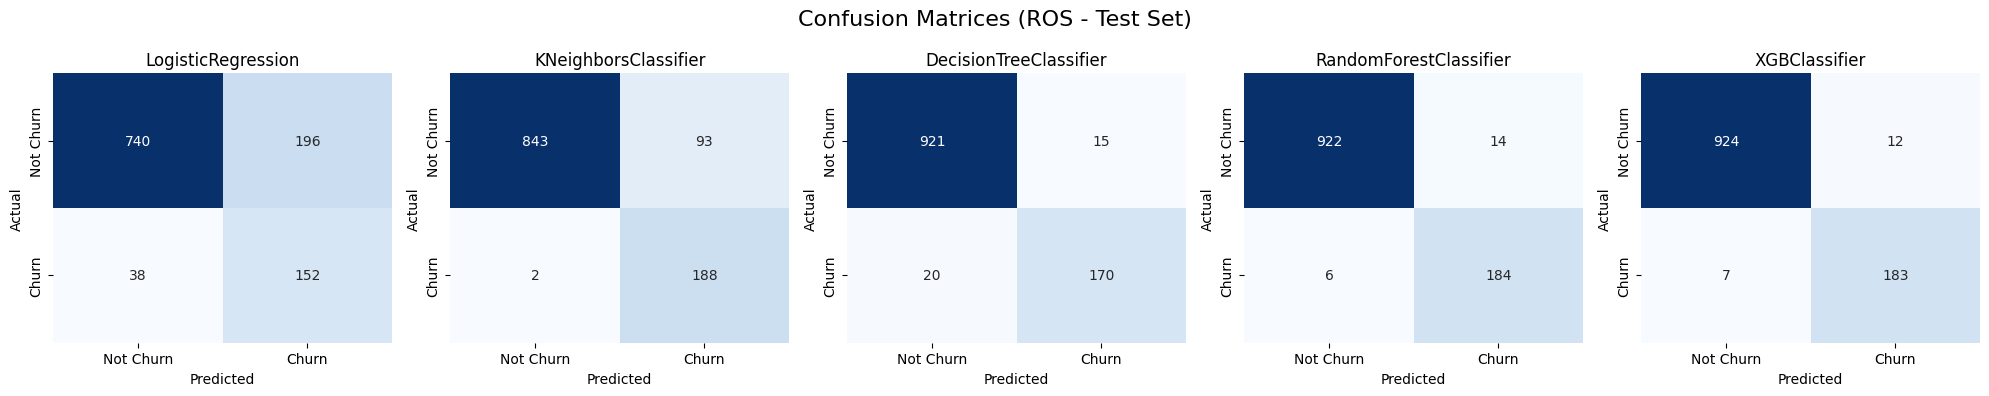

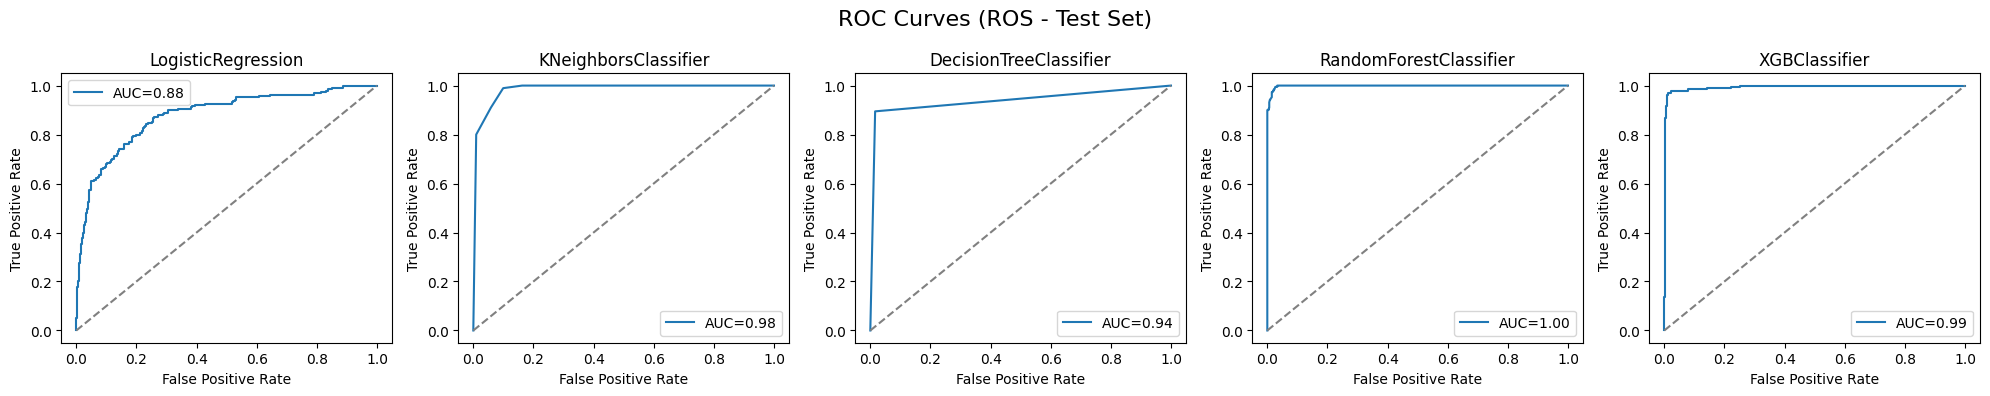

SMOTE | LogisticRegression CV F2: 0.6760 ± 0.0345
SMOTE | LogisticRegression uses 21 features
SMOTE | KNeighborsClassifier CV F2: 0.8168 ± 0.0091
SMOTE | KNeighborsClassifier uses 21 features
SMOTE | DecisionTreeClassifier CV F2: 0.7829 ± 0.0450
SMOTE | DecisionTreeClassifier uses 21 features
SMOTE | RandomForestClassifier CV F2: 0.8165 ± 0.0254
SMOTE | RandomForestClassifier uses 21 features


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:41:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:41:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:41:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:41:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

SMOTE | XGBClassifier CV F2: 0.8280 ± 0.0338
SMOTE | XGBClassifier uses 21 features

--- SMOTE Train vs Test Results ---
                 Model  Features Used  Train F2  Test F2  Train ROC-AUC  Test ROC-AUC  Train Precision  Test Precision  Train Recall  Test Recall
         XGBClassifier             21  0.998681 0.943396       0.999999      0.994073         0.998681        0.927835      0.998681     0.947368
RandomForestClassifier             21  1.000000 0.918153       1.000000      0.995965         1.000000        0.906736      1.000000     0.921053
  KNeighborsClassifier             21  0.947434 0.889101       0.999362      0.979898         0.786085        0.650350      0.998681     0.978947
DecisionTreeClassifier             21  1.000000 0.861890       1.000000      0.917077         1.000000        0.817734      1.000000     0.873684
    LogisticRegression             21  0.702196 0.677507       0.891415      0.878447         0.458209        0.432277      0.810026     0.789474


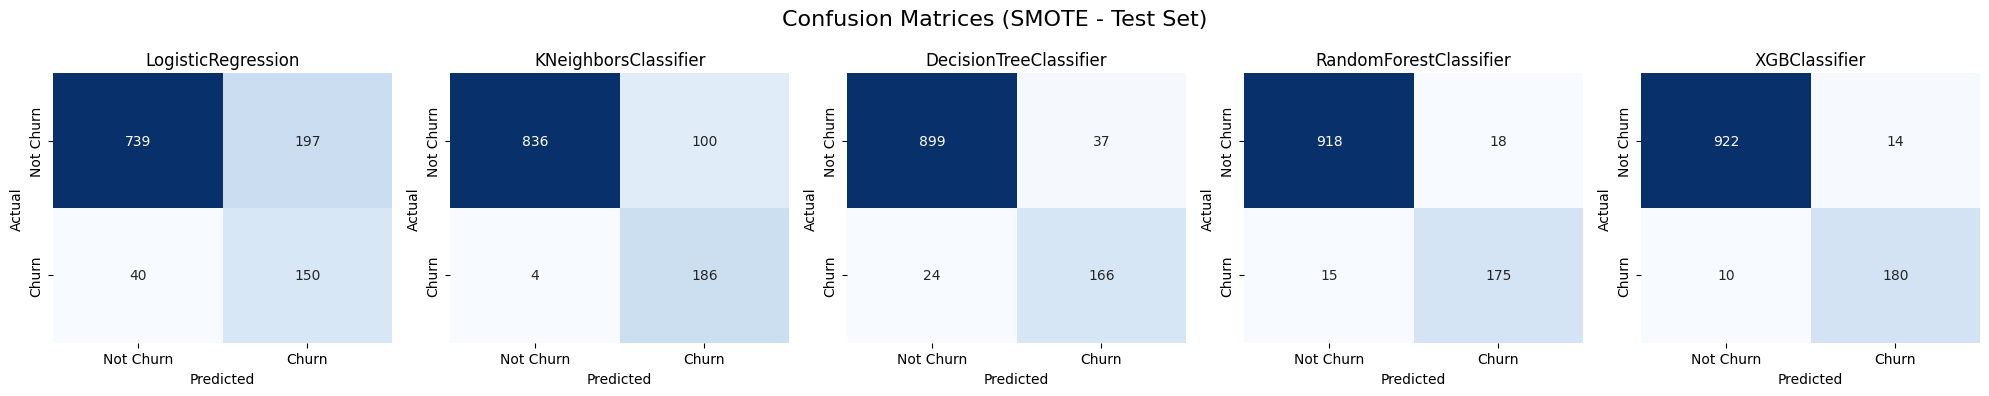

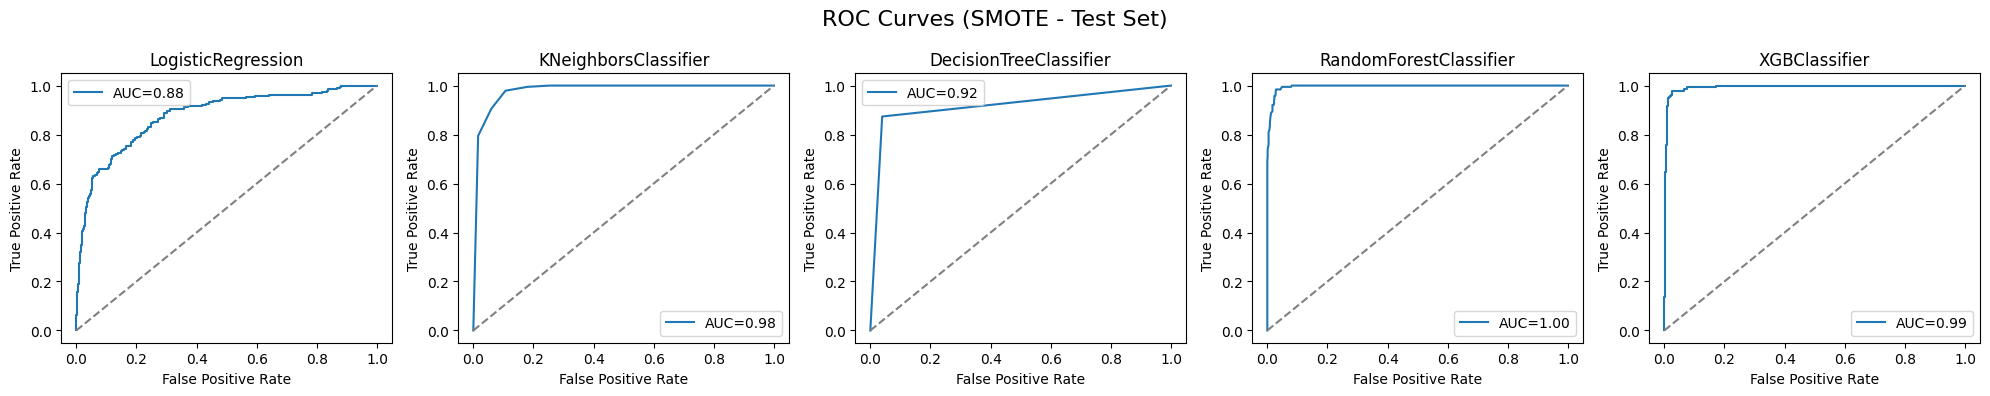


--- F2 Score Comparison (Test Set, Sorted by FS_70) ---
                 Model    FS_70  FS_70_ROS  FS_70_SMOTE
DecisionTreeClassifier 0.959544   0.899471     0.861890
         XGBClassifier 0.944093   0.958115     0.943396
RandomForestClassifier 0.934183   0.960334     0.918153
  KNeighborsClassifier 0.680804   0.902978     0.889101
    LogisticRegression 0.578002   0.685921     0.677507


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    fbeta_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, roc_curve, auc
)

from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# --- Candidate Models ---
simple_models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
}

# --- Pipelines to compare ---
pipelines = {
    "ROS": joblib.load("pipeline_fs_70_ros.pkl"),
    "SMOTE": joblib.load("pipeline_fs_70_smote.pkl")
}

# --- Benchmark Function ---
def benchmark_pipeline(pipeline_name, pipeline, models, X_train, y_train, X_test, y_test, cv=5):
    results = []
    conf_matrices = {}
    roc_curves = {}

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    for name, model in models.items():
        full_pipeline = ImbPipeline(steps=pipeline.steps + [('model', model)])

        # --- Cross-validation (on train set only, to check variance) ---
        f2_cv = cross_val_score(full_pipeline, X_train, y_train, cv=skf,
                                scoring=lambda est, X, y: fbeta_score(y, est.predict(X), beta=2))
        print(f"{pipeline_name} | {name} CV F2: {f2_cv.mean():.4f} ± {f2_cv.std():.4f}")

        # --- Fit on full training data ---
        full_pipeline.fit(X_train, y_train)

        # --- Feature count ---
        n_features = None
        if "select" in dict(pipeline.named_steps):
            selector = full_pipeline.named_steps["select"]
            n_features = selector.get_support().sum()
        print(f"{pipeline_name} | {name} uses {n_features} features")

        # --- Train predictions ---
        y_train_pred = full_pipeline.predict(X_train)
        y_train_proba = full_pipeline.predict_proba(X_train)[:, 1] if hasattr(full_pipeline, "predict_proba") else None

        train_f2 = fbeta_score(y_train, y_train_pred, beta=2)
        train_roc_auc = roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else np.nan
        train_precision = precision_score(y_train, y_train_pred, zero_division=0)
        train_recall = recall_score(y_train, y_train_pred, zero_division=0)

        # --- Test predictions ---
        y_test_pred = full_pipeline.predict(X_test)
        y_test_proba = full_pipeline.predict_proba(X_test)[:, 1] if hasattr(full_pipeline, "predict_proba") else None

        test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
        test_roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else np.nan
        test_precision = precision_score(y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, zero_division=0)
        conf_matrix = confusion_matrix(y_test, y_test_pred)

        # --- Save results ---
        results.append({
            'Model': name,
            'Features Used': n_features,
            'Train F2': train_f2,
            'Test F2': test_f2,
            'Train ROC-AUC': train_roc_auc,
            'Test ROC-AUC': test_roc_auc,
            'Train Precision': train_precision,
            'Test Precision': test_precision,
            'Train Recall': train_recall,
            'Test Recall': test_recall
        })

        conf_matrices[name] = conf_matrix
        if y_test_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_test_proba)
            roc_curves[name] = (fpr, tpr, auc(fpr, tpr))

    # --- Collect results ---
    results_df = pd.DataFrame(results).sort_values(by="Test F2", ascending=False)
    print(f"\n--- {pipeline_name} Train vs Test Results ---")
    print(results_df.to_string(index=False))

    # --- Confusion Matrices ---
    fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
    for ax, (name, matrix) in zip(axes, conf_matrices.items()):
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Not Churn", "Churn"],
                    yticklabels=["Not Churn", "Churn"], ax=ax)
        ax.set_title(f"{name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.suptitle(f"Confusion Matrices ({pipeline_name} - Test Set)", fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- ROC Curves ---
    if roc_curves:
        fig, axes = plt.subplots(1, len(roc_curves), figsize=(20, 4))
        for ax, (name, (fpr, tpr, roc_auc)) in zip(axes, roc_curves.items()):
            ax.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
            ax.set_title(name)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()
        plt.suptitle(f"ROC Curves ({pipeline_name} - Test Set)", fontsize=16)
        plt.tight_layout()
        plt.show()

    return results_df


# --- Run Benchmark for Both Pipelines ---
ros_results = benchmark_pipeline("ROS", pipelines["ROS"], simple_models, X_train, y_train, X_test, y_test)
smote_results = benchmark_pipeline("SMOTE", pipelines["SMOTE"], simple_models, X_train, y_train, X_test, y_test)

# --- Load and combine results ---
fs70_results = pd.read_csv("benchmark_results_FS_70.csv")
ros_results = ros_results.copy()
smote_results = smote_results.copy()

fs70_results["Pipeline"] = "FS_70"
ros_results["Pipeline"] = "FS_70_ROS"
smote_results["Pipeline"] = "FS_70_SMOTE"

comparison_df = pd.concat([fs70_results, ros_results, smote_results], ignore_index=True)

# --- Pivot to compare Test F2 ---
f2_comparison = comparison_df.pivot_table(
    index="Model",
    columns="Pipeline",
    values="Test F2",
    aggfunc="mean"
).reset_index()

# --- Sort by baseline FS_70 ---
f2_comparison = f2_comparison.sort_values(by="FS_70", ascending=False).reset_index(drop=True)

print("\n--- F2 Score Comparison (Test Set, Sorted by FS_70) ---")
print(f2_comparison.to_string(index=False))


`XGBoostClassifier` and `RandomForestClassifier` perform better using `ROS` in the same feature selection `70` percentile compare to original and `SMOTE` oversampling

## 5.2. Hyperparameter Tuning

- Models: `XGBoostClassifier` and `RandomForestClassifier`
- Preprocess pipeline with Feature Selection `70` percentile + `ROS`


--- Running RF+ROS ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for RF+ROS: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
Best CV F2-Score: 0.8560

--- Running XGB+ROS ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:08:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:08:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:08:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:08:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best params for XGB+ROS: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}
Best CV F2-Score: 0.8660

--- Final Results ---
Experiment  F2-Score  Precision   Recall  ROC-AUC
   XGB+ROS  0.960126   0.948187 0.963158 0.998324
    RF+ROS  0.951883   0.928571 0.957895 0.998611

Best experiment: XGB+ROS with F2-Score 0.9601


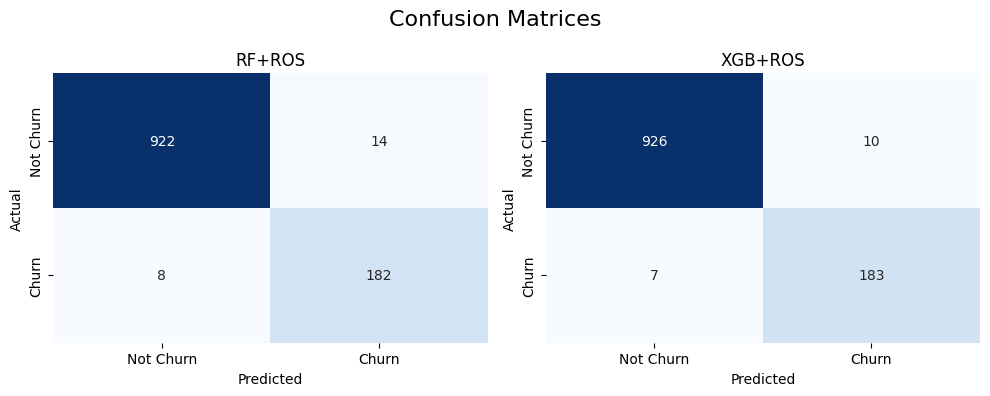

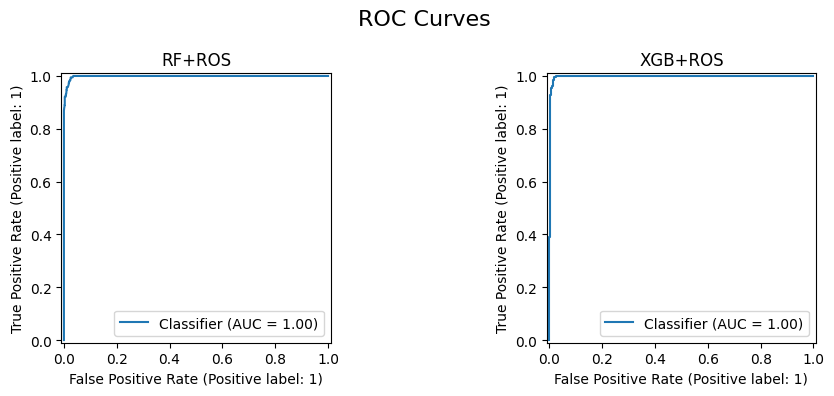

✅ Best model pipeline saved as best_model_fs_pipeline.pkl


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    fbeta_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, make_scorer, RocCurveDisplay
)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- Hyperparameter Grids ---
rf_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_leaf": [1, 2, 4],
}

xgb_params = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
}

# --- Experiments Setup (ROS only with FS 70) ---
experiments = {
    "RF+ROS": {
        "pipeline": ImbPipeline(steps=ros_pipeline.steps + [
            ("model", RandomForestClassifier(random_state=RANDOM_STATE))
        ]),
        "params": rf_params
    },
    "XGB+ROS": {
        "pipeline": ImbPipeline(steps=ros_pipeline.steps + [
            ("model", XGBClassifier(
                random_state=RANDOM_STATE,
                use_label_encoder=False,
                eval_metric="logloss"
            ))
        ]),
        "params": xgb_params
    }
}

# --- Custom Scorers ---
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring_metrics = {
    "F2-Score": f2_scorer,
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "ROC-AUC": make_scorer(roc_auc_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# --- Run Experiments ---
results = []
conf_matrices = {}
roc_curves = {}
best_model = None
best_score = 0
best_name = None

for name, exp in experiments.items():
    print(f"\n--- Running {name} ---")
    
    grid = GridSearchCV(
        estimator=exp["pipeline"],
        param_grid=exp["params"],
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_estimator = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best CV F2-Score: {grid.best_score_:.4f}")
    
    # --- Predictions ---
    y_pred = best_estimator.predict(X_test)
    y_pred_proba = (
        best_estimator.predict_proba(X_test)[:, 1]
        if hasattr(best_estimator, "predict_proba") else None
    )
    
    f2 = fbeta_score(y_test, y_pred, beta=2)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        "Experiment": name,
        "F2-Score": f2,
        "Precision": precision,
        "Recall": recall,
        "ROC-AUC": roc_auc
    })
    
    conf_matrices[name] = cm
    if y_pred_proba is not None:
        roc_curves[name] = (y_test, y_pred_proba)
    
    if f2 > best_score:
        best_score = f2
        best_model = best_estimator
        best_name = name

# --- Results Summary ---
results_df = pd.DataFrame(results).sort_values(by="F2-Score", ascending=False)
print("\n--- Final Results ---")
print(results_df.to_string(index=False))
print(f"\nBest experiment: {best_name} with F2-Score {best_score:.4f}")

# --- Plot Confusion Matrices ---
fig, axes = plt.subplots(1, len(conf_matrices), figsize=(5 * len(conf_matrices), 4))
if len(conf_matrices) == 1:
    axes = [axes]
for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Not Churn", "Churn"],
                yticklabels=["Not Churn", "Churn"])
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
fig.suptitle("Confusion Matrices", fontsize=16)
plt.tight_layout()
plt.show()

# --- Plot ROC Curves ---
fig, axes = plt.subplots(1, len(roc_curves), figsize=(5 * len(roc_curves), 4))
if len(roc_curves) == 1:
    axes = [axes]
for ax, (name, (y_true, y_proba)) in zip(axes, roc_curves.items()):
    RocCurveDisplay.from_predictions(y_true, y_proba, ax=ax)
    ax.set_title(name)
fig.suptitle("ROC Curves", fontsize=16)
plt.tight_layout()
plt.show()

# --- Save Best Model Pipeline ---
joblib.dump(best_model, "best_model_fs_pipeline.pkl")
print("✅ Best model pipeline saved as best_model_fs_pipeline.pkl")

## 5.3. Feature Importances

/tmp/ipykernel_7646/2798344905.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")


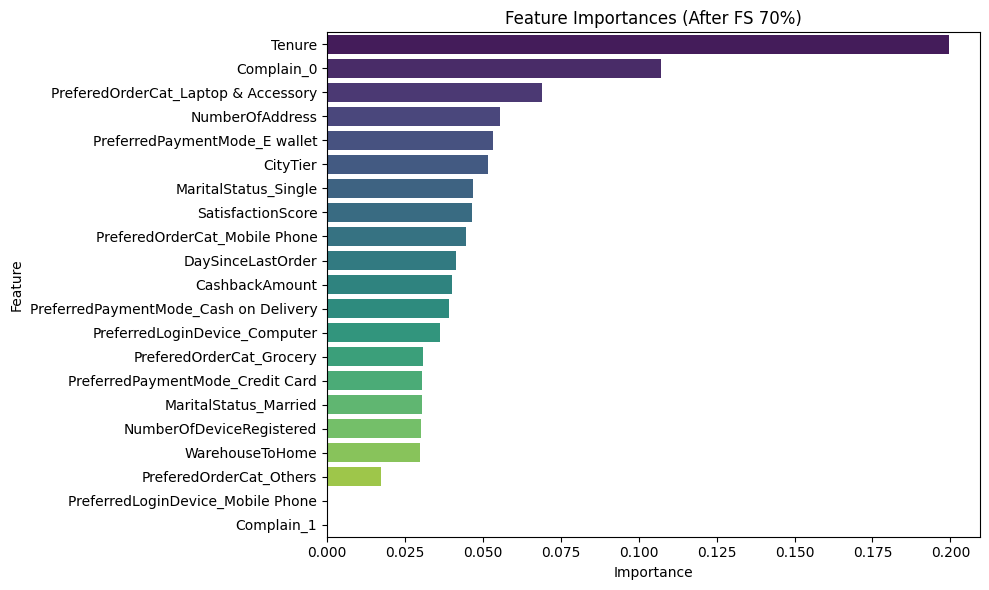


Top 10 features by importance:
                            Feature  Importance
                             Tenure    0.199539
                         Complain_0    0.107013
PreferedOrderCat_Laptop & Accessory    0.069124
                    NumberOfAddress    0.055610
      PreferredPaymentMode_E wallet    0.053189
                           CityTier    0.051499
               MaritalStatus_Single    0.046773
                  SatisfactionScore    0.046418
      PreferedOrderCat_Mobile Phone    0.044706
                  DaySinceLastOrder    0.041498


In [12]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load best pipeline ---
best_pipeline = joblib.load("best_model_fs_pipeline.pkl")

# --- Locate preprocessor & selector ---
preprocessor = None
selector = None
for name, step in best_pipeline.named_steps.items():
    if hasattr(step, "transformers_"):  # ColumnTransformer
        preprocessor = step
    if hasattr(step, "get_support"):    # Feature Selector (e.g., SelectPercentile)
        selector = step

if preprocessor is None:
    raise ValueError("Could not find a ColumnTransformer in the pipeline.")
if selector is None:
    raise ValueError("Could not find a Feature Selector in the pipeline.")

# --- Get all feature names after preprocessing ---
all_features = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, "get_feature_names_out"):
        all_features.extend(trans.get_feature_names_out(cols))
    else:
        all_features.extend(cols)

# --- Apply selector support mask to keep only selected features ---
selected_features = [f for f, keep in zip(all_features, selector.get_support()) if keep]

# --- Get final model ---
model = best_pipeline.named_steps["model"]

# --- Get feature importances ---
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
else:
    raise ValueError("The model does not support feature importances.")

# --- Create DataFrame ---
feat_imp = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances (After FS 70%)")
plt.tight_layout()
plt.show()

# --- Print top 10 ---
print("\nTop 10 features by importance:")
print(feat_imp.head(10).to_string(index=False))


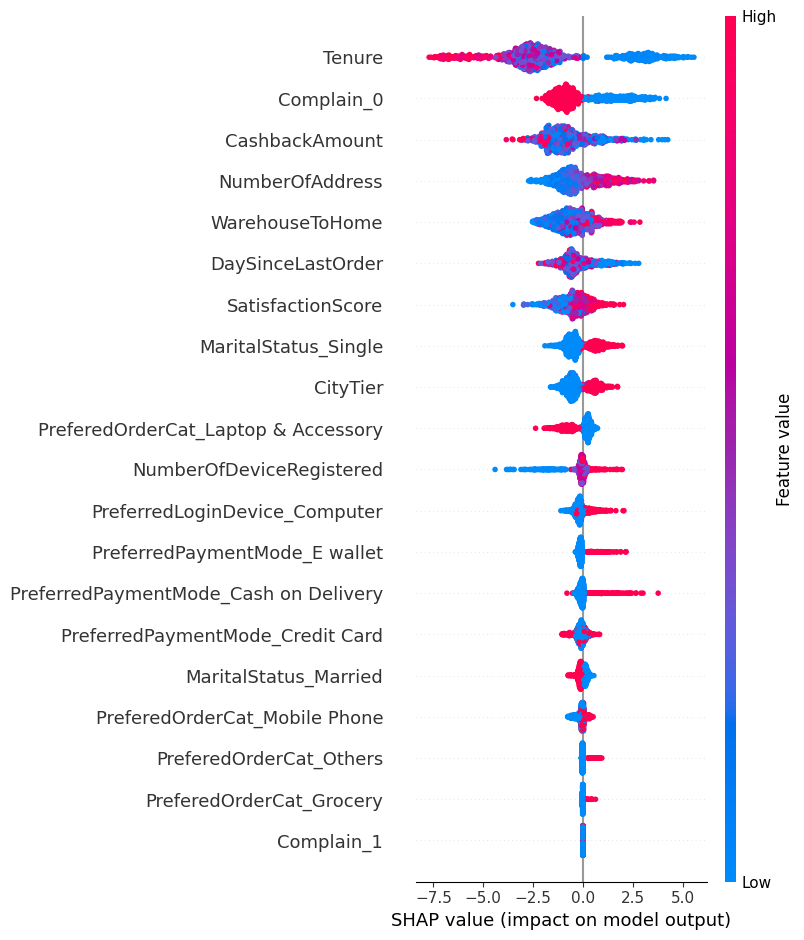

Predicted class: 0
Actual class: 0


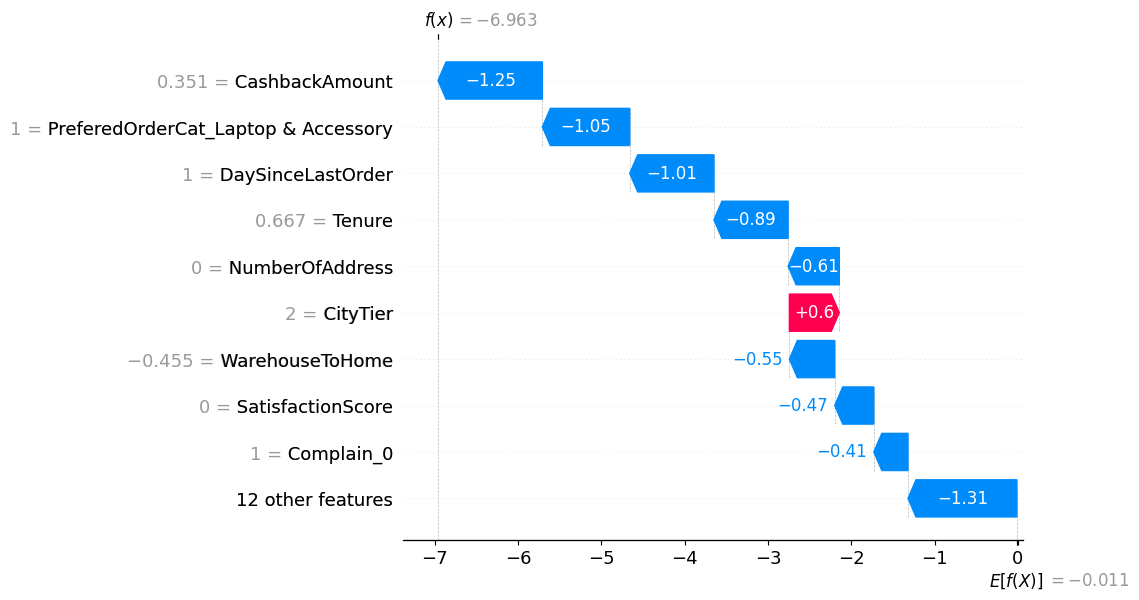

In [14]:
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Load the best pipeline ---
best_pipeline = joblib.load("best_model_fs_pipeline.pkl")

# --- Extract steps ---
preprocessor = best_pipeline.named_steps["preprocessor"]
selector = best_pipeline.named_steps.get("select", None)  # feature selector may exist
model = best_pipeline.named_steps["model"]

# --- Get feature names after preprocessing ---
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, "get_feature_names_out"):
        feature_names.extend(trans.get_feature_names_out(cols))
    else:
        feature_names.extend(cols)

# --- Transform X_test through preprocessor (and selector if present) ---
X_pre = preprocessor.transform(X_test)

if selector is not None:
    X_test_transformed = selector.transform(X_pre)
    mask = selector.get_support()
    selected_features = [f for f, keep in zip(feature_names, mask) if keep]
else:
    X_test_transformed = X_pre
    selected_features = feature_names

# Convert to DataFrame (helps shap & plotting)
X_test_df = pd.DataFrame(X_test_transformed, columns=selected_features, index=X_test.index)

# --- SHAP explainer ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)

# Handle binary vs multiclass
if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1]  # class 1 = churn
    base_value = explainer.expected_value[1]
else:
    shap_values_to_use = shap_values
    base_value = explainer.expected_value

# --- 1. Beeswarm plot (global importance) ---
shap.summary_plot(shap_values_to_use, X_test_df, feature_names=selected_features, show=True)

# --- 2. Local explanation for one sample ---
idx = 0
print("Predicted class:", best_pipeline.predict(X_test.iloc[[idx]])[0])
print("Actual class:", y_test.iloc[idx])

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_to_use[idx],
        base_values=base_value,
        data=X_test_df.iloc[idx],
        feature_names=selected_features
    )
)


* **Top Predictors of Churn:**
    * **Tenure:** This is the **single most important feature** in predicting churn. Customers with **low tenure** (pink dots on the positive side of the `Tenure` row) have a much higher likelihood of churning, while those with **high tenure** (blue dots on the negative side) are very likely to stay.
    * **Complain:** Customers who have made a complaint (`Complain_0` is false, i.e., they complained) have a very high positive SHAP value, indicating they are **highly likely to churn**.
    * **Number of Addresses:** A **lower number of addresses** (pink dots) is associated with an increased likelihood of churn.
* **Other Key Insights:**
    * **Cashback Amount:** Customers with **low cashback amounts** (pink dots) are more prone to churning.
    * **Day Since Last Order & Warehouse to Home:** Longer periods since the last order and greater distance from the warehouse to home (pink dots) both contribute to a higher churn risk.
    * **Satisfaction Score:** A **higher satisfaction score** (pink dots) is clearly correlated with a higher probability of churning. (Satisfaction scores maybe measured not from purchase reviews, but from app reviews or customer service feedback.)
    * **Order Count:** While it was a positive factor for the single customer in the waterfall plot, the beeswarm plot shows a more complex relationship. Higher order counts (pink dots on the right) seem to slightly increase churn risk, while lower counts (blue dots) decrease it. This is an interesting finding that may require further investigation, as it could indicate that a high frequency of small orders is a sign of a less engaged customer.

# 6. Conclusion & Recommendations

## 6.1. 📈 Conclusions

A high-performing **XGBoost** model is successfully developed to predict customer churn.  
Using a **SelectPercentile feature selection (70%)**, the number of features was reduced from **31 to 21** while maintaining strong model performance.  

The primary metric, **F2-Score**, which prioritizes recall (catching churners), remains excellent, with the feature-selected model achieving a score of **0.960**.  

✅ This demonstrates that the model is highly effective at identifying customers at risk of churning while operating with a more compact feature set.

***

* **Tenure:** This is the **most significant predictor** of churn. New customers (`low Tenure`) are far more likely to churn than long-term customers. This is a common pattern and suggests that the initial customer experience is critical.
* **Customer Complaints:** Having a complaint on file (`Complain_0`) is the **second most important factor** and a very strong indicator of churn risk. Customers who have complained are highly likely to leave.
* **Payment and Login Methods:** The preferred payment mode (`PreferredPaymentMode_Credit Card`, `PreferredPaymentMode_E wallet`) and login device (`PreferredLoginDevice_Computer`) are important signals. This may suggest that customers who use specific methods or devices have different engagement patterns.
* **Marital Status:** Being single (`MaritalStatus_Single`) is a notable predictor of churn, while being married has a smaller impact. This finding aligns with the observation that different customer demographics have different churn probabilities.
* **Order and Engagement Metrics:** Features like `OrderAmountHikeFromlastYear`, `NumberOfAddress`, and `CashbackAmount` all have a strong negative correlation with churn. Customers who show have more addresses, receive higher cashback are much less likely to churn. The `SatisfactionScore` may not have clear measure in what context it is since it has a strong positive correlation with churn. (Satisfaction scores maybe measured not from purchase reviews, but from app reviews or customer service feedback.) 

## 6.2. Recommendations & Actionable Insights ✅

1.  **Focus on New Customer Retention:** Since `Tenure` is the top predictor, create a proactive retention strategy specifically for new customers in their first few months. This could include personalized onboarding, exclusive offers, or check-in surveys to ensure they have a positive experience.
2.  **Establish a Complaint Resolution Task Force:** Given the strong link between complaints and churn, implement a high-priority system to handle customer complaints swiftly and effectively. The goal should be to resolve issues to the customer's satisfaction within a specific timeframe and monitor their engagement afterward.
3.  **Launch a Customer Engagement Program:** Use the model to identify customers with low `SatisfactionScore` or low `CashbackAmount` and target them with personalized campaigns. For example, offer a loyalty program that rewards higher cashback or a survey with a discount incentive to improve their satisfaction.
4.  **Develop Targeted Campaigns for Specific Demographics:** Use the insights from the `MaritalStatus` feature to create tailored marketing campaigns. For example, offer benefits or products that appeal to single customers to increase their engagement and loyalty.

## ⚡ 6.3. Measurable Business Impact

![](./assets/final_fs_confusion_matrix.png)

### Assumptions for this Simulation 💰

We’ll calculate costs using the general formula:  

**Total Cost = (FP + TP) × CRC + FN × CAC**

* **Customer Retention Cost (CRC):** $17  
* **Customer Acquisition Cost (CAC):** $85 [Reference](https://www.upcounting.com/blog/average-ecommerce-customer-acquisition-cost?utm_source=chatgpt.com)   
* **Sample Size:** 1,126 customers  

---

### 1. Cost With Model (Best Pipeline Confusion Matrix)

- **TP = 183**  
- **FP = 10**  
- **FN = 7**  

**Calculation:**  
- (TP + FP) × CRC = (183 + 10) × 50 = 193 × 17 = **$3,281**  
- FN × CAC = 7 × 85 = **$595**  
- **Total Cost (With Model) = $3,281 + $595 = $3,876**  

---

### 2. Cost Without Model (Naive: Treat All as At-Risk)

- **TP = 190** (all churners)  
- **FP = 936** (all non-churners treated as at-risk)  
- **FN = 0**  

**Calculation:**  
- (TP + FP) × CRC = (190 + 936) × 17 = 1,126 × 17 = **$19,142**  
- FN × CAC = 0 × 85 = **$0**  
- **Total Cost (Without Model) = $19,142**  

---

### 3. Cost Comparison  

| Scenario         | Formula Applied                       | Total Cost |
|------------------|---------------------------------------|------------|
| **With Model**   | (TP + FP) × CRC + FN × CAC = 193×17 + 7×85 | **$3,876** |
| **Without Model**| (TP + FP) × CRC + FN × CAC = 1,126×17 + 0   | **$19,142** |
| **Savings**      | —                                     | **$15,266** |

---

✅ By deploying this model, the business reduces costs from **$19,142** down to **$3,876**, achieving a net saving of **$15,266** — which is roughly **79.7% lower cost** compared to the naive approach.